In [1]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
import keras as keras 
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import tensorflow as tf
#import tensorflow_datasets as tfds
import scipy
import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"
# Hyper-parameters
K.clear_session() ## needed???
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32

### ???
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  # I do not know why I have to do this but gpu does not work otherwise.
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
## import svhn_cropped which is svhn in 32x32 size

# Open the file as readonly
h5f = h5py.File('SVHN_gray.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
Y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, Y_train.shape)
print('Validation set', X_val.shape, Y_val.shape)
print('Test set', X_test.shape, Y_test.shape)


Training set (58605, 32, 32, 1) (58605, 10)
Validation set (14652, 32, 32, 1) (14652, 10)
Test set (26032, 32, 32, 1) (26032, 10)


In [3]:
## import mnist
(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()

x_train = np.pad(x_train,((0,0),(2,2),(2,2))) #padding to make images 32x32 and not 28x28
x_test = np.pad(x_test,((0,0),(2,2),(2,2))) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## normalising
x_train /= 255.0 
x_test /= 255.0

## make labels into categorical classes
y_train = keras.utils.to_categorical(lbl_train, num_classes)
y_test = keras.utils.to_categorical(lbl_test, num_classes)


x_train=np.expand_dims(x_train,3)
x_test=np.expand_dims(x_test,3)

print('Training set', x_train.shape, y_train.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test.shape, y_test.shape)


Training set (60000, 32, 32, 1) (60000, 10)
Test set (10000, 32, 32, 1) (10000, 10)


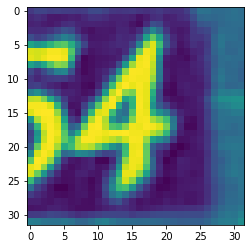

In [4]:
plt.imshow(X_test[307]) 


In [5]:
## implement LeNet-5 architecture
def init_model():
    model = Sequential()
    model.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    model.add(Flatten())
    #model.add(Dense(120, activation='tanh'))  #equivalent to the last conv2d above?
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [6]:
## implement LeNet-5-like architecture
def init_SVHN_model():
    model = Sequential()
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(128,(5,5),strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(3072, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

'''
We use stochastic gradient descent with
momentum: 0.9
weight_decay: 0.0005
------ this was not used on mnist<->svhn tests
and the learning rate annealing described by the following formula:
µp =µ0/(1 + α · p)^β,
where p is the training progress linearly changing from 0
to 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule
was optimized to promote convergence and low error on
the source domain).
------

Following (Srivastava et al., 2014) we also use dropout and
l_2-norm restriction when we train the SVHN architecture.
'''

'\nWe use stochastic gradient descent with\nmomentum: 0.9\nweight_decay: 0.0005\n------ this was not used on mnist<->svhn tests\nand the learning rate annealing described by the following formula:\nµp =µ0/(1 + α · p)^β,\nwhere p is the training progress linearly changing from 0\nto 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule\nwas optimized to promote convergence and low error on\nthe source domain).\n------\n\nFollowing (Srivastava et al., 2014) we also use dropout and\nl_2-norm restriction when we train the SVHN architecture.\n'

In [7]:
## implement LeNet-5-like architecture
def init_MNIST_model():
    model = Sequential()
    model.add(Conv2D(32,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Conv2D(48,(5,5),strides=(1,1), activation='relu')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [8]:
## shamelessly taken from : https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras

## Custom callback to be able to evaluate and save the results from several validation sets during training
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for i, result in enumerate(results):
                
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i].name
                self.history.setdefault(valuename, []).append(result)

In [ ]:
total_epochs=3

iterations=1

### MNIST -> SVHN
for i in range(iterations):
    model=init_MNIST_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy'],)

    fit_info = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
          )

In [ ]:
total_epochs=3
history = AdditionalValidationSets([(x_test, y_test, 'target_val')])
histories2=[]
iterations=2
batch_size=128




### SVHN -> MNIST
for i in range(iterations):
    model=init_SVHN_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
        metrics=['accuracy'],)

    with tf.device('/gpu:0'):
        fit_info = model.fit(X_train, Y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(X_test, Y_test),
           callbacks=[history])
    histories2.append(history.history)

Epoch 1/300
469/469 [==============================] - 4s 4ms/step - loss: 1.2134 - accuracy: 0.6171 - val_loss: 0.1642 - val_accuracy: 0.9464
Epoch 2/300
469/469 [==============================] - 1s 3ms/step - loss: 0.1608 - accuracy: 0.9487 - val_loss: 0.0944 - val_accuracy: 0.9707
Epoch 3/300
469/469 [==============================] - 1s 3ms/step - loss: 0.1025 - accuracy: 0.9677 - val_loss: 0.0714 - val_accuracy: 0.9770
Epoch 4/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0778 - accuracy: 0.9756 - val_loss: 0.0690 - val_accuracy: 0.9791
Epoch 5/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0666 - accuracy: 0.9790 - val_loss: 0.0645 - val_accuracy: 0.9785
Epoch 6/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0569 - accuracy: 0.9822 - val_loss: 0.0542 - val_accuracy: 0.9824
Epoch 7/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 0.0438 - val_accuracy: 0.9867

Epoch 58/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0466 - val_accuracy: 0.9894
Epoch 59/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0472 - val_accuracy: 0.9898
Epoch 60/300
469/469 [==============================] - 1s 3ms/step - loss: 9.4464e-04 - accuracy: 0.9998 - val_loss: 0.0482 - val_accuracy: 0.9901
Epoch 61/300
469/469 [==============================] - 1s 3ms/step - loss: 9.1099e-04 - accuracy: 0.9998 - val_loss: 0.0497 - val_accuracy: 0.9898
Epoch 62/300
469/469 [==============================] - 1s 3ms/step - loss: 9.3750e-04 - accuracy: 0.9998 - val_loss: 0.0457 - val_accuracy: 0.9900
Epoch 63/300
469/469 [==============================] - 1s 3ms/step - loss: 9.7751e-04 - accuracy: 0.9997 - val_loss: 0.0452 - val_accuracy: 0.9899
Epoch 64/300
469/469 [==============================] - 1s 3ms/step - loss: 6.5620e-04 - accuracy: 0.9999 - val_loss: 0.

469/469 [==============================] - 2s 3ms/step - loss: 7.5460e-05 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy: 0.9900
Epoch 114/300
469/469 [==============================] - 2s 3ms/step - loss: 7.4985e-05 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 0.9901
Epoch 115/300
469/469 [==============================] - 2s 3ms/step - loss: 6.3883e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9901
Epoch 116/300
469/469 [==============================] - 2s 3ms/step - loss: 6.7437e-05 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9902
Epoch 117/300
469/469 [==============================] - 2s 3ms/step - loss: 6.8150e-05 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 0.9901
Epoch 118/300
469/469 [==============================] - 2s 3ms/step - loss: 6.5981e-05 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9901
Epoch 119/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3734e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 3.6021e-05 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9900
Epoch 169/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5255e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9901
Epoch 170/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9369e-05 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9900
Epoch 171/300
469/469 [==============================] - 2s 3ms/step - loss: 3.4204e-05 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9902
Epoch 172/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3161e-05 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9899
Epoch 173/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2970e-05 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9900
Epoch 174/300
469/469 [==============================] - 1s 3ms/step - loss: 3.1174e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 2.4691e-05 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 0.9899
Epoch 224/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5416e-05 - accuracy: 1.0000 - val_loss: 0.0676 - val_accuracy: 0.9899
Epoch 225/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1384e-05 - accuracy: 1.0000 - val_loss: 0.0676 - val_accuracy: 0.9898
Epoch 226/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2525e-05 - accuracy: 1.0000 - val_loss: 0.0676 - val_accuracy: 0.9898
Epoch 227/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3438e-05 - accuracy: 1.0000 - val_loss: 0.0677 - val_accuracy: 0.9899
Epoch 228/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2650e-05 - accuracy: 1.0000 - val_loss: 0.0676 - val_accuracy: 0.9898
Epoch 229/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3906e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.6340e-05 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9899
Epoch 279/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6851e-05 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9901
Epoch 280/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6106e-05 - accuracy: 1.0000 - val_loss: 0.0702 - val_accuracy: 0.9900
Epoch 281/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6033e-05 - accuracy: 1.0000 - val_loss: 0.0704 - val_accuracy: 0.9900
Epoch 282/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5688e-05 - accuracy: 1.0000 - val_loss: 0.0705 - val_accuracy: 0.9899
Epoch 283/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5546e-05 - accuracy: 1.0000 - val_loss: 0.0704 - val_accuracy: 0.9901
Epoch 284/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5592e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0399 - val_accuracy: 0.9895
Epoch 35/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.0352 - val_accuracy: 0.9902
Epoch 36/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0380 - val_accuracy: 0.9902
Epoch 37/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0375 - val_accuracy: 0.9900
Epoch 38/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0419 - val_accuracy: 0.9885
Epoch 39/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0376 - val_accuracy: 0.9903
Epoch 40/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0386 - val_accuracy: 0.9898
Epoch

469/469 [==============================] - 2s 3ms/step - loss: 1.1146e-04 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9901
Epoch 91/300
469/469 [==============================] - 1s 3ms/step - loss: 1.1104e-04 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 0.9901
Epoch 92/300
469/469 [==============================] - 1s 3ms/step - loss: 1.2249e-04 - accuracy: 1.0000 - val_loss: 0.0512 - val_accuracy: 0.9902
Epoch 93/300
469/469 [==============================] - 1s 3ms/step - loss: 9.1109e-05 - accuracy: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9900
Epoch 94/300
469/469 [==============================] - 1s 3ms/step - loss: 9.7588e-05 - accuracy: 1.0000 - val_loss: 0.0512 - val_accuracy: 0.9897
Epoch 95/300
469/469 [==============================] - 1s 3ms/step - loss: 9.8615e-05 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 0.9902
Epoch 96/300
469/469 [==============================] - 1s 3ms/step - loss: 8.9221e-05 - accuracy: 1.0000 - val_loss: 0.0513 

469/469 [==============================] - 2s 3ms/step - loss: 4.1439e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9901
Epoch 146/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1018e-05 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 0.9900
Epoch 147/300
469/469 [==============================] - 1s 3ms/step - loss: 4.2514e-05 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 0.9901
Epoch 148/300
469/469 [==============================] - 1s 3ms/step - loss: 4.2290e-05 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9899
Epoch 149/300
469/469 [==============================] - 2s 3ms/step - loss: 3.9689e-05 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 0.9901
Epoch 150/300
469/469 [==============================] - 1s 3ms/step - loss: 4.0596e-05 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9903
Epoch 151/300
469/469 [==============================] - 1s 3ms/step - loss: 4.6014e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.6330e-05 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 0.9898
Epoch 201/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5666e-05 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 0.9901
Epoch 202/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5494e-05 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.9901
Epoch 203/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6446e-05 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 0.9900
Epoch 204/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6473e-05 - accuracy: 1.0000 - val_loss: 0.0604 - val_accuracy: 0.9899
Epoch 205/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3495e-05 - accuracy: 1.0000 - val_loss: 0.0605 - val_accuracy: 0.9900
Epoch 206/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5717e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 1.8630e-05 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9901
Epoch 256/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8299e-05 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9901
Epoch 257/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7912e-05 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 258/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7692e-05 - accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9899
Epoch 259/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8017e-05 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9900
Epoch 260/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7987e-05 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9901
Epoch 261/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7531e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 0.0350 - accuracy: 0.9896 - val_loss: 0.0436 - val_accuracy: 0.9852
Epoch 11/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.0370 - val_accuracy: 0.9885
Epoch 12/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.0338 - val_accuracy: 0.9884
Epoch 13/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0266 - accuracy: 0.9916 - val_loss: 0.0415 - val_accuracy: 0.9872
Epoch 14/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0270 - accuracy: 0.9912 - val_loss: 0.0380 - val_accuracy: 0.9880
Epoch 15/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0334 - val_accuracy: 0.9888
Epoch 16/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0344 - val_accuracy: 0.9899
Epoch

Epoch 67/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0438 - val_accuracy: 0.9904
Epoch 68/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0465 - val_accuracy: 0.9905
Epoch 69/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0442 - val_accuracy: 0.9909
Epoch 70/300
469/469 [==============================] - 2s 3ms/step - loss: 7.0452e-04 - accuracy: 0.9999 - val_loss: 0.0443 - val_accuracy: 0.9899
Epoch 71/300
469/469 [==============================] - 1s 3ms/step - loss: 9.2041e-04 - accuracy: 0.9999 - val_loss: 0.0406 - val_accuracy: 0.9914
Epoch 72/300
469/469 [==============================] - 1s 3ms/step - loss: 4.5841e-04 - accuracy: 0.9999 - val_loss: 0.0417 - val_accuracy: 0.9910
Epoch 73/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4177e-04 - accuracy: 1.0000 - val_loss: 0.0440

469/469 [==============================] - 1s 3ms/step - loss: 6.1835e-05 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 0.9906
Epoch 123/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6977e-05 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9907
Epoch 124/300
469/469 [==============================] - 1s 3ms/step - loss: 5.9662e-05 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9905
Epoch 125/300
469/469 [==============================] - 1s 3ms/step - loss: 5.4763e-05 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9908
Epoch 126/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6515e-05 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9909
Epoch 127/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6906e-05 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 0.9905
Epoch 128/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6125e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 3.3671e-05 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9907
Epoch 178/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2794e-05 - accuracy: 1.0000 - val_loss: 0.0552 - val_accuracy: 0.9906
Epoch 179/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2639e-05 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9907
Epoch 180/300
469/469 [==============================] - 1s 3ms/step - loss: 2.9002e-05 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 0.9907
Epoch 181/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3921e-05 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 0.9908
Epoch 182/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2679e-05 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 0.9905
Epoch 183/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5348e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.9460e-05 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9908
Epoch 233/300
469/469 [==============================] - 2s 3ms/step - loss: 2.0592e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9908
Epoch 234/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1457e-05 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9907
Epoch 235/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2150e-05 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9907
Epoch 236/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9558e-05 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9906
Epoch 237/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1709e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9907
Epoch 238/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9952e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 1.5689e-05 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.9906
Epoch 288/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5861e-05 - accuracy: 1.0000 - val_loss: 0.0601 - val_accuracy: 0.9907
Epoch 289/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4676e-05 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 0.9908
Epoch 290/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6465e-05 - accuracy: 1.0000 - val_loss: 0.0601 - val_accuracy: 0.9906
Epoch 291/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5947e-05 - accuracy: 1.0000 - val_loss: 0.0601 - val_accuracy: 0.9905
Epoch 292/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6737e-05 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 0.9907
Epoch 293/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4106e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0370 - val_accuracy: 0.9898
Epoch 44/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0400 - val_accuracy: 0.9893
Epoch 45/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0340 - val_accuracy: 0.9906
Epoch 46/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0412 - val_accuracy: 0.9900
Epoch 47/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0366 - val_accuracy: 0.9901
Epoch 48/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0376 - val_accuracy: 0.9898
Epoch 49/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0400 - val_accuracy: 0.9902
Epoch

469/469 [==============================] - 1s 3ms/step - loss: 1.0649e-04 - accuracy: 1.0000 - val_loss: 0.0482 - val_accuracy: 0.9904
Epoch 100/300
469/469 [==============================] - 1s 3ms/step - loss: 1.3337e-04 - accuracy: 1.0000 - val_loss: 0.0473 - val_accuracy: 0.9901
Epoch 101/300
469/469 [==============================] - 1s 3ms/step - loss: 1.1103e-04 - accuracy: 1.0000 - val_loss: 0.0473 - val_accuracy: 0.9900
Epoch 102/300
469/469 [==============================] - 1s 3ms/step - loss: 1.0557e-04 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 0.9900
Epoch 103/300
469/469 [==============================] - 1s 3ms/step - loss: 9.3321e-05 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9903
Epoch 104/300
469/469 [==============================] - 1s 3ms/step - loss: 9.2463e-05 - accuracy: 1.0000 - val_loss: 0.0480 - val_accuracy: 0.9898
Epoch 105/300
469/469 [==============================] - 2s 3ms/step - loss: 9.0209e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 4.6495e-05 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9902
Epoch 155/300
469/469 [==============================] - 2s 3ms/step - loss: 4.1007e-05 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9903
Epoch 156/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1616e-05 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9904
Epoch 157/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9702e-05 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9902
Epoch 158/300
469/469 [==============================] - 1s 3ms/step - loss: 4.0570e-05 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9902
Epoch 159/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1612e-05 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9903
Epoch 160/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8501e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 2.6523e-05 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9901
Epoch 210/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6362e-05 - accuracy: 1.0000 - val_loss: 0.0561 - val_accuracy: 0.9903
Epoch 211/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4877e-05 - accuracy: 1.0000 - val_loss: 0.0561 - val_accuracy: 0.9900
Epoch 212/300
469/469 [==============================] - 1s 3ms/step - loss: 2.7390e-05 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9901
Epoch 213/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6167e-05 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 0.9899
Epoch 214/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4049e-05 - accuracy: 1.0000 - val_loss: 0.0563 - val_accuracy: 0.9901
Epoch 215/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4178e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.7849e-05 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9900
Epoch 265/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8629e-05 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9903
Epoch 266/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7427e-05 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9900
Epoch 267/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8937e-05 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9901
Epoch 268/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7748e-05 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9902
Epoch 269/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6906e-05 - accuracy: 1.0000 - val_loss: 0.0586 - val_accuracy: 0.9901
Epoch 270/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6262e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 20/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0287 - val_accuracy: 0.9911
Epoch 21/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0270 - val_accuracy: 0.9909
Epoch 22/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.0299 - val_accuracy: 0.9910
Epoch 23/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.0335 - val_accuracy: 0.9897
Epoch 24/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.0296 - val_accuracy: 0.9915
Epoch 25/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0302 - val_accuracy: 0.9900
Epoch 26/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0322 - val_accuracy:

469/469 [==============================] - 1s 3ms/step - loss: 3.3808e-04 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9917
Epoch 77/300
469/469 [==============================] - 1s 3ms/step - loss: 3.1245e-04 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 0.9920
Epoch 78/300
469/469 [==============================] - 2s 3ms/step - loss: 8.4132e-04 - accuracy: 0.9998 - val_loss: 0.0477 - val_accuracy: 0.9896
Epoch 79/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0376 - val_accuracy: 0.9907
Epoch 80/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0418 - val_accuracy: 0.9908
Epoch 81/300
469/469 [==============================] - 1s 3ms/step - loss: 6.0083e-04 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9920
Epoch 82/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8619e-04 - accuracy: 1.0000 - val_loss: 0.0377 - val_ac

469/469 [==============================] - 2s 3ms/step - loss: 5.2585e-05 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9915
Epoch 132/300
469/469 [==============================] - 1s 3ms/step - loss: 4.6890e-05 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9918
Epoch 133/300
469/469 [==============================] - 2s 3ms/step - loss: 4.8325e-05 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9917
Epoch 134/300
469/469 [==============================] - 2s 3ms/step - loss: 4.6837e-05 - accuracy: 1.0000 - val_loss: 0.0436 - val_accuracy: 0.9916
Epoch 135/300
469/469 [==============================] - 2s 3ms/step - loss: 4.5934e-05 - accuracy: 1.0000 - val_loss: 0.0439 - val_accuracy: 0.9915
Epoch 136/300
469/469 [==============================] - 1s 3ms/step - loss: 4.4759e-05 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9914
Epoch 137/300
469/469 [==============================] - 2s 3ms/step - loss: 4.6831e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.9843e-05 - accuracy: 1.0000 - val_loss: 0.0463 - val_accuracy: 0.9915
Epoch 187/300
469/469 [==============================] - 2s 3ms/step - loss: 3.0753e-05 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 0.9914
Epoch 188/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7297e-05 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 0.9915
Epoch 189/300
469/469 [==============================] - 2s 3ms/step - loss: 2.8723e-05 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 0.9914
Epoch 190/300
469/469 [==============================] - 2s 3ms/step - loss: 2.9900e-05 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 0.9912
Epoch 191/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6772e-05 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 0.9914
Epoch 192/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6419e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.9177e-05 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9912
Epoch 242/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9791e-05 - accuracy: 1.0000 - val_loss: 0.0487 - val_accuracy: 0.9912
Epoch 243/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0513e-05 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9913
Epoch 244/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8055e-05 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9912
Epoch 245/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0856e-05 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9911
Epoch 246/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9219e-05 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9911
Epoch 247/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7350e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.4145e-05 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9911
Epoch 297/300
469/469 [==============================] - 2s 3ms/step - loss: 1.3652e-05 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 0.9910
Epoch 298/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4102e-05 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 0.9911
Epoch 299/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4356e-05 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9912
Epoch 300/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4084e-05 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 0.9911
Epoch 1/300
469/469 [==============================] - 2s 3ms/step - loss: 1.2373 - accuracy: 0.6125 - val_loss: 0.1576 - val_accuracy: 0.9507
Epoch 2/300
469/469 [==============================] - 2s 3ms/step - loss: 0.1461 - accuracy: 0.9557 - val_loss: 0.0881 - val_

Epoch 53/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0416 - val_accuracy: 0.9891
Epoch 54/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0431 - val_accuracy: 0.9886
Epoch 55/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0411 - val_accuracy: 0.9900
Epoch 56/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0427 - val_accuracy: 0.9897
Epoch 57/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0466 - val_accuracy: 0.9897
Epoch 58/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0392 - val_accuracy: 0.9911
Epoch 59/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0407 - val_accuracy:

Epoch 109/300
469/469 [==============================] - 2s 3ms/step - loss: 9.7474e-05 - accuracy: 1.0000 - val_loss: 0.0535 - val_accuracy: 0.9902
Epoch 110/300
469/469 [==============================] - 2s 3ms/step - loss: 8.0233e-05 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 0.9904
Epoch 111/300
469/469 [==============================] - 2s 3ms/step - loss: 9.2981e-05 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9904
Epoch 112/300
469/469 [==============================] - 1s 3ms/step - loss: 8.3775e-05 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9903
Epoch 113/300
469/469 [==============================] - 2s 3ms/step - loss: 8.0795e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9903
Epoch 114/300
469/469 [==============================] - 2s 3ms/step - loss: 8.4919e-05 - accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 0.9906
Epoch 115/300
469/469 [==============================] - 1s 3ms/step - loss: 8.0058e-05 - accuracy: 1.0000

Epoch 164/300
469/469 [==============================] - 2s 3ms/step - loss: 3.9908e-05 - accuracy: 1.0000 - val_loss: 0.0591 - val_accuracy: 0.9901
Epoch 165/300
469/469 [==============================] - 2s 3ms/step - loss: 4.2464e-05 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9902
Epoch 166/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1053e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9901
Epoch 167/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8586e-05 - accuracy: 1.0000 - val_loss: 0.0595 - val_accuracy: 0.9902
Epoch 168/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1270e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9902
Epoch 169/300
469/469 [==============================] - 2s 3ms/step - loss: 3.6360e-05 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9903
Epoch 170/300
469/469 [==============================] - 2s 3ms/step - loss: 3.8315e-05 - accuracy: 1.0000

Epoch 219/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6061e-05 - accuracy: 1.0000 - val_loss: 0.0625 - val_accuracy: 0.9901
Epoch 220/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5540e-05 - accuracy: 1.0000 - val_loss: 0.0628 - val_accuracy: 0.9902
Epoch 221/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2512e-05 - accuracy: 1.0000 - val_loss: 0.0626 - val_accuracy: 0.9901
Epoch 222/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4478e-05 - accuracy: 1.0000 - val_loss: 0.0628 - val_accuracy: 0.9902
Epoch 223/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3562e-05 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9899
Epoch 224/300
469/469 [==============================] - 2s 3ms/step - loss: 2.3728e-05 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9901
Epoch 225/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5700e-05 - accuracy: 1.0000

Epoch 274/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8595e-05 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9902
Epoch 275/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7141e-05 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9904
Epoch 276/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6948e-05 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9902
Epoch 277/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9009e-05 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9902
Epoch 278/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7015e-05 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9903
Epoch 279/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8557e-05 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9901
Epoch 280/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6581e-05 - accuracy: 1.0000

469/469 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 0.9967 - val_loss: 0.0324 - val_accuracy: 0.9902
Epoch 31/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0386 - val_accuracy: 0.9879
Epoch 32/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0387 - val_accuracy: 0.9887
Epoch 33/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0319 - val_accuracy: 0.9899
Epoch 34/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0411 - val_accuracy: 0.9887
Epoch 35/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0419 - val_accuracy: 0.9886
Epoch 36/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0379 - val_accuracy: 0.9892
Epoch

469/469 [==============================] - 2s 3ms/step - loss: 1.4074e-04 - accuracy: 1.0000 - val_loss: 0.0524 - val_accuracy: 0.9897
Epoch 87/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5210e-04 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9898
Epoch 88/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5397e-04 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 0.9895
Epoch 89/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5639e-04 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9894
Epoch 90/300
469/469 [==============================] - 1s 3ms/step - loss: 1.3697e-04 - accuracy: 1.0000 - val_loss: 0.0535 - val_accuracy: 0.9896
Epoch 91/300
469/469 [==============================] - 1s 3ms/step - loss: 1.3127e-04 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9896
Epoch 92/300
469/469 [==============================] - 2s 3ms/step - loss: 1.2216e-04 - accuracy: 1.0000 - val_loss: 0.0541 

469/469 [==============================] - 1s 3ms/step - loss: 4.7969e-05 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.9890
Epoch 142/300
469/469 [==============================] - 2s 3ms/step - loss: 4.6349e-05 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9892
Epoch 143/300
469/469 [==============================] - 1s 3ms/step - loss: 4.6876e-05 - accuracy: 1.0000 - val_loss: 0.0606 - val_accuracy: 0.9892
Epoch 144/300
469/469 [==============================] - 2s 3ms/step - loss: 4.3614e-05 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9894
Epoch 145/300
469/469 [==============================] - 2s 3ms/step - loss: 4.4790e-05 - accuracy: 1.0000 - val_loss: 0.0605 - val_accuracy: 0.9893
Epoch 146/300
469/469 [==============================] - 1s 3ms/step - loss: 4.2143e-05 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.9892
Epoch 147/300
469/469 [==============================] - 2s 3ms/step - loss: 4.4117e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.5872e-05 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9890
Epoch 197/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6797e-05 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9892
Epoch 198/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6519e-05 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9892
Epoch 199/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6379e-05 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9890
Epoch 200/300
469/469 [==============================] - 1s 3ms/step - loss: 2.9664e-05 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9891
Epoch 201/300
469/469 [==============================] - 2s 3ms/step - loss: 2.8681e-05 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9890
Epoch 202/300
469/469 [==============================] - 2s 3ms/step - loss: 2.8001e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 1.8809e-05 - accuracy: 1.0000 - val_loss: 0.0681 - val_accuracy: 0.9892
Epoch 252/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1129e-05 - accuracy: 1.0000 - val_loss: 0.0680 - val_accuracy: 0.9891
Epoch 253/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7699e-05 - accuracy: 1.0000 - val_loss: 0.0683 - val_accuracy: 0.9892
Epoch 254/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9432e-05 - accuracy: 1.0000 - val_loss: 0.0683 - val_accuracy: 0.9890
Epoch 255/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7819e-05 - accuracy: 1.0000 - val_loss: 0.0684 - val_accuracy: 0.9894
Epoch 256/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8652e-05 - accuracy: 1.0000 - val_loss: 0.0683 - val_accuracy: 0.9890
Epoch 257/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8356e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.0541 - accuracy: 0.9833 - val_loss: 0.0450 - val_accuracy: 0.9846
Epoch 7/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0483 - accuracy: 0.9848 - val_loss: 0.0460 - val_accuracy: 0.9850
Epoch 8/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0363 - val_accuracy: 0.9881
Epoch 9/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0374 - accuracy: 0.9893 - val_loss: 0.0444 - val_accuracy: 0.9845
Epoch 10/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0353 - accuracy: 0.9891 - val_loss: 0.0345 - val_accuracy: 0.9889
Epoch 11/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0323 - accuracy: 0.9892 - val_loss: 0.0369 - val_accuracy: 0.9877
Epoch 12/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0295 - accuracy: 0.9902 - val_loss: 0.0350 - val_accuracy: 0.9883
Epoch 13

469/469 [==============================] - 1s 3ms/step - loss: 7.6039e-04 - accuracy: 0.9998 - val_loss: 0.0382 - val_accuracy: 0.9911
Epoch 64/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0406 - val_accuracy: 0.9909
Epoch 65/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0368 - val_accuracy: 0.9911
Epoch 66/300
469/469 [==============================] - 2s 3ms/step - loss: 7.8795e-04 - accuracy: 0.9998 - val_loss: 0.0393 - val_accuracy: 0.9907
Epoch 67/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0374 - val_accuracy: 0.9908
Epoch 68/300
469/469 [==============================] - 1s 3ms/step - loss: 4.7257e-04 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9915
Epoch 69/300
469/469 [==============================] - 2s 3ms/step - loss: 6.5737e-04 - accuracy: 0.9999 - val_loss: 0.0390 - val_accura

469/469 [==============================] - 1s 3ms/step - loss: 7.2998e-05 - accuracy: 1.0000 - val_loss: 0.0477 - val_accuracy: 0.9910
Epoch 119/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3013e-05 - accuracy: 1.0000 - val_loss: 0.0480 - val_accuracy: 0.9912
Epoch 120/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3718e-05 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9914
Epoch 121/300
469/469 [==============================] - 1s 3ms/step - loss: 7.3578e-05 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9915
Epoch 122/300
469/469 [==============================] - 1s 3ms/step - loss: 6.2799e-05 - accuracy: 1.0000 - val_loss: 0.0482 - val_accuracy: 0.9914
Epoch 123/300
469/469 [==============================] - 1s 3ms/step - loss: 6.2194e-05 - accuracy: 1.0000 - val_loss: 0.0482 - val_accuracy: 0.9913
Epoch 124/300
469/469 [==============================] - 1s 3ms/step - loss: 6.1748e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 3.1753e-05 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9912
Epoch 174/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3856e-05 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9909
Epoch 175/300
469/469 [==============================] - 1s 3ms/step - loss: 3.1227e-05 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9911
Epoch 176/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3204e-05 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9914
Epoch 177/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2401e-05 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9912
Epoch 178/300
469/469 [==============================] - 2s 3ms/step - loss: 3.2051e-05 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9910
Epoch 179/300
469/469 [==============================] - 1s 3ms/step - loss: 2.8997e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.1408e-05 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9911
Epoch 229/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3771e-05 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9909
Epoch 230/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2087e-05 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9907
Epoch 231/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2404e-05 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 0.9910
Epoch 232/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2467e-05 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 0.9907
Epoch 233/300
469/469 [==============================] - 2s 3ms/step - loss: 2.0812e-05 - accuracy: 1.0000 - val_loss: 0.0561 - val_accuracy: 0.9911
Epoch 234/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2683e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.6437e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9908
Epoch 284/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4966e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9904
Epoch 285/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6550e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9908
Epoch 286/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5339e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9906
Epoch 287/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5493e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9908
Epoch 288/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5176e-05 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9905
Epoch 289/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5729e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0395 - val_accuracy: 0.9891
Epoch 40/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0364 - val_accuracy: 0.9906
Epoch 41/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0382 - val_accuracy: 0.9901
Epoch 42/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0393 - val_accuracy: 0.9896
Epoch 43/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0417 - val_accuracy: 0.9892
Epoch 44/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0487 - val_accuracy: 0.9881
Epoch 45/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0404 - val_accuracy: 0.9900
Epoch

469/469 [==============================] - 2s 3ms/step - loss: 1.1300e-04 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 0.9903
Epoch 96/300
469/469 [==============================] - 1s 3ms/step - loss: 1.0428e-04 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9904
Epoch 97/300
469/469 [==============================] - 1s 3ms/step - loss: 1.1410e-04 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9904
Epoch 98/300
469/469 [==============================] - 2s 3ms/step - loss: 9.6889e-05 - accuracy: 1.0000 - val_loss: 0.0519 - val_accuracy: 0.9904
Epoch 99/300
469/469 [==============================] - 2s 3ms/step - loss: 1.1473e-04 - accuracy: 1.0000 - val_loss: 0.0521 - val_accuracy: 0.9903
Epoch 100/300
469/469 [==============================] - 2s 3ms/step - loss: 9.2250e-05 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9904
Epoch 101/300
469/469 [==============================] - 2s 3ms/step - loss: 9.0324e-05 - accuracy: 1.0000 - val_loss: 0.052

469/469 [==============================] - 1s 3ms/step - loss: 4.4770e-05 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9902
Epoch 151/300
469/469 [==============================] - 2s 3ms/step - loss: 4.0376e-05 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9903
Epoch 152/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1361e-05 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9902
Epoch 153/300
469/469 [==============================] - 1s 3ms/step - loss: 4.2206e-05 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9904
Epoch 154/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9630e-05 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9903
Epoch 155/300
469/469 [==============================] - 2s 3ms/step - loss: 4.3363e-05 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9903
Epoch 156/300
469/469 [==============================] - 2s 3ms/step - loss: 4.4727e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.5637e-05 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.9904
Epoch 206/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4944e-05 - accuracy: 1.0000 - val_loss: 0.0606 - val_accuracy: 0.9904
Epoch 207/300
469/469 [==============================] - 2s 3ms/step - loss: 2.8623e-05 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9904
Epoch 208/300
469/469 [==============================] - 2s 3ms/step - loss: 2.3531e-05 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9903
Epoch 209/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4259e-05 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9904
Epoch 210/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7869e-05 - accuracy: 1.0000 - val_loss: 0.0610 - val_accuracy: 0.9904
Epoch 211/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7077e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.9978e-05 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9904
Epoch 261/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8768e-05 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9904
Epoch 262/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9671e-05 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9903
Epoch 263/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8596e-05 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9904
Epoch 264/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0111e-05 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9904
Epoch 265/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8899e-05 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9904
Epoch 266/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7218e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 0.0247 - accuracy: 0.9919 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 16/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0337 - val_accuracy: 0.9891
Epoch 17/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.0340 - val_accuracy: 0.9896
Epoch 18/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.0358 - val_accuracy: 0.9890
Epoch 19/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0355 - val_accuracy: 0.9891
Epoch 20/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0363 - val_accuracy: 0.9894
Epoch 21/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0326 - val_accuracy: 0.9901
Epoch

Epoch 72/300
469/469 [==============================] - 2s 3ms/step - loss: 4.2408e-04 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 0.9903
Epoch 73/300
469/469 [==============================] - 2s 3ms/step - loss: 3.6825e-04 - accuracy: 1.0000 - val_loss: 0.0475 - val_accuracy: 0.9902
Epoch 74/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8363e-04 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 0.9907
Epoch 75/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6481e-04 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 0.9904
Epoch 76/300
469/469 [==============================] - 1s 3ms/step - loss: 2.8353e-04 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9901
Epoch 77/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4471e-04 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9904
Epoch 78/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9833e-04 - accuracy: 1.0000 - val_

469/469 [==============================] - 2s 3ms/step - loss: 5.6471e-05 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 0.9905
Epoch 128/300
469/469 [==============================] - 1s 3ms/step - loss: 6.0106e-05 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 0.9905
Epoch 129/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6886e-05 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 0.9904
Epoch 130/300
469/469 [==============================] - 1s 3ms/step - loss: 6.1531e-05 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9905
Epoch 131/300
469/469 [==============================] - 1s 3ms/step - loss: 5.4446e-05 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9902
Epoch 132/300
469/469 [==============================] - 2s 3ms/step - loss: 6.0181e-05 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9904
Epoch 133/300
469/469 [==============================] - 2s 3ms/step - loss: 5.6779e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 3.0577e-05 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9904
Epoch 183/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3283e-05 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9905
Epoch 184/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3131e-05 - accuracy: 1.0000 - val_loss: 0.0610 - val_accuracy: 0.9905
Epoch 185/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2291e-05 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9905
Epoch 186/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3099e-05 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9903
Epoch 187/300
469/469 [==============================] - 1s 3ms/step - loss: 3.0637e-05 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9903
Epoch 188/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3053e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.1729e-05 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9904
Epoch 238/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4547e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9904
Epoch 239/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2819e-05 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9904
Epoch 240/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3682e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9904
Epoch 241/300
469/469 [==============================] - 2s 3ms/step - loss: 2.0413e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9903
Epoch 242/300
469/469 [==============================] - 2s 3ms/step - loss: 2.0066e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9904
Epoch 243/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0127e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.5152e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9903
Epoch 293/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7504e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9903
Epoch 294/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7621e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9903
Epoch 295/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8041e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9904
Epoch 296/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5540e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9904
Epoch 297/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4905e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9903
Epoch 298/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6437e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 49/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0442 - val_accuracy: 0.9886
Epoch 50/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0403 - val_accuracy: 0.9899
Epoch 51/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0422 - val_accuracy: 0.9891
Epoch 52/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.0469 - val_accuracy: 0.9889
Epoch 53/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.0399 - val_accuracy: 0.9904
Epoch 54/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0449 - val_accuracy: 0.9892
Epoch 55/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0442 - val_accuracy:

Epoch 105/300
469/469 [==============================] - 1s 3ms/step - loss: 1.1108e-04 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 0.9910
Epoch 106/300
469/469 [==============================] - 1s 3ms/step - loss: 8.5239e-05 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9909
Epoch 107/300
469/469 [==============================] - 1s 3ms/step - loss: 9.1971e-05 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9910
Epoch 108/300
469/469 [==============================] - 1s 3ms/step - loss: 8.4754e-05 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9909
Epoch 109/300
469/469 [==============================] - 1s 3ms/step - loss: 8.1013e-05 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9910
Epoch 110/300
469/469 [==============================] - 1s 3ms/step - loss: 8.5644e-05 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9911
Epoch 111/300
469/469 [==============================] - 1s 3ms/step - loss: 7.6767e-05 - accuracy: 1.0000

Epoch 160/300
469/469 [==============================] - 1s 3ms/step - loss: 3.6505e-05 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 0.9908
Epoch 161/300
469/469 [==============================] - 2s 3ms/step - loss: 3.4893e-05 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 0.9907
Epoch 162/300
469/469 [==============================] - 1s 3ms/step - loss: 3.6313e-05 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9908
Epoch 163/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5681e-05 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 0.9909
Epoch 164/300
469/469 [==============================] - 2s 3ms/step - loss: 3.8291e-05 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9907
Epoch 165/300
469/469 [==============================] - 1s 3ms/step - loss: 3.0725e-05 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9907
Epoch 166/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4617e-05 - accuracy: 1.0000

Epoch 215/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5195e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9905
Epoch 216/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4142e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9908
Epoch 217/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2258e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9908
Epoch 218/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3247e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9908
Epoch 219/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1653e-05 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9908
Epoch 220/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1851e-05 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9909
Epoch 221/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0326e-05 - accuracy: 1.0000

Epoch 270/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7698e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9906
Epoch 271/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6213e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9908
Epoch 272/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6068e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9908
Epoch 273/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7002e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9905
Epoch 274/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8377e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9907
Epoch 275/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6577e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9907
Epoch 276/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5349e-05 - accuracy: 1.0000

Epoch 26/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0324 - val_accuracy: 0.9902
Epoch 27/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0335 - val_accuracy: 0.9911
Epoch 28/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0351 - val_accuracy: 0.9895
Epoch 29/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.0350 - val_accuracy: 0.9902
Epoch 30/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0327 - val_accuracy: 0.9895
Epoch 31/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.0387 - val_accuracy: 0.9897
Epoch 32/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.0316 - val_accuracy:

469/469 [==============================] - 2s 3ms/step - loss: 1.5877e-04 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9918
Epoch 83/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5455e-04 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 0.9917
Epoch 84/300
469/469 [==============================] - 1s 3ms/step - loss: 1.2769e-04 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9915
Epoch 85/300
469/469 [==============================] - 1s 3ms/step - loss: 1.3677e-04 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 0.9917
Epoch 86/300
469/469 [==============================] - 1s 3ms/step - loss: 1.2146e-04 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 0.9918
Epoch 87/300
469/469 [==============================] - 1s 3ms/step - loss: 1.2152e-04 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9920
Epoch 88/300
469/469 [==============================] - 1s 3ms/step - loss: 1.1426e-04 - accuracy: 1.0000 - val_loss: 0.0432 

469/469 [==============================] - 1s 3ms/step - loss: 4.2844e-05 - accuracy: 1.0000 - val_loss: 0.0480 - val_accuracy: 0.9918
Epoch 138/300
469/469 [==============================] - 1s 3ms/step - loss: 5.0798e-05 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9917
Epoch 139/300
469/469 [==============================] - 1s 3ms/step - loss: 4.7771e-05 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9918
Epoch 140/300
469/469 [==============================] - 1s 3ms/step - loss: 4.2311e-05 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9919
Epoch 141/300
469/469 [==============================] - 1s 3ms/step - loss: 4.6522e-05 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9916
Epoch 142/300
469/469 [==============================] - 1s 3ms/step - loss: 4.3320e-05 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 0.9917
Epoch 143/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8724e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.8182e-05 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9914
Epoch 193/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7237e-05 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9914
Epoch 194/300
469/469 [==============================] - 1s 3ms/step - loss: 2.7284e-05 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 0.9913
Epoch 195/300
469/469 [==============================] - 1s 3ms/step - loss: 2.7156e-05 - accuracy: 1.0000 - val_loss: 0.0521 - val_accuracy: 0.9914
Epoch 196/300
469/469 [==============================] - 1s 3ms/step - loss: 2.9664e-05 - accuracy: 1.0000 - val_loss: 0.0521 - val_accuracy: 0.9914
Epoch 197/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6249e-05 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9913
Epoch 198/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4381e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.9197e-05 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9914
Epoch 248/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9239e-05 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9912
Epoch 249/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9409e-05 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9914
Epoch 250/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9163e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9914
Epoch 251/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8231e-05 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9915
Epoch 252/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8499e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9915
Epoch 253/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7896e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.1630 - accuracy: 0.9496 - val_loss: 0.1015 - val_accuracy: 0.9663
Epoch 3/300
469/469 [==============================] - 1s 3ms/step - loss: 0.1055 - accuracy: 0.9685 - val_loss: 0.0676 - val_accuracy: 0.9796
Epoch 4/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0770 - accuracy: 0.9761 - val_loss: 0.0650 - val_accuracy: 0.9792
Epoch 5/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0657 - accuracy: 0.9788 - val_loss: 0.0552 - val_accuracy: 0.9828
Epoch 6/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0562 - accuracy: 0.9829 - val_loss: 0.0472 - val_accuracy: 0.9849
Epoch 7/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0477 - accuracy: 0.9854 - val_loss: 0.0491 - val_accuracy: 0.9841
Epoch 8/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0418 - accuracy: 0.9868 - val_loss: 0.0431 - val_accuracy: 0.9872
Epoch 9/300

469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0508 - val_accuracy: 0.9902
Epoch 60/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0483 - val_accuracy: 0.9892
Epoch 61/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0455 - val_accuracy: 0.9894
Epoch 62/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0460 - val_accuracy: 0.9900
Epoch 63/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0471 - val_accuracy: 0.9900
Epoch 64/300
469/469 [==============================] - 2s 3ms/step - loss: 9.5823e-04 - accuracy: 0.9998 - val_loss: 0.0458 - val_accuracy: 0.9903
Epoch 65/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0456 - val_accuracy: 0.9901
E

Epoch 115/300
469/469 [==============================] - 2s 3ms/step - loss: 8.1423e-05 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9906
Epoch 116/300
469/469 [==============================] - 1s 3ms/step - loss: 7.1142e-05 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9902
Epoch 117/300
469/469 [==============================] - 2s 3ms/step - loss: 7.7041e-05 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9908
Epoch 118/300
469/469 [==============================] - 2s 3ms/step - loss: 7.0414e-05 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9905
Epoch 119/300
469/469 [==============================] - 1s 3ms/step - loss: 7.1487e-05 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9905
Epoch 120/300
469/469 [==============================] - 2s 3ms/step - loss: 6.8200e-05 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9905
Epoch 121/300
469/469 [==============================] - 1s 3ms/step - loss: 6.4306e-05 - accuracy: 1.0000

Epoch 170/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3136e-05 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9905
Epoch 171/300
469/469 [==============================] - 2s 3ms/step - loss: 3.4256e-05 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9903
Epoch 172/300
469/469 [==============================] - 2s 3ms/step - loss: 3.2019e-05 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9904
Epoch 173/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2002e-05 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9905
Epoch 174/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5908e-05 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9904
Epoch 175/300
469/469 [==============================] - 2s 3ms/step - loss: 3.7177e-05 - accuracy: 1.0000 - val_loss: 0.0590 - val_accuracy: 0.9904
Epoch 176/300
469/469 [==============================] - 1s 3ms/step - loss: 2.9964e-05 - accuracy: 1.0000

Epoch 225/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2502e-05 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9900
Epoch 226/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1150e-05 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 0.9901
Epoch 227/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3121e-05 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 0.9904
Epoch 228/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1572e-05 - accuracy: 1.0000 - val_loss: 0.0623 - val_accuracy: 0.9902
Epoch 229/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2014e-05 - accuracy: 1.0000 - val_loss: 0.0626 - val_accuracy: 0.9903
Epoch 230/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2041e-05 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 0.9903
Epoch 231/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1967e-05 - accuracy: 1.0000

Epoch 280/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6847e-05 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9900
Epoch 281/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7061e-05 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9900
Epoch 282/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5058e-05 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9898
Epoch 283/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4668e-05 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9902
Epoch 284/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7136e-05 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9901
Epoch 285/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7576e-05 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9899
Epoch 286/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5762e-05 - accuracy: 1.0000

469/469 [==============================] - 1s 3ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0354 - val_accuracy: 0.9889
Epoch 37/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0368 - val_accuracy: 0.9895
Epoch 38/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0376 - val_accuracy: 0.9901
Epoch 39/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0333 - val_accuracy: 0.9907
Epoch 40/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0376 - val_accuracy: 0.9896
Epoch 41/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0457 - val_accuracy: 0.9879
Epoch 42/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0358 - val_accuracy: 0.9909
Epoch

469/469 [==============================] - 1s 3ms/step - loss: 1.1359e-04 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9904
Epoch 93/300
469/469 [==============================] - 1s 3ms/step - loss: 1.0981e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9905
Epoch 94/300
469/469 [==============================] - 2s 3ms/step - loss: 1.0512e-04 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9907
Epoch 95/300
469/469 [==============================] - 2s 3ms/step - loss: 1.0057e-04 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9905
Epoch 96/300
469/469 [==============================] - 2s 3ms/step - loss: 9.1415e-05 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9904
Epoch 97/300
469/469 [==============================] - 2s 3ms/step - loss: 9.0282e-05 - accuracy: 1.0000 - val_loss: 0.0512 - val_accuracy: 0.9901
Epoch 98/300
469/469 [==============================] - 2s 3ms/step - loss: 1.0847e-04 - accuracy: 1.0000 - val_loss: 0.0507 

469/469 [==============================] - 1s 3ms/step - loss: 4.0099e-05 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 0.9904
Epoch 148/300
469/469 [==============================] - 1s 3ms/step - loss: 4.6336e-05 - accuracy: 1.0000 - val_loss: 0.0557 - val_accuracy: 0.9904
Epoch 149/300
469/469 [==============================] - 2s 3ms/step - loss: 4.3426e-05 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 0.9904
Epoch 150/300
469/469 [==============================] - 1s 3ms/step - loss: 4.5855e-05 - accuracy: 1.0000 - val_loss: 0.0561 - val_accuracy: 0.9903
Epoch 151/300
469/469 [==============================] - 2s 3ms/step - loss: 3.9659e-05 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 0.9902
Epoch 152/300
469/469 [==============================] - 1s 3ms/step - loss: 3.7717e-05 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9902
Epoch 153/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5494e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 2.6057e-05 - accuracy: 1.0000 - val_loss: 0.0595 - val_accuracy: 0.9903
Epoch 203/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4622e-05 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9903
Epoch 204/300
469/469 [==============================] - 2s 3ms/step - loss: 2.3490e-05 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9901
Epoch 205/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6434e-05 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9902
Epoch 206/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1695e-05 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9904
Epoch 207/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3016e-05 - accuracy: 1.0000 - val_loss: 0.0597 - val_accuracy: 0.9904
Epoch 208/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3381e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.8146e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9902
Epoch 258/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8097e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9902
Epoch 259/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7541e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9902
Epoch 260/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7458e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9901
Epoch 261/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8048e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9903
Epoch 262/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7085e-05 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9902
Epoch 263/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8792e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.9895 - val_loss: 0.0425 - val_accuracy: 0.9865
Epoch 13/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.0370 - val_accuracy: 0.9883
Epoch 14/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0350 - val_accuracy: 0.9889
Epoch 15/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0259 - accuracy: 0.9916 - val_loss: 0.0357 - val_accuracy: 0.9888
Epoch 16/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.0334 - val_accuracy: 0.9900
Epoch 17/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0209 - accuracy: 0.9930 - val_loss: 0.0393 - val_accuracy: 0.9879
Epoch 18/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0326 - val_accuracy: 0.9888
Epoch

Epoch 69/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0496 - val_accuracy: 0.9903
Epoch 70/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0457 - val_accuracy: 0.9895
Epoch 71/300
469/469 [==============================] - 1s 3ms/step - loss: 5.5505e-04 - accuracy: 0.9999 - val_loss: 0.0462 - val_accuracy: 0.9905
Epoch 72/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6017e-04 - accuracy: 0.9999 - val_loss: 0.0496 - val_accuracy: 0.9897
Epoch 73/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0469 - val_accuracy: 0.9903
Epoch 74/300
469/469 [==============================] - 1s 3ms/step - loss: 6.6593e-04 - accuracy: 0.9999 - val_loss: 0.0558 - val_accuracy: 0.9888
Epoch 75/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0529 - v

469/469 [==============================] - 1s 3ms/step - loss: 5.7817e-05 - accuracy: 1.0000 - val_loss: 0.0550 - val_accuracy: 0.9905
Epoch 125/300
469/469 [==============================] - 1s 3ms/step - loss: 5.7589e-05 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 0.9904
Epoch 126/300
469/469 [==============================] - 1s 3ms/step - loss: 5.3815e-05 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9903
Epoch 127/300
469/469 [==============================] - 1s 3ms/step - loss: 6.2911e-05 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9906
Epoch 128/300
469/469 [==============================] - 1s 3ms/step - loss: 5.6336e-05 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 0.9905
Epoch 129/300
469/469 [==============================] - 1s 3ms/step - loss: 5.2614e-05 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9906
Epoch 130/300
469/469 [==============================] - 1s 3ms/step - loss: 5.2170e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 3.0571e-05 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9906
Epoch 180/300
469/469 [==============================] - 1s 3ms/step - loss: 2.8029e-05 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 0.9906
Epoch 181/300
469/469 [==============================] - 1s 3ms/step - loss: 3.0966e-05 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9906
Epoch 182/300
469/469 [==============================] - 1s 3ms/step - loss: 2.8633e-05 - accuracy: 1.0000 - val_loss: 0.0591 - val_accuracy: 0.9906
Epoch 183/300
469/469 [==============================] - 1s 3ms/step - loss: 3.0021e-05 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9906
Epoch 184/300
469/469 [==============================] - 1s 3ms/step - loss: 3.0757e-05 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9906
Epoch 185/300
469/469 [==============================] - 2s 3ms/step - loss: 2.9503e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.0700e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9906
Epoch 235/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1057e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9907
Epoch 236/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8149e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9907
Epoch 237/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1840e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9907
Epoch 238/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9464e-05 - accuracy: 1.0000 - val_loss: 0.0620 - val_accuracy: 0.9907
Epoch 239/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0534e-05 - accuracy: 1.0000 - val_loss: 0.0620 - val_accuracy: 0.9906
Epoch 240/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7799e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.4487e-05 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9908
Epoch 290/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4124e-05 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9908
Epoch 291/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4357e-05 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9908
Epoch 292/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4292e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9907
Epoch 293/300
469/469 [==============================] - 2s 3ms/step - loss: 1.3194e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9908
Epoch 294/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4698e-05 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9907
Epoch 295/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4088e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0412 - val_accuracy: 0.9890
Epoch 46/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0398 - val_accuracy: 0.9895
Epoch 47/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0403 - val_accuracy: 0.9889
Epoch 48/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0415 - val_accuracy: 0.9885
Epoch 49/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0389 - val_accuracy: 0.9892
Epoch 50/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0406 - val_accuracy: 0.9892
Epoch 51/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0401 - val_accuracy: 0.9893
Epoch

Epoch 101/300
469/469 [==============================] - 1s 3ms/step - loss: 8.5562e-05 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9899
Epoch 102/300
469/469 [==============================] - 2s 3ms/step - loss: 7.7467e-05 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9898
Epoch 103/300
469/469 [==============================] - 2s 3ms/step - loss: 8.2624e-05 - accuracy: 1.0000 - val_loss: 0.0491 - val_accuracy: 0.9901
Epoch 104/300
469/469 [==============================] - 2s 3ms/step - loss: 8.6173e-05 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9901
Epoch 105/300
469/469 [==============================] - 2s 3ms/step - loss: 8.4190e-05 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 0.9901
Epoch 106/300
469/469 [==============================] - 2s 3ms/step - loss: 7.9835e-05 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9900
Epoch 107/300
469/469 [==============================] - 1s 3ms/step - loss: 8.0448e-05 - accuracy: 1.0000

Epoch 156/300
469/469 [==============================] - 2s 3ms/step - loss: 4.0688e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9900
Epoch 157/300
469/469 [==============================] - 2s 3ms/step - loss: 3.7017e-05 - accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 0.9899
Epoch 158/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9359e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9901
Epoch 159/300
469/469 [==============================] - 2s 3ms/step - loss: 3.6286e-05 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9899
Epoch 160/300
469/469 [==============================] - 2s 3ms/step - loss: 3.5728e-05 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 161/300
469/469 [==============================] - 1s 3ms/step - loss: 4.2102e-05 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9899
Epoch 162/300
469/469 [==============================] - 2s 3ms/step - loss: 3.8840e-05 - accuracy: 1.0000

Epoch 211/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4289e-05 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9898
Epoch 212/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4344e-05 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9901
Epoch 213/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5329e-05 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9898
Epoch 214/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4011e-05 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9902
Epoch 215/300
469/469 [==============================] - 2s 3ms/step - loss: 2.3706e-05 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9898
Epoch 216/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4276e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9899
Epoch 217/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6261e-05 - accuracy: 1.0000

Epoch 266/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8132e-05 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9898
Epoch 267/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9165e-05 - accuracy: 1.0000 - val_loss: 0.0597 - val_accuracy: 0.9897
Epoch 268/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7532e-05 - accuracy: 1.0000 - val_loss: 0.0597 - val_accuracy: 0.9897
Epoch 269/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7167e-05 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9902
Epoch 270/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9012e-05 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9900
Epoch 271/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8345e-05 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9899
Epoch 272/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7277e-05 - accuracy: 1.0000

Epoch 22/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0337 - val_accuracy: 0.9896
Epoch 23/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.0309 - val_accuracy: 0.9902
Epoch 24/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0118 - accuracy: 0.9967 - val_loss: 0.0340 - val_accuracy: 0.9889
Epoch 25/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.0337 - val_accuracy: 0.9902
Epoch 26/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.0289 - val_accuracy: 0.9910
Epoch 27/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0336 - val_accuracy: 0.9897
Epoch 28/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.0354 - val_accuracy:

469/469 [==============================] - 1s 3ms/step - loss: 2.1299e-04 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9905
Epoch 79/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1795e-04 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9902
Epoch 80/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6681e-04 - accuracy: 1.0000 - val_loss: 0.0436 - val_accuracy: 0.9902
Epoch 81/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9022e-04 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9903
Epoch 82/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6964e-04 - accuracy: 1.0000 - val_loss: 0.0440 - val_accuracy: 0.9903
Epoch 83/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6188e-04 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9904
Epoch 84/300
469/469 [==============================] - 2s 3ms/step - loss: 1.3911e-04 - accuracy: 1.0000 - val_loss: 0.0447 

469/469 [==============================] - 1s 3ms/step - loss: 4.9574e-05 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 0.9903
Epoch 134/300
469/469 [==============================] - 1s 3ms/step - loss: 5.3926e-05 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9904
Epoch 135/300
469/469 [==============================] - 2s 3ms/step - loss: 4.7694e-05 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9905
Epoch 136/300
469/469 [==============================] - 1s 3ms/step - loss: 4.6466e-05 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 0.9904
Epoch 137/300
469/469 [==============================] - 1s 3ms/step - loss: 5.1579e-05 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9903
Epoch 138/300
469/469 [==============================] - 1s 3ms/step - loss: 5.2356e-05 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 0.9904
Epoch 139/300
469/469 [==============================] - 1s 3ms/step - loss: 5.1001e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 2.8377e-05 - accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 0.9904
Epoch 189/300
469/469 [==============================] - 1s 3ms/step - loss: 2.9477e-05 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9906
Epoch 190/300
469/469 [==============================] - 2s 3ms/step - loss: 3.0628e-05 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9904
Epoch 191/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5729e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9904
Epoch 192/300
469/469 [==============================] - 1s 3ms/step - loss: 2.7254e-05 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9903
Epoch 193/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7736e-05 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 0.9904
Epoch 194/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6440e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.0404e-05 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9903
Epoch 244/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7787e-05 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9905
Epoch 245/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6914e-05 - accuracy: 1.0000 - val_loss: 0.0563 - val_accuracy: 0.9903
Epoch 246/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8963e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9904
Epoch 247/300
469/469 [==============================] - 2s 3ms/step - loss: 2.0424e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9903
Epoch 248/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0064e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9905
Epoch 249/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9210e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.3972e-05 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9901
Epoch 299/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5357e-05 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9903
Epoch 300/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4668e-05 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9902
Epoch 1/300
469/469 [==============================] - 2s 3ms/step - loss: 1.1655 - accuracy: 0.6287 - val_loss: 0.1811 - val_accuracy: 0.9448
Epoch 2/300
469/469 [==============================] - 1s 3ms/step - loss: 0.1687 - accuracy: 0.9477 - val_loss: 0.1005 - val_accuracy: 0.9695
Epoch 3/300
469/469 [==============================] - 2s 3ms/step - loss: 0.1065 - accuracy: 0.9676 - val_loss: 0.0725 - val_accuracy: 0.9771
Epoch 4/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0800 - accuracy: 0.9754 - val_loss: 0.0668 - val_accuracy: 0.

Epoch 55/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0425 - val_accuracy: 0.9902
Epoch 56/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0449 - val_accuracy: 0.9902
Epoch 57/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0457 - val_accuracy: 0.9890
Epoch 58/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0527 - val_accuracy: 0.9884
Epoch 59/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0484 - val_accuracy: 0.9899
Epoch 60/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0458 - val_accuracy: 0.9901
Epoch 61/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0510 - val_accuracy:

Epoch 111/300
469/469 [==============================] - 2s 3ms/step - loss: 8.7572e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9902
Epoch 112/300
469/469 [==============================] - 1s 3ms/step - loss: 8.6584e-05 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9902
Epoch 113/300
469/469 [==============================] - 1s 3ms/step - loss: 7.9239e-05 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 0.9902
Epoch 114/300
469/469 [==============================] - 2s 3ms/step - loss: 6.9316e-05 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy: 0.9902
Epoch 115/300
469/469 [==============================] - 2s 3ms/step - loss: 7.4321e-05 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9902
Epoch 116/300
469/469 [==============================] - 2s 3ms/step - loss: 7.4404e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9900
Epoch 117/300
469/469 [==============================] - 2s 3ms/step - loss: 7.0657e-05 - accuracy: 1.0000

Epoch 166/300
469/469 [==============================] - 1s 3ms/step - loss: 3.6304e-05 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9902
Epoch 167/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4680e-05 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9901
Epoch 168/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8700e-05 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9902
Epoch 169/300
469/469 [==============================] - 2s 3ms/step - loss: 3.2114e-05 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9902
Epoch 170/300
469/469 [==============================] - 2s 3ms/step - loss: 4.0217e-05 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9903
Epoch 171/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9577e-05 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9902
Epoch 172/300
469/469 [==============================] - 1s 3ms/step - loss: 3.7238e-05 - accuracy: 1.0000

Epoch 221/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2200e-05 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9900
Epoch 222/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5355e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9900
Epoch 223/300
469/469 [==============================] - 2s 3ms/step - loss: 2.3343e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9900
Epoch 224/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2654e-05 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9900
Epoch 225/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1093e-05 - accuracy: 1.0000 - val_loss: 0.0670 - val_accuracy: 0.9900
Epoch 226/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1353e-05 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9899
Epoch 227/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1481e-05 - accuracy: 1.0000

Epoch 276/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6085e-05 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9900
Epoch 277/300
469/469 [==============================] - 2s 3ms/step - loss: 1.8026e-05 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9900
Epoch 278/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6709e-05 - accuracy: 1.0000 - val_loss: 0.0694 - val_accuracy: 0.9900
Epoch 279/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7058e-05 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9900
Epoch 280/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6725e-05 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9900
Epoch 281/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6606e-05 - accuracy: 1.0000 - val_loss: 0.0696 - val_accuracy: 0.9901
Epoch 282/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7572e-05 - accuracy: 1.0000

469/469 [==============================] - 1s 3ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0380 - val_accuracy: 0.9894
Epoch 33/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0380 - val_accuracy: 0.9896
Epoch 34/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0408 - val_accuracy: 0.9890
Epoch 35/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0416 - val_accuracy: 0.9885
Epoch 36/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.0359 - val_accuracy: 0.9903
Epoch 37/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0381 - val_accuracy: 0.9903
Epoch 38/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0393 - val_accuracy: 0.9898
Epoch

469/469 [==============================] - 1s 3ms/step - loss: 1.6203e-04 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 0.9905
Epoch 89/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6799e-04 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9902
Epoch 90/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4314e-04 - accuracy: 1.0000 - val_loss: 0.0491 - val_accuracy: 0.9906
Epoch 91/300
469/469 [==============================] - 2s 3ms/step - loss: 1.2189e-04 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9904
Epoch 92/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4280e-04 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9902
Epoch 93/300
469/469 [==============================] - 1s 3ms/step - loss: 1.2644e-04 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9903
Epoch 94/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4345e-04 - accuracy: 1.0000 - val_loss: 0.0505 

469/469 [==============================] - 1s 3ms/step - loss: 4.7929e-05 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 0.9904
Epoch 144/300
469/469 [==============================] - 1s 3ms/step - loss: 4.4288e-05 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9904
Epoch 145/300
469/469 [==============================] - 1s 3ms/step - loss: 4.3915e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9905
Epoch 146/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1133e-05 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9906
Epoch 147/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9960e-05 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 0.9904
Epoch 148/300
469/469 [==============================] - 1s 3ms/step - loss: 4.4446e-05 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 0.9905
Epoch 149/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1109e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.6989e-05 - accuracy: 1.0000 - val_loss: 0.0603 - val_accuracy: 0.9907
Epoch 199/300
469/469 [==============================] - 2s 3ms/step - loss: 2.8055e-05 - accuracy: 1.0000 - val_loss: 0.0604 - val_accuracy: 0.9907
Epoch 200/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5826e-05 - accuracy: 1.0000 - val_loss: 0.0605 - val_accuracy: 0.9906
Epoch 201/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6238e-05 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9906
Epoch 202/300
469/469 [==============================] - 1s 3ms/step - loss: 2.7545e-05 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9905
Epoch 203/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4874e-05 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.9907
Epoch 204/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4508e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.9001e-05 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9907
Epoch 254/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6712e-05 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9906
Epoch 255/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9064e-05 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9906
Epoch 256/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8613e-05 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9905
Epoch 257/300
469/469 [==============================] - 2s 3ms/step - loss: 1.9114e-05 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9907
Epoch 258/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9382e-05 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9906
Epoch 259/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7987e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 0.0445 - accuracy: 0.9858 - val_loss: 0.0405 - val_accuracy: 0.9869
Epoch 9/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0395 - accuracy: 0.9880 - val_loss: 0.0383 - val_accuracy: 0.9874
Epoch 10/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.0400 - val_accuracy: 0.9878
Epoch 11/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0333 - accuracy: 0.9891 - val_loss: 0.0332 - val_accuracy: 0.9895
Epoch 12/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0344 - val_accuracy: 0.9888
Epoch 13/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0307 - accuracy: 0.9907 - val_loss: 0.0315 - val_accuracy: 0.9901
Epoch 14/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0287 - accuracy: 0.9907 - val_loss: 0.0308 - val_accuracy: 0.9899
Epoch 

Epoch 65/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0445 - val_accuracy: 0.9904
Epoch 66/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0463 - val_accuracy: 0.9896
Epoch 67/300
469/469 [==============================] - 1s 3ms/step - loss: 8.4617e-04 - accuracy: 0.9999 - val_loss: 0.0438 - val_accuracy: 0.9903
Epoch 68/300
469/469 [==============================] - 1s 3ms/step - loss: 9.3355e-04 - accuracy: 0.9996 - val_loss: 0.0454 - val_accuracy: 0.9895
Epoch 69/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8036e-04 - accuracy: 1.0000 - val_loss: 0.0469 - val_accuracy: 0.9899
Epoch 70/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3367e-04 - accuracy: 0.9999 - val_loss: 0.0476 - val_accuracy: 0.9895
Epoch 71/300
469/469 [==============================] - 1s 3ms/step - loss: 5.2520e-04 - accuracy: 0.9998 - val_loss: 0.

469/469 [==============================] - 2s 3ms/step - loss: 6.1519e-05 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9899
Epoch 121/300
469/469 [==============================] - 2s 3ms/step - loss: 6.2319e-05 - accuracy: 1.0000 - val_loss: 0.0547 - val_accuracy: 0.9899
Epoch 122/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3220e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9899
Epoch 123/300
469/469 [==============================] - 2s 3ms/step - loss: 5.9443e-05 - accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9898
Epoch 124/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3784e-05 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9896
Epoch 125/300
469/469 [==============================] - 2s 3ms/step - loss: 5.9295e-05 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9898
Epoch 126/300
469/469 [==============================] - 2s 3ms/step - loss: 5.7627e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 3.3511e-05 - accuracy: 1.0000 - val_loss: 0.0586 - val_accuracy: 0.9899
Epoch 176/300
469/469 [==============================] - 1s 3ms/step - loss: 3.2668e-05 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9895
Epoch 177/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4273e-05 - accuracy: 1.0000 - val_loss: 0.0591 - val_accuracy: 0.9896
Epoch 178/300
469/469 [==============================] - 1s 3ms/step - loss: 3.0767e-05 - accuracy: 1.0000 - val_loss: 0.0591 - val_accuracy: 0.9896
Epoch 179/300
469/469 [==============================] - 2s 3ms/step - loss: 3.2121e-05 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9898
Epoch 180/300
469/469 [==============================] - 1s 3ms/step - loss: 3.1339e-05 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9896
Epoch 181/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4008e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.0815e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9896
Epoch 231/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1813e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9896
Epoch 232/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8629e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9897
Epoch 233/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2992e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9896
Epoch 234/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1434e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9897
Epoch 235/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0439e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9895
Epoch 236/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2141e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 1.3969e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9896
Epoch 286/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7185e-05 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9896
Epoch 287/300
469/469 [==============================] - 1s 3ms/step - loss: 1.4180e-05 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9897
Epoch 288/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6068e-05 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9896
Epoch 289/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6402e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9896
Epoch 290/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5505e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9897
Epoch 291/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5342e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0356 - val_accuracy: 0.9894
Epoch 42/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0433 - val_accuracy: 0.9885
Epoch 43/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0382 - val_accuracy: 0.9889
Epoch 44/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0364 - val_accuracy: 0.9905
Epoch 45/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0441 - val_accuracy: 0.9887
Epoch 46/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0421 - val_accuracy: 0.9896
Epoch 47/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0404 - val_accuracy: 0.9894
Epoch

469/469 [==============================] - 2s 3ms/step - loss: 9.7407e-05 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9895
Epoch 98/300
469/469 [==============================] - 1s 3ms/step - loss: 9.8760e-05 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 0.9900
Epoch 99/300
469/469 [==============================] - 1s 3ms/step - loss: 9.8636e-05 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9896
Epoch 100/300
469/469 [==============================] - 1s 3ms/step - loss: 8.4899e-05 - accuracy: 1.0000 - val_loss: 0.0512 - val_accuracy: 0.9896
Epoch 101/300
469/469 [==============================] - 1s 3ms/step - loss: 8.9695e-05 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 0.9896
Epoch 102/300
469/469 [==============================] - 1s 3ms/step - loss: 8.4165e-05 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 0.9898
Epoch 103/300
469/469 [==============================] - 1s 3ms/step - loss: 8.6766e-05 - accuracy: 1.0000 - val_loss: 0.0

469/469 [==============================] - 1s 3ms/step - loss: 4.1145e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9897
Epoch 153/300
469/469 [==============================] - 1s 3ms/step - loss: 4.0278e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9895
Epoch 154/300
469/469 [==============================] - 1s 3ms/step - loss: 4.1422e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9897
Epoch 155/300
469/469 [==============================] - 1s 3ms/step - loss: 3.7761e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9897
Epoch 156/300
469/469 [==============================] - 2s 3ms/step - loss: 4.1004e-05 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 0.9897
Epoch 157/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8498e-05 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 0.9897
Epoch 158/300
469/469 [==============================] - 2s 3ms/step - loss: 3.5773e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 2.3572e-05 - accuracy: 1.0000 - val_loss: 0.0609 - val_accuracy: 0.9898
Epoch 208/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4272e-05 - accuracy: 1.0000 - val_loss: 0.0610 - val_accuracy: 0.9897
Epoch 209/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4946e-05 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9897
Epoch 210/300
469/469 [==============================] - 2s 3ms/step - loss: 2.3443e-05 - accuracy: 1.0000 - val_loss: 0.0611 - val_accuracy: 0.9897
Epoch 211/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4904e-05 - accuracy: 1.0000 - val_loss: 0.0611 - val_accuracy: 0.9897
Epoch 212/300
469/469 [==============================] - 1s 3ms/step - loss: 2.5111e-05 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9898
Epoch 213/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6705e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.5924e-05 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9898
Epoch 263/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6265e-05 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9897
Epoch 264/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8611e-05 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9897
Epoch 265/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7605e-05 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9896
Epoch 266/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6924e-05 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9896
Epoch 267/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6658e-05 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9897
Epoch 268/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8024e-05 - accuracy: 1.0000 - val_loss: 0

Epoch 18/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0421 - val_accuracy: 0.9874
Epoch 19/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0348 - val_accuracy: 0.9894
Epoch 20/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0164 - accuracy: 0.9940 - val_loss: 0.0338 - val_accuracy: 0.9900
Epoch 21/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.0441 - val_accuracy: 0.9867
Epoch 22/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0371 - val_accuracy: 0.9887
Epoch 23/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.0362 - val_accuracy: 0.9887
Epoch 24/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0331 - val_accuracy:

Epoch 75/300
469/469 [==============================] - 1s 3ms/step - loss: 2.8466e-04 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9913
Epoch 76/300
469/469 [==============================] - 2s 3ms/step - loss: 4.1378e-04 - accuracy: 0.9999 - val_loss: 0.0483 - val_accuracy: 0.9906
Epoch 77/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4838e-04 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 0.9903
Epoch 78/300
469/469 [==============================] - 2s 3ms/step - loss: 2.8909e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9903
Epoch 79/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9473e-04 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9907
Epoch 80/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5854e-04 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9907
Epoch 81/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7220e-04 - accuracy: 1.0000 - val_

469/469 [==============================] - 1s 3ms/step - loss: 5.3869e-05 - accuracy: 1.0000 - val_loss: 0.0575 - val_accuracy: 0.9905
Epoch 131/300
469/469 [==============================] - 1s 3ms/step - loss: 5.4674e-05 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9905
Epoch 132/300
469/469 [==============================] - 1s 3ms/step - loss: 5.4223e-05 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9906
Epoch 133/300
469/469 [==============================] - 1s 3ms/step - loss: 4.9778e-05 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9907
Epoch 134/300
469/469 [==============================] - 1s 3ms/step - loss: 4.9305e-05 - accuracy: 1.0000 - val_loss: 0.0577 - val_accuracy: 0.9905
Epoch 135/300
469/469 [==============================] - 1s 3ms/step - loss: 5.2410e-05 - accuracy: 1.0000 - val_loss: 0.0579 - val_accuracy: 0.9908
Epoch 136/300
469/469 [==============================] - 2s 3ms/step - loss: 4.9371e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.8107e-05 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9907
Epoch 186/300
469/469 [==============================] - 2s 3ms/step - loss: 3.0755e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9906
Epoch 187/300
469/469 [==============================] - 2s 3ms/step - loss: 2.9471e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9908
Epoch 188/300
469/469 [==============================] - 2s 3ms/step - loss: 2.9561e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9907
Epoch 189/300
469/469 [==============================] - 1s 3ms/step - loss: 2.8626e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9908
Epoch 190/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7812e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9908
Epoch 191/300
469/469 [==============================] - 2s 3ms/step - loss: 2.9038e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.1248e-05 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9907
Epoch 241/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0846e-05 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9907
Epoch 242/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9808e-05 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9906
Epoch 243/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9770e-05 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9905
Epoch 244/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1062e-05 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9907
Epoch 245/300
469/469 [==============================] - 1s 3ms/step - loss: 2.0052e-05 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9907
Epoch 246/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8893e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 1.4964e-05 - accuracy: 1.0000 - val_loss: 0.0670 - val_accuracy: 0.9907
Epoch 296/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6179e-05 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9906
Epoch 297/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5819e-05 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9906
Epoch 298/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6105e-05 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9905
Epoch 299/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5994e-05 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9906
Epoch 300/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6414e-05 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9907
Epoch 1/300
469/469 [==============================] - 2s 3ms/step - loss: 1.1713 - accuracy: 0.6120 - val_loss: 0.1841 

Epoch 52/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0419 - val_accuracy: 0.9900
Epoch 53/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0427 - val_accuracy: 0.9902
Epoch 54/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0434 - val_accuracy: 0.9896
Epoch 55/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0481 - val_accuracy: 0.9892
Epoch 56/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0400 - val_accuracy: 0.9904
Epoch 57/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0426 - val_accuracy: 0.9902
Epoch 58/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0480 - val_accuracy:

Epoch 108/300
469/469 [==============================] - 2s 3ms/step - loss: 8.7014e-05 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9911
Epoch 109/300
469/469 [==============================] - 2s 3ms/step - loss: 7.7367e-05 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9909
Epoch 110/300
469/469 [==============================] - 2s 3ms/step - loss: 7.2233e-05 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9916
Epoch 111/300
469/469 [==============================] - 2s 3ms/step - loss: 7.5046e-05 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9913
Epoch 112/300
469/469 [==============================] - 1s 3ms/step - loss: 7.1294e-05 - accuracy: 1.0000 - val_loss: 0.0535 - val_accuracy: 0.9914
Epoch 113/300
469/469 [==============================] - 1s 3ms/step - loss: 6.7009e-05 - accuracy: 1.0000 - val_loss: 0.0535 - val_accuracy: 0.9913
Epoch 114/300
469/469 [==============================] - 1s 3ms/step - loss: 6.2968e-05 - accuracy: 1.0000

Epoch 163/300
469/469 [==============================] - 2s 3ms/step - loss: 3.6058e-05 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9913
Epoch 164/300
469/469 [==============================] - 1s 3ms/step - loss: 3.9418e-05 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9911
Epoch 165/300
469/469 [==============================] - 1s 3ms/step - loss: 3.7301e-05 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9910
Epoch 166/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4467e-05 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9909
Epoch 167/300
469/469 [==============================] - 2s 3ms/step - loss: 3.5200e-05 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9910
Epoch 168/300
469/469 [==============================] - 2s 3ms/step - loss: 3.2494e-05 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 0.9909
Epoch 169/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5769e-05 - accuracy: 1.0000

Epoch 218/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4018e-05 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9913
Epoch 219/300
469/469 [==============================] - 2s 3ms/step - loss: 2.1800e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9911
Epoch 220/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4826e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9911
Epoch 221/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5914e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9910
Epoch 222/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2812e-05 - accuracy: 1.0000 - val_loss: 0.0618 - val_accuracy: 0.9913
Epoch 223/300
469/469 [==============================] - 2s 3ms/step - loss: 2.2165e-05 - accuracy: 1.0000 - val_loss: 0.0619 - val_accuracy: 0.9911
Epoch 224/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1894e-05 - accuracy: 1.0000

Epoch 273/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5705e-05 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9910
Epoch 274/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7737e-05 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9911
Epoch 275/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5639e-05 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9911
Epoch 276/300
469/469 [==============================] - 2s 3ms/step - loss: 1.5262e-05 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9911
Epoch 277/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7727e-05 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9911
Epoch 278/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7715e-05 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9910
Epoch 279/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6801e-05 - accuracy: 1.0000

Epoch 29/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.0317 - val_accuracy: 0.9915
Epoch 30/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0376 - val_accuracy: 0.9892
Epoch 31/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.0369 - val_accuracy: 0.9909
Epoch 32/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0369 - val_accuracy: 0.9897
Epoch 33/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0391 - val_accuracy: 0.9894
Epoch 34/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.0406 - val_accuracy: 0.9889
Epoch 35/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0294 - val_accuracy:

469/469 [==============================] - 1s 3ms/step - loss: 4.1943e-04 - accuracy: 0.9999 - val_loss: 0.0494 - val_accuracy: 0.9910
Epoch 86/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6464e-04 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9909
Epoch 87/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8069e-04 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9910
Epoch 88/300
469/469 [==============================] - 1s 3ms/step - loss: 1.9449e-04 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9910
Epoch 89/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7337e-04 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 0.9910
Epoch 90/300
469/469 [==============================] - 2s 3ms/step - loss: 1.3266e-04 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 0.9907
Epoch 91/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4171e-04 - accuracy: 1.0000 - val_loss: 0.0498 

469/469 [==============================] - 2s 3ms/step - loss: 4.4865e-05 - accuracy: 1.0000 - val_loss: 0.0566 - val_accuracy: 0.9910
Epoch 141/300
469/469 [==============================] - 1s 3ms/step - loss: 5.2765e-05 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9909
Epoch 142/300
469/469 [==============================] - 2s 3ms/step - loss: 4.5978e-05 - accuracy: 1.0000 - val_loss: 0.0571 - val_accuracy: 0.9908
Epoch 143/300
469/469 [==============================] - 1s 3ms/step - loss: 4.4669e-05 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9909
Epoch 144/300
469/469 [==============================] - 1s 3ms/step - loss: 4.0038e-05 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9907
Epoch 145/300
469/469 [==============================] - 2s 3ms/step - loss: 3.6841e-05 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9907
Epoch 146/300
469/469 [==============================] - 2s 3ms/step - loss: 4.1298e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 2.4793e-05 - accuracy: 1.0000 - val_loss: 0.0611 - val_accuracy: 0.9907
Epoch 196/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4215e-05 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9907
Epoch 197/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5666e-05 - accuracy: 1.0000 - val_loss: 0.0614 - val_accuracy: 0.9907
Epoch 198/300
469/469 [==============================] - 2s 3ms/step - loss: 2.6176e-05 - accuracy: 1.0000 - val_loss: 0.0611 - val_accuracy: 0.9906
Epoch 199/300
469/469 [==============================] - 1s 3ms/step - loss: 2.6385e-05 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9906
Epoch 200/300
469/469 [==============================] - 2s 3ms/step - loss: 2.7072e-05 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9907
Epoch 201/300
469/469 [==============================] - 2s 3ms/step - loss: 2.5302e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 1.9658e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9907
Epoch 251/300
469/469 [==============================] - 2s 3ms/step - loss: 1.7927e-05 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9906
Epoch 252/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7668e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9906
Epoch 253/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7130e-05 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9907
Epoch 254/300
469/469 [==============================] - 1s 3ms/step - loss: 1.8877e-05 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9906
Epoch 255/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7457e-05 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9907
Epoch 256/300
469/469 [==============================] - 1s 3ms/step - loss: 1.7638e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.0623 - val_accuracy: 0.9790
Epoch 6/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0571 - accuracy: 0.9825 - val_loss: 0.0520 - val_accuracy: 0.9836
Epoch 7/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0451 - val_accuracy: 0.9843
Epoch 8/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0463 - accuracy: 0.9858 - val_loss: 0.0547 - val_accuracy: 0.9830
Epoch 9/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0460 - accuracy: 0.9857 - val_loss: 0.0412 - val_accuracy: 0.9860
Epoch 10/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0395 - val_accuracy: 0.9879
Epoch 11/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0333 - accuracy: 0.9903 - val_loss: 0.0398 - val_accuracy: 0.9865
Epoch 12/

469/469 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0383 - val_accuracy: 0.9896
Epoch 63/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0360 - val_accuracy: 0.9906
Epoch 64/300
469/469 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0382 - val_accuracy: 0.9896
Epoch 65/300
469/469 [==============================] - 2s 3ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0374 - val_accuracy: 0.9908
Epoch 66/300
469/469 [==============================] - 1s 3ms/step - loss: 8.3624e-04 - accuracy: 0.9999 - val_loss: 0.0375 - val_accuracy: 0.9902
Epoch 67/300
469/469 [==============================] - 1s 3ms/step - loss: 6.5717e-04 - accuracy: 0.9999 - val_loss: 0.0379 - val_accuracy: 0.9904
Epoch 68/300
469/469 [==============================] - 2s 3ms/step - loss: 5.1288e-04 - accuracy: 0.9999 - val_loss: 0.0376 - val_accuracy: 

469/469 [==============================] - 1s 3ms/step - loss: 7.7702e-05 - accuracy: 1.0000 - val_loss: 0.0452 - val_accuracy: 0.9904
Epoch 118/300
469/469 [==============================] - 1s 3ms/step - loss: 6.8176e-05 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 0.9903
Epoch 119/300
469/469 [==============================] - 1s 3ms/step - loss: 7.6242e-05 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9904
Epoch 120/300
469/469 [==============================] - 1s 3ms/step - loss: 6.6063e-05 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 0.9905
Epoch 121/300
469/469 [==============================] - 1s 3ms/step - loss: 6.2489e-05 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9905
Epoch 122/300
469/469 [==============================] - 1s 3ms/step - loss: 6.3039e-05 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9904
Epoch 123/300
469/469 [==============================] - 1s 3ms/step - loss: 6.7717e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 3.9275e-05 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 0.9904
Epoch 173/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4709e-05 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 0.9903
Epoch 174/300
469/469 [==============================] - 1s 3ms/step - loss: 3.4734e-05 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9902
Epoch 175/300
469/469 [==============================] - 1s 3ms/step - loss: 3.8740e-05 - accuracy: 1.0000 - val_loss: 0.0498 - val_accuracy: 0.9902
Epoch 176/300
469/469 [==============================] - 1s 3ms/step - loss: 3.7449e-05 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9902
Epoch 177/300
469/469 [==============================] - 1s 3ms/step - loss: 3.5428e-05 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9903
Epoch 178/300
469/469 [==============================] - 1s 3ms/step - loss: 3.3626e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 2s 3ms/step - loss: 2.3020e-05 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 0.9902
Epoch 228/300
469/469 [==============================] - 1s 3ms/step - loss: 2.4162e-05 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9904
Epoch 229/300
469/469 [==============================] - 1s 3ms/step - loss: 2.2969e-05 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9901
Epoch 230/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3679e-05 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 0.9901
Epoch 231/300
469/469 [==============================] - 2s 3ms/step - loss: 2.4356e-05 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9902
Epoch 232/300
469/469 [==============================] - 1s 3ms/step - loss: 2.1514e-05 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9900
Epoch 233/300
469/469 [==============================] - 1s 3ms/step - loss: 2.3167e-05 - accuracy: 1.0000 - val_loss: 0

469/469 [==============================] - 1s 3ms/step - loss: 1.8223e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 283/300
469/469 [==============================] - 2s 3ms/step - loss: 1.4776e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9901
Epoch 284/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6268e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 285/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6156e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9899
Epoch 286/300
469/469 [==============================] - 2s 3ms/step - loss: 1.6808e-05 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9900
Epoch 287/300
469/469 [==============================] - 1s 3ms/step - loss: 1.5873e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9901
Epoch 288/300
469/469 [==============================] - 1s 3ms/step - loss: 1.6499e-05 - accuracy: 1.0000 - val_loss: 0

458/458 [==============================] - 3s 6ms/step - loss: 7.4213e-04 - accuracy: 1.0000 - val_loss: 1.0880 - val_accuracy: 0.8843
Epoch 39/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2170e-04 - accuracy: 1.0000 - val_loss: 1.1034 - val_accuracy: 0.8845
Epoch 40/300
458/458 [==============================] - 3s 7ms/step - loss: 4.3275e-04 - accuracy: 1.0000 - val_loss: 1.1162 - val_accuracy: 0.8850
Epoch 41/300
458/458 [==============================] - 3s 7ms/step - loss: 2.7157e-04 - accuracy: 1.0000 - val_loss: 1.1222 - val_accuracy: 0.8839
Epoch 42/300
458/458 [==============================] - 3s 6ms/step - loss: 5.2335e-04 - accuracy: 0.9999 - val_loss: 1.1356 - val_accuracy: 0.8843
Epoch 43/300
458/458 [==============================] - 3s 6ms/step - loss: 2.3682e-04 - accuracy: 1.0000 - val_loss: 1.1426 - val_accuracy: 0.8845
Epoch 44/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8250e-04 - accuracy: 1.0000 - val_loss: 1.1507 

458/458 [==============================] - 3s 6ms/step - loss: 2.3407e-04 - accuracy: 0.9999 - val_loss: 1.3204 - val_accuracy: 0.8833
Epoch 94/300
458/458 [==============================] - 3s 6ms/step - loss: 2.0686e-04 - accuracy: 0.9999 - val_loss: 1.3216 - val_accuracy: 0.8833
Epoch 95/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0088e-05 - accuracy: 1.0000 - val_loss: 1.3267 - val_accuracy: 0.8830
Epoch 96/300
458/458 [==============================] - 3s 6ms/step - loss: 6.9707e-05 - accuracy: 1.0000 - val_loss: 1.3245 - val_accuracy: 0.8831
Epoch 97/300
458/458 [==============================] - 3s 6ms/step - loss: 5.6074e-05 - accuracy: 1.0000 - val_loss: 1.3239 - val_accuracy: 0.8831
Epoch 98/300
458/458 [==============================] - 3s 6ms/step - loss: 6.3089e-05 - accuracy: 1.0000 - val_loss: 1.3310 - val_accuracy: 0.8833
Epoch 99/300
458/458 [==============================] - 3s 6ms/step - loss: 9.4602e-05 - accuracy: 1.0000 - val_loss: 1.3318 

458/458 [==============================] - 3s 7ms/step - loss: 5.4147e-05 - accuracy: 1.0000 - val_loss: 1.4014 - val_accuracy: 0.8835
Epoch 149/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1800e-04 - accuracy: 0.9999 - val_loss: 1.4009 - val_accuracy: 0.8835
Epoch 150/300
458/458 [==============================] - 3s 7ms/step - loss: 4.9546e-05 - accuracy: 1.0000 - val_loss: 1.4008 - val_accuracy: 0.8833
Epoch 151/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0395e-04 - accuracy: 1.0000 - val_loss: 1.4038 - val_accuracy: 0.8834
Epoch 152/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5551e-05 - accuracy: 1.0000 - val_loss: 1.4008 - val_accuracy: 0.8832
Epoch 153/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8272e-05 - accuracy: 1.0000 - val_loss: 1.4055 - val_accuracy: 0.8834
Epoch 154/300
458/458 [==============================] - 3s 7ms/step - loss: 5.2059e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 2.6286e-05 - accuracy: 1.0000 - val_loss: 1.4507 - val_accuracy: 0.8830
Epoch 204/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2322e-05 - accuracy: 1.0000 - val_loss: 1.4522 - val_accuracy: 0.8833
Epoch 205/300
458/458 [==============================] - 3s 6ms/step - loss: 3.0761e-05 - accuracy: 1.0000 - val_loss: 1.4526 - val_accuracy: 0.8831
Epoch 206/300
458/458 [==============================] - 3s 6ms/step - loss: 2.6067e-05 - accuracy: 1.0000 - val_loss: 1.4513 - val_accuracy: 0.8833
Epoch 207/300
458/458 [==============================] - 3s 6ms/step - loss: 8.3028e-05 - accuracy: 0.9999 - val_loss: 1.4551 - val_accuracy: 0.8831
Epoch 208/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3215e-05 - accuracy: 1.0000 - val_loss: 1.4526 - val_accuracy: 0.8830
Epoch 209/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1535e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 6.5322e-05 - accuracy: 1.0000 - val_loss: 1.4901 - val_accuracy: 0.8831
Epoch 259/300
458/458 [==============================] - 3s 7ms/step - loss: 5.4272e-05 - accuracy: 1.0000 - val_loss: 1.4912 - val_accuracy: 0.8830
Epoch 260/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8358e-05 - accuracy: 1.0000 - val_loss: 1.4910 - val_accuracy: 0.8831
Epoch 261/300
458/458 [==============================] - 3s 7ms/step - loss: 4.3354e-05 - accuracy: 1.0000 - val_loss: 1.4912 - val_accuracy: 0.8828
Epoch 262/300
458/458 [==============================] - 3s 6ms/step - loss: 5.6953e-05 - accuracy: 1.0000 - val_loss: 1.4923 - val_accuracy: 0.8828
Epoch 263/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2727e-05 - accuracy: 1.0000 - val_loss: 1.4927 - val_accuracy: 0.8827
Epoch 264/300
458/458 [==============================] - 3s 6ms/step - loss: 3.0362e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.2299 - accuracy: 0.9326 - val_loss: 0.4590 - val_accuracy: 0.8744
Epoch 14/300
458/458 [==============================] - 3s 6ms/step - loss: 0.2123 - accuracy: 0.9358 - val_loss: 0.4622 - val_accuracy: 0.8755
Epoch 15/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1872 - accuracy: 0.9442 - val_loss: 0.4441 - val_accuracy: 0.8801
Epoch 16/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1693 - accuracy: 0.9506 - val_loss: 0.4614 - val_accuracy: 0.8794
Epoch 17/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1486 - accuracy: 0.9544 - val_loss: 0.4737 - val_accuracy: 0.8791
Epoch 18/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1306 - accuracy: 0.9616 - val_loss: 0.5094 - val_accuracy: 0.8823
Epoch 19/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1112 - accuracy: 0.9665 - val_loss: 0.5277 - val_accuracy: 0.8702
Epoch

458/458 [==============================] - 3s 7ms/step - loss: 9.5176e-05 - accuracy: 1.0000 - val_loss: 1.1939 - val_accuracy: 0.8889
Epoch 70/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0531e-04 - accuracy: 1.0000 - val_loss: 1.1998 - val_accuracy: 0.8885
Epoch 71/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1615e-04 - accuracy: 1.0000 - val_loss: 1.2061 - val_accuracy: 0.8887
Epoch 72/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0175e-04 - accuracy: 1.0000 - val_loss: 1.2152 - val_accuracy: 0.8886
Epoch 73/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2485e-04 - accuracy: 1.0000 - val_loss: 1.2162 - val_accuracy: 0.8886
Epoch 74/300
458/458 [==============================] - 3s 6ms/step - loss: 8.9837e-05 - accuracy: 1.0000 - val_loss: 1.2190 - val_accuracy: 0.8889
Epoch 75/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9915e-04 - accuracy: 1.0000 - val_loss: 1.2204 

458/458 [==============================] - 3s 7ms/step - loss: 1.0595e-04 - accuracy: 1.0000 - val_loss: 1.3246 - val_accuracy: 0.8883
Epoch 125/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3010e-04 - accuracy: 1.0000 - val_loss: 1.3214 - val_accuracy: 0.8881
Epoch 126/300
458/458 [==============================] - 3s 7ms/step - loss: 1.4298e-04 - accuracy: 0.9999 - val_loss: 1.3235 - val_accuracy: 0.8882
Epoch 127/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0638e-04 - accuracy: 0.9999 - val_loss: 1.3241 - val_accuracy: 0.8883
Epoch 128/300
458/458 [==============================] - 3s 6ms/step - loss: 3.9246e-05 - accuracy: 1.0000 - val_loss: 1.3228 - val_accuracy: 0.8885
Epoch 129/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3633e-05 - accuracy: 1.0000 - val_loss: 1.3265 - val_accuracy: 0.8884
Epoch 130/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9444e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 8.5849e-05 - accuracy: 1.0000 - val_loss: 1.3808 - val_accuracy: 0.8881
Epoch 180/300
458/458 [==============================] - 3s 6ms/step - loss: 7.0163e-05 - accuracy: 1.0000 - val_loss: 1.3817 - val_accuracy: 0.8882
Epoch 181/300
458/458 [==============================] - 3s 7ms/step - loss: 2.6025e-05 - accuracy: 1.0000 - val_loss: 1.3836 - val_accuracy: 0.8883
Epoch 182/300
458/458 [==============================] - 3s 7ms/step - loss: 7.4230e-05 - accuracy: 1.0000 - val_loss: 1.3846 - val_accuracy: 0.8881
Epoch 183/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0461e-05 - accuracy: 1.0000 - val_loss: 1.3854 - val_accuracy: 0.8881
Epoch 184/300
458/458 [==============================] - 3s 7ms/step - loss: 9.5164e-05 - accuracy: 0.9999 - val_loss: 1.3866 - val_accuracy: 0.8881
Epoch 185/300
458/458 [==============================] - 3s 6ms/step - loss: 5.9963e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 5.4118e-05 - accuracy: 1.0000 - val_loss: 1.4265 - val_accuracy: 0.8881
Epoch 235/300
458/458 [==============================] - 3s 6ms/step - loss: 3.8299e-05 - accuracy: 1.0000 - val_loss: 1.4276 - val_accuracy: 0.8879
Epoch 236/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5332e-05 - accuracy: 1.0000 - val_loss: 1.4283 - val_accuracy: 0.8879
Epoch 237/300
458/458 [==============================] - 3s 6ms/step - loss: 7.3714e-05 - accuracy: 1.0000 - val_loss: 1.4291 - val_accuracy: 0.8881
Epoch 238/300
458/458 [==============================] - 3s 6ms/step - loss: 1.8088e-05 - accuracy: 1.0000 - val_loss: 1.4296 - val_accuracy: 0.8879
Epoch 239/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3674e-05 - accuracy: 1.0000 - val_loss: 1.4293 - val_accuracy: 0.8881
Epoch 240/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0266e-04 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.5527e-05 - accuracy: 1.0000 - val_loss: 1.4579 - val_accuracy: 0.8881
Epoch 290/300
458/458 [==============================] - 3s 6ms/step - loss: 1.6122e-05 - accuracy: 1.0000 - val_loss: 1.4572 - val_accuracy: 0.8881
Epoch 291/300
458/458 [==============================] - 3s 6ms/step - loss: 6.6366e-05 - accuracy: 0.9999 - val_loss: 1.4588 - val_accuracy: 0.8879
Epoch 292/300
458/458 [==============================] - 3s 7ms/step - loss: 5.0024e-05 - accuracy: 1.0000 - val_loss: 1.4594 - val_accuracy: 0.8880
Epoch 293/300
458/458 [==============================] - 3s 7ms/step - loss: 2.3889e-05 - accuracy: 1.0000 - val_loss: 1.4608 - val_accuracy: 0.8880
Epoch 294/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9943e-05 - accuracy: 1.0000 - val_loss: 1.4614 - val_accuracy: 0.8881
Epoch 295/300
458/458 [==============================] - 3s 6ms/step - loss: 3.7690e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 4.7657e-04 - accuracy: 1.0000 - val_loss: 1.0752 - val_accuracy: 0.8895
Epoch 46/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9257e-04 - accuracy: 1.0000 - val_loss: 1.0909 - val_accuracy: 0.8895
Epoch 47/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5560e-04 - accuracy: 1.0000 - val_loss: 1.0995 - val_accuracy: 0.8898
Epoch 48/300
458/458 [==============================] - 3s 7ms/step - loss: 4.4831e-04 - accuracy: 1.0000 - val_loss: 1.1154 - val_accuracy: 0.8898
Epoch 49/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9646e-04 - accuracy: 1.0000 - val_loss: 1.1202 - val_accuracy: 0.8901
Epoch 50/300
458/458 [==============================] - 3s 6ms/step - loss: 1.6556e-04 - accuracy: 1.0000 - val_loss: 1.1496 - val_accuracy: 0.8899
Epoch 51/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9579e-04 - accuracy: 1.0000 - val_loss: 1.1354 

458/458 [==============================] - 3s 6ms/step - loss: 1.5155e-04 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.8898
Epoch 101/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1740e-05 - accuracy: 1.0000 - val_loss: 1.3428 - val_accuracy: 0.8895
Epoch 102/300
458/458 [==============================] - 3s 6ms/step - loss: 1.7154e-04 - accuracy: 1.0000 - val_loss: 1.3395 - val_accuracy: 0.8897
Epoch 103/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0630e-04 - accuracy: 1.0000 - val_loss: 1.3395 - val_accuracy: 0.8899
Epoch 104/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5660e-04 - accuracy: 0.9999 - val_loss: 1.3414 - val_accuracy: 0.8896
Epoch 105/300
458/458 [==============================] - 3s 6ms/step - loss: 5.4228e-05 - accuracy: 1.0000 - val_loss: 1.3383 - val_accuracy: 0.8897
Epoch 106/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3683e-04 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 7.4657e-05 - accuracy: 1.0000 - val_loss: 1.4167 - val_accuracy: 0.8895
Epoch 156/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0894e-05 - accuracy: 1.0000 - val_loss: 1.4177 - val_accuracy: 0.8894
Epoch 157/300
458/458 [==============================] - 3s 6ms/step - loss: 2.4429e-05 - accuracy: 1.0000 - val_loss: 1.4239 - val_accuracy: 0.8896
Epoch 158/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2634e-05 - accuracy: 1.0000 - val_loss: 1.4223 - val_accuracy: 0.8893
Epoch 159/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2303e-05 - accuracy: 1.0000 - val_loss: 1.4276 - val_accuracy: 0.8897
Epoch 160/300
458/458 [==============================] - 3s 7ms/step - loss: 7.1748e-05 - accuracy: 1.0000 - val_loss: 1.4273 - val_accuracy: 0.8898
Epoch 161/300
458/458 [==============================] - 3s 6ms/step - loss: 3.8224e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 4.7766e-05 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.8894
Epoch 211/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9835e-05 - accuracy: 1.0000 - val_loss: 1.4802 - val_accuracy: 0.8892
Epoch 212/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0637e-05 - accuracy: 1.0000 - val_loss: 1.4811 - val_accuracy: 0.8893
Epoch 213/300
458/458 [==============================] - 3s 6ms/step - loss: 2.4634e-05 - accuracy: 1.0000 - val_loss: 1.4766 - val_accuracy: 0.8894
Epoch 214/300
458/458 [==============================] - 3s 6ms/step - loss: 7.0981e-05 - accuracy: 1.0000 - val_loss: 1.4776 - val_accuracy: 0.8893
Epoch 215/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0149e-04 - accuracy: 0.9999 - val_loss: 1.4795 - val_accuracy: 0.8893
Epoch 216/300
458/458 [==============================] - 3s 6ms/step - loss: 3.5292e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.5153e-05 - accuracy: 1.0000 - val_loss: 1.5212 - val_accuracy: 0.8894
Epoch 266/300
458/458 [==============================] - 3s 6ms/step - loss: 5.9301e-05 - accuracy: 1.0000 - val_loss: 1.5186 - val_accuracy: 0.8893
Epoch 267/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7912e-05 - accuracy: 1.0000 - val_loss: 1.5222 - val_accuracy: 0.8889
Epoch 268/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0207e-05 - accuracy: 1.0000 - val_loss: 1.5210 - val_accuracy: 0.8889
Epoch 269/300
458/458 [==============================] - 3s 6ms/step - loss: 4.8256e-05 - accuracy: 1.0000 - val_loss: 1.5248 - val_accuracy: 0.8890
Epoch 270/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9218e-05 - accuracy: 1.0000 - val_loss: 1.5250 - val_accuracy: 0.8891
Epoch 271/300
458/458 [==============================] - 3s 6ms/step - loss: 3.7389e-05 - accuracy: 1.0000 - val_loss: 1

Epoch 21/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0829 - accuracy: 0.9745 - val_loss: 0.5522 - val_accuracy: 0.8768
Epoch 22/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0786 - accuracy: 0.9766 - val_loss: 0.6101 - val_accuracy: 0.8781
Epoch 23/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0636 - accuracy: 0.9812 - val_loss: 0.6261 - val_accuracy: 0.8750
Epoch 24/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0591 - accuracy: 0.9811 - val_loss: 0.6601 - val_accuracy: 0.8745
Epoch 25/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0523 - accuracy: 0.9844 - val_loss: 0.7210 - val_accuracy: 0.8651
Epoch 26/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0456 - accuracy: 0.9864 - val_loss: 0.7183 - val_accuracy: 0.8754
Epoch 27/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0388 - accuracy: 0.9885 - val_loss: 0.7570 - val_accuracy:

458/458 [==============================] - 3s 6ms/step - loss: 9.3267e-05 - accuracy: 1.0000 - val_loss: 1.2246 - val_accuracy: 0.8893
Epoch 78/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3227e-04 - accuracy: 1.0000 - val_loss: 1.2231 - val_accuracy: 0.8892
Epoch 79/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4695e-04 - accuracy: 1.0000 - val_loss: 1.2196 - val_accuracy: 0.8894
Epoch 80/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3863e-04 - accuracy: 1.0000 - val_loss: 1.2316 - val_accuracy: 0.8894
Epoch 81/300
458/458 [==============================] - 3s 6ms/step - loss: 1.7316e-04 - accuracy: 1.0000 - val_loss: 1.2397 - val_accuracy: 0.8892
Epoch 82/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1828e-04 - accuracy: 1.0000 - val_loss: 1.2381 - val_accuracy: 0.8893
Epoch 83/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8177e-04 - accuracy: 0.9999 - val_loss: 1.2432 

458/458 [==============================] - 3s 6ms/step - loss: 2.2374e-05 - accuracy: 1.0000 - val_loss: 1.3256 - val_accuracy: 0.8888
Epoch 133/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0855e-05 - accuracy: 1.0000 - val_loss: 1.3231 - val_accuracy: 0.8887
Epoch 134/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9990e-05 - accuracy: 1.0000 - val_loss: 1.3203 - val_accuracy: 0.8891
Epoch 135/300
458/458 [==============================] - 3s 6ms/step - loss: 6.1132e-05 - accuracy: 1.0000 - val_loss: 1.3239 - val_accuracy: 0.8887
Epoch 136/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2955e-05 - accuracy: 1.0000 - val_loss: 1.3234 - val_accuracy: 0.8888
Epoch 137/300
458/458 [==============================] - 3s 6ms/step - loss: 6.6795e-05 - accuracy: 1.0000 - val_loss: 1.3246 - val_accuracy: 0.8888
Epoch 138/300
458/458 [==============================] - 3s 7ms/step - loss: 4.7646e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 1.4973e-05 - accuracy: 1.0000 - val_loss: 1.3801 - val_accuracy: 0.8889
Epoch 188/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0446e-04 - accuracy: 0.9999 - val_loss: 1.3838 - val_accuracy: 0.8889
Epoch 189/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0207e-04 - accuracy: 0.9999 - val_loss: 1.3829 - val_accuracy: 0.8888
Epoch 190/300
458/458 [==============================] - 3s 7ms/step - loss: 2.3438e-05 - accuracy: 1.0000 - val_loss: 1.3795 - val_accuracy: 0.8888
Epoch 191/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7219e-05 - accuracy: 1.0000 - val_loss: 1.3797 - val_accuracy: 0.8888
Epoch 192/300
458/458 [==============================] - 3s 6ms/step - loss: 3.5653e-05 - accuracy: 1.0000 - val_loss: 1.3806 - val_accuracy: 0.8891
Epoch 193/300
458/458 [==============================] - 3s 6ms/step - loss: 6.8066e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.0897e-05 - accuracy: 1.0000 - val_loss: 1.4178 - val_accuracy: 0.8888
Epoch 243/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5985e-05 - accuracy: 1.0000 - val_loss: 1.4199 - val_accuracy: 0.8888
Epoch 244/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2958e-05 - accuracy: 1.0000 - val_loss: 1.4183 - val_accuracy: 0.8888
Epoch 245/300
458/458 [==============================] - 3s 6ms/step - loss: 7.5178e-05 - accuracy: 1.0000 - val_loss: 1.4220 - val_accuracy: 0.8887
Epoch 246/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4879e-05 - accuracy: 1.0000 - val_loss: 1.4206 - val_accuracy: 0.8889
Epoch 247/300
458/458 [==============================] - 3s 7ms/step - loss: 7.6387e-05 - accuracy: 0.9999 - val_loss: 1.4212 - val_accuracy: 0.8888
Epoch 248/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9608e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 2.1585e-05 - accuracy: 1.0000 - val_loss: 1.4501 - val_accuracy: 0.8885
Epoch 298/300
458/458 [==============================] - 3s 6ms/step - loss: 1.6604e-05 - accuracy: 1.0000 - val_loss: 1.4480 - val_accuracy: 0.8886
Epoch 299/300
458/458 [==============================] - 3s 6ms/step - loss: 2.3206e-05 - accuracy: 1.0000 - val_loss: 1.4486 - val_accuracy: 0.8886
Epoch 300/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3962e-04 - accuracy: 0.9999 - val_loss: 1.4514 - val_accuracy: 0.8888
Epoch 1/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2478 - accuracy: 0.1840 - val_loss: 2.2203 - val_accuracy: 0.1959
Epoch 2/300
458/458 [==============================] - 3s 7ms/step - loss: 2.1995 - accuracy: 0.2019 - val_loss: 1.4569 - val_accuracy: 0.5305
Epoch 3/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1583 - accuracy: 0.6414 - val_loss: 0.9071 - val_accura

458/458 [==============================] - 3s 7ms/step - loss: 2.7172e-04 - accuracy: 0.9999 - val_loss: 1.1728 - val_accuracy: 0.8880
Epoch 54/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1020e-04 - accuracy: 1.0000 - val_loss: 1.1851 - val_accuracy: 0.8880
Epoch 55/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1097e-04 - accuracy: 1.0000 - val_loss: 1.1864 - val_accuracy: 0.8877
Epoch 56/300
458/458 [==============================] - 3s 6ms/step - loss: 2.5241e-04 - accuracy: 1.0000 - val_loss: 1.1851 - val_accuracy: 0.8877
Epoch 57/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0363e-04 - accuracy: 1.0000 - val_loss: 1.1967 - val_accuracy: 0.8878
Epoch 58/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0684e-04 - accuracy: 1.0000 - val_loss: 1.2056 - val_accuracy: 0.8878
Epoch 59/300
458/458 [==============================] - 3s 7ms/step - loss: 8.7873e-05 - accuracy: 1.0000 - val_loss: 1.2076 

458/458 [==============================] - 3s 6ms/step - loss: 7.4889e-05 - accuracy: 1.0000 - val_loss: 1.3280 - val_accuracy: 0.8875
Epoch 109/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9166e-04 - accuracy: 0.9999 - val_loss: 1.3305 - val_accuracy: 0.8874
Epoch 110/300
458/458 [==============================] - 3s 7ms/step - loss: 6.9754e-05 - accuracy: 1.0000 - val_loss: 1.3298 - val_accuracy: 0.8874
Epoch 111/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5619e-05 - accuracy: 1.0000 - val_loss: 1.3354 - val_accuracy: 0.8872
Epoch 112/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4127e-05 - accuracy: 1.0000 - val_loss: 1.3343 - val_accuracy: 0.8874
Epoch 113/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1794e-04 - accuracy: 1.0000 - val_loss: 1.3359 - val_accuracy: 0.8874
Epoch 114/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9447e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 5.5290e-05 - accuracy: 1.0000 - val_loss: 1.3990 - val_accuracy: 0.8873
Epoch 164/300
458/458 [==============================] - 3s 6ms/step - loss: 6.8213e-05 - accuracy: 1.0000 - val_loss: 1.4000 - val_accuracy: 0.8873
Epoch 165/300
458/458 [==============================] - 3s 6ms/step - loss: 3.4727e-05 - accuracy: 1.0000 - val_loss: 1.4002 - val_accuracy: 0.8873
Epoch 166/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0138e-05 - accuracy: 1.0000 - val_loss: 1.4012 - val_accuracy: 0.8873
Epoch 167/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7874e-05 - accuracy: 1.0000 - val_loss: 1.4035 - val_accuracy: 0.8874
Epoch 168/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0506e-05 - accuracy: 1.0000 - val_loss: 1.4044 - val_accuracy: 0.8873
Epoch 169/300
458/458 [==============================] - 3s 7ms/step - loss: 7.5917e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.6622e-05 - accuracy: 1.0000 - val_loss: 1.4464 - val_accuracy: 0.8875
Epoch 219/300
458/458 [==============================] - 3s 6ms/step - loss: 9.0294e-05 - accuracy: 0.9999 - val_loss: 1.4459 - val_accuracy: 0.8872
Epoch 220/300
458/458 [==============================] - 3s 6ms/step - loss: 9.5828e-05 - accuracy: 1.0000 - val_loss: 1.4483 - val_accuracy: 0.8872
Epoch 221/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0878e-05 - accuracy: 1.0000 - val_loss: 1.4491 - val_accuracy: 0.8871
Epoch 222/300
458/458 [==============================] - 3s 6ms/step - loss: 7.1546e-05 - accuracy: 0.9999 - val_loss: 1.4504 - val_accuracy: 0.8872
Epoch 223/300
458/458 [==============================] - 3s 6ms/step - loss: 1.6455e-05 - accuracy: 1.0000 - val_loss: 1.4491 - val_accuracy: 0.8872
Epoch 224/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4834e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.7404e-05 - accuracy: 1.0000 - val_loss: 1.4827 - val_accuracy: 0.8872
Epoch 274/300
458/458 [==============================] - 3s 6ms/step - loss: 1.8016e-05 - accuracy: 1.0000 - val_loss: 1.4836 - val_accuracy: 0.8870
Epoch 275/300
458/458 [==============================] - 3s 6ms/step - loss: 4.6757e-05 - accuracy: 1.0000 - val_loss: 1.4853 - val_accuracy: 0.8873
Epoch 276/300
458/458 [==============================] - 3s 6ms/step - loss: 6.6849e-05 - accuracy: 1.0000 - val_loss: 1.4880 - val_accuracy: 0.8871
Epoch 277/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7273e-05 - accuracy: 1.0000 - val_loss: 1.4840 - val_accuracy: 0.8872
Epoch 278/300
458/458 [==============================] - 3s 7ms/step - loss: 5.2305e-05 - accuracy: 1.0000 - val_loss: 1.4866 - val_accuracy: 0.8872
Epoch 279/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0324e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.7853 - val_accuracy: 0.8704
Epoch 30/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.7716 - val_accuracy: 0.8767
Epoch 31/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0307 - accuracy: 0.9910 - val_loss: 0.7990 - val_accuracy: 0.8750
Epoch 32/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0251 - accuracy: 0.9927 - val_loss: 0.7867 - val_accuracy: 0.8820
Epoch 33/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 0.8191 - val_accuracy: 0.8795
Epoch 34/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.8642 - val_accuracy: 0.8810
Epoch 35/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.8858 - val_accuracy: 0.8833
Epoch

Epoch 85/300
458/458 [==============================] - 3s 7ms/step - loss: 6.8090e-05 - accuracy: 1.0000 - val_loss: 1.3002 - val_accuracy: 0.8889
Epoch 86/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0130e-04 - accuracy: 1.0000 - val_loss: 1.3037 - val_accuracy: 0.8885
Epoch 87/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0945e-04 - accuracy: 1.0000 - val_loss: 1.3046 - val_accuracy: 0.8887
Epoch 88/300
458/458 [==============================] - 3s 6ms/step - loss: 8.2377e-05 - accuracy: 1.0000 - val_loss: 1.3054 - val_accuracy: 0.8888
Epoch 89/300
458/458 [==============================] - 3s 6ms/step - loss: 5.7763e-05 - accuracy: 1.0000 - val_loss: 1.3300 - val_accuracy: 0.8877
Epoch 90/300
458/458 [==============================] - 3s 6ms/step - loss: 6.5020e-05 - accuracy: 1.0000 - val_loss: 1.3103 - val_accuracy: 0.8885
Epoch 91/300
458/458 [==============================] - 3s 7ms/step - loss: 6.3854e-05 - accuracy: 1.0000 - val_

458/458 [==============================] - 3s 7ms/step - loss: 3.6026e-05 - accuracy: 1.0000 - val_loss: 1.4098 - val_accuracy: 0.8876
Epoch 141/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5222e-05 - accuracy: 1.0000 - val_loss: 1.4022 - val_accuracy: 0.8882
Epoch 142/300
458/458 [==============================] - 3s 7ms/step - loss: 4.4185e-05 - accuracy: 1.0000 - val_loss: 1.4026 - val_accuracy: 0.8881
Epoch 143/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2367e-05 - accuracy: 1.0000 - val_loss: 1.4156 - val_accuracy: 0.8877
Epoch 144/300
458/458 [==============================] - 3s 6ms/step - loss: 5.8255e-05 - accuracy: 1.0000 - val_loss: 1.4094 - val_accuracy: 0.8879
Epoch 145/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4849e-05 - accuracy: 1.0000 - val_loss: 1.4184 - val_accuracy: 0.8877
Epoch 146/300
458/458 [==============================] - 3s 7ms/step - loss: 7.4682e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.8742e-05 - accuracy: 1.0000 - val_loss: 1.4705 - val_accuracy: 0.8875
Epoch 196/300
458/458 [==============================] - 3s 7ms/step - loss: 5.7699e-05 - accuracy: 1.0000 - val_loss: 1.4694 - val_accuracy: 0.8875
Epoch 197/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3253e-05 - accuracy: 1.0000 - val_loss: 1.4760 - val_accuracy: 0.8873
Epoch 198/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5372e-05 - accuracy: 1.0000 - val_loss: 1.4696 - val_accuracy: 0.8876
Epoch 199/300
458/458 [==============================] - 3s 7ms/step - loss: 5.8394e-05 - accuracy: 1.0000 - val_loss: 1.4764 - val_accuracy: 0.8873
Epoch 200/300
458/458 [==============================] - 3s 6ms/step - loss: 9.7687e-05 - accuracy: 0.9999 - val_loss: 1.4754 - val_accuracy: 0.8874
Epoch 201/300
458/458 [==============================] - 3s 6ms/step - loss: 9.2976e-05 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.6417e-05 - accuracy: 1.0000 - val_loss: 1.5166 - val_accuracy: 0.8874
Epoch 251/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0824e-04 - accuracy: 0.9999 - val_loss: 1.5173 - val_accuracy: 0.8875
Epoch 252/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2590e-05 - accuracy: 1.0000 - val_loss: 1.5122 - val_accuracy: 0.8867
Epoch 253/300
458/458 [==============================] - 3s 7ms/step - loss: 2.4644e-05 - accuracy: 1.0000 - val_loss: 1.5162 - val_accuracy: 0.8871
Epoch 254/300
458/458 [==============================] - 3s 7ms/step - loss: 6.9910e-05 - accuracy: 0.9999 - val_loss: 1.5174 - val_accuracy: 0.8868
Epoch 255/300
458/458 [==============================] - 3s 6ms/step - loss: 8.2464e-05 - accuracy: 1.0000 - val_loss: 1.5210 - val_accuracy: 0.8872
Epoch 256/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7674e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.5764 - accuracy: 0.8285 - val_loss: 0.6276 - val_accuracy: 0.8210
Epoch 6/300
458/458 [==============================] - 3s 6ms/step - loss: 0.4870 - accuracy: 0.8559 - val_loss: 0.5669 - val_accuracy: 0.8399
Epoch 7/300
458/458 [==============================] - 3s 6ms/step - loss: 0.4231 - accuracy: 0.8740 - val_loss: 0.5089 - val_accuracy: 0.8562
Epoch 8/300
458/458 [==============================] - 3s 6ms/step - loss: 0.3775 - accuracy: 0.8867 - val_loss: 0.4926 - val_accuracy: 0.8597
Epoch 9/300
458/458 [==============================] - 3s 6ms/step - loss: 0.3343 - accuracy: 0.8999 - val_loss: 0.4767 - val_accuracy: 0.8624
Epoch 10/300
458/458 [==============================] - 3s 6ms/step - loss: 0.3058 - accuracy: 0.9061 - val_loss: 0.4702 - val_accuracy: 0.8659
Epoch 11/300
458/458 [==============================] - 3s 6ms/step - loss: 0.2786 - accuracy: 0.9148 - val_loss: 0.4494 - val_accuracy: 0.8743
Epoch 12/

458/458 [==============================] - 3s 6ms/step - loss: 1.5315e-04 - accuracy: 1.0000 - val_loss: 1.1691 - val_accuracy: 0.8901
Epoch 62/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8957e-04 - accuracy: 1.0000 - val_loss: 1.1661 - val_accuracy: 0.8896
Epoch 63/300
458/458 [==============================] - 3s 6ms/step - loss: 1.5768e-04 - accuracy: 1.0000 - val_loss: 1.1721 - val_accuracy: 0.8896
Epoch 64/300
458/458 [==============================] - 3s 6ms/step - loss: 9.5455e-05 - accuracy: 1.0000 - val_loss: 1.1792 - val_accuracy: 0.8887
Epoch 65/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1803e-04 - accuracy: 1.0000 - val_loss: 1.1835 - val_accuracy: 0.8893
Epoch 66/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1392e-04 - accuracy: 1.0000 - val_loss: 1.1856 - val_accuracy: 0.8896
Epoch 67/300
458/458 [==============================] - 3s 6ms/step - loss: 8.3420e-05 - accuracy: 1.0000 - val_loss: 1.1829 

458/458 [==============================] - 3s 6ms/step - loss: 1.4790e-04 - accuracy: 0.9999 - val_loss: 1.2918 - val_accuracy: 0.8889
Epoch 117/300
458/458 [==============================] - 3s 6ms/step - loss: 3.6699e-05 - accuracy: 1.0000 - val_loss: 1.2930 - val_accuracy: 0.8894
Epoch 118/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3937e-04 - accuracy: 1.0000 - val_loss: 1.2978 - val_accuracy: 0.8893
Epoch 119/300
458/458 [==============================] - 3s 6ms/step - loss: 5.8092e-05 - accuracy: 1.0000 - val_loss: 1.2929 - val_accuracy: 0.8890
Epoch 120/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1250e-05 - accuracy: 1.0000 - val_loss: 1.2956 - val_accuracy: 0.8893
Epoch 121/300
458/458 [==============================] - 3s 6ms/step - loss: 8.9781e-05 - accuracy: 1.0000 - val_loss: 1.2967 - val_accuracy: 0.8894
Epoch 122/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3033e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 8.7445e-05 - accuracy: 1.0000 - val_loss: 1.3563 - val_accuracy: 0.8889
Epoch 172/300
458/458 [==============================] - 3s 6ms/step - loss: 8.9173e-05 - accuracy: 1.0000 - val_loss: 1.3576 - val_accuracy: 0.8888
Epoch 173/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8376e-05 - accuracy: 1.0000 - val_loss: 1.3552 - val_accuracy: 0.8891
Epoch 174/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8652e-05 - accuracy: 1.0000 - val_loss: 1.3562 - val_accuracy: 0.8885
Epoch 175/300
458/458 [==============================] - 3s 6ms/step - loss: 3.4478e-05 - accuracy: 1.0000 - val_loss: 1.3593 - val_accuracy: 0.8892
Epoch 176/300
458/458 [==============================] - 3s 6ms/step - loss: 3.7332e-05 - accuracy: 1.0000 - val_loss: 1.3616 - val_accuracy: 0.8887
Epoch 177/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8188e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.9854e-05 - accuracy: 1.0000 - val_loss: 1.3988 - val_accuracy: 0.8889
Epoch 227/300
458/458 [==============================] - 3s 7ms/step - loss: 3.1972e-05 - accuracy: 1.0000 - val_loss: 1.4014 - val_accuracy: 0.8885
Epoch 228/300
458/458 [==============================] - 3s 6ms/step - loss: 5.9374e-05 - accuracy: 1.0000 - val_loss: 1.4020 - val_accuracy: 0.8889
Epoch 229/300
458/458 [==============================] - 3s 6ms/step - loss: 2.6170e-05 - accuracy: 1.0000 - val_loss: 1.4029 - val_accuracy: 0.8885
Epoch 230/300
458/458 [==============================] - 3s 6ms/step - loss: 4.4720e-05 - accuracy: 1.0000 - val_loss: 1.4036 - val_accuracy: 0.8891
Epoch 231/300
458/458 [==============================] - 3s 6ms/step - loss: 3.4986e-05 - accuracy: 1.0000 - val_loss: 1.4051 - val_accuracy: 0.8885
Epoch 232/300
458/458 [==============================] - 3s 6ms/step - loss: 8.4287e-05 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.5307e-05 - accuracy: 1.0000 - val_loss: 1.4333 - val_accuracy: 0.8891
Epoch 282/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1842e-05 - accuracy: 1.0000 - val_loss: 1.4332 - val_accuracy: 0.8891
Epoch 283/300
458/458 [==============================] - 3s 6ms/step - loss: 8.3564e-05 - accuracy: 1.0000 - val_loss: 1.4348 - val_accuracy: 0.8888
Epoch 284/300
458/458 [==============================] - 3s 6ms/step - loss: 5.5041e-05 - accuracy: 0.9999 - val_loss: 1.4391 - val_accuracy: 0.8888
Epoch 285/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7302e-05 - accuracy: 1.0000 - val_loss: 1.4380 - val_accuracy: 0.8891
Epoch 286/300
458/458 [==============================] - 3s 6ms/step - loss: 6.4088e-05 - accuracy: 0.9999 - val_loss: 1.4376 - val_accuracy: 0.8890
Epoch 287/300
458/458 [==============================] - 3s 6ms/step - loss: 5.3081e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.9158 - val_accuracy: 0.8730
Epoch 38/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.9457 - val_accuracy: 0.8671
Epoch 39/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0249 - accuracy: 0.9924 - val_loss: 0.9514 - val_accuracy: 0.8834
Epoch 40/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.9892 - val_accuracy: 0.8841
Epoch 41/300
458/458 [==============================] - 3s 7ms/step - loss: 9.9883e-04 - accuracy: 1.0000 - val_loss: 1.0139 - val_accuracy: 0.8840
Epoch 42/300
458/458 [==============================] - 3s 6ms/step - loss: 9.3908e-04 - accuracy: 0.9999 - val_loss: 1.0497 - val_accuracy: 0.8857
Epoch 43/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0378e-04 - accuracy: 1.0000 - val_loss: 1.0722 - val_accuracy: 

458/458 [==============================] - 3s 6ms/step - loss: 1.3742e-04 - accuracy: 1.0000 - val_loss: 1.3221 - val_accuracy: 0.8863
Epoch 93/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0071e-04 - accuracy: 1.0000 - val_loss: 1.3193 - val_accuracy: 0.8859
Epoch 94/300
458/458 [==============================] - 3s 6ms/step - loss: 4.7143e-05 - accuracy: 1.0000 - val_loss: 1.3238 - val_accuracy: 0.8861
Epoch 95/300
458/458 [==============================] - 3s 7ms/step - loss: 6.4958e-05 - accuracy: 1.0000 - val_loss: 1.3278 - val_accuracy: 0.8860
Epoch 96/300
458/458 [==============================] - 3s 6ms/step - loss: 6.8869e-05 - accuracy: 1.0000 - val_loss: 1.3294 - val_accuracy: 0.8863
Epoch 97/300
458/458 [==============================] - 3s 6ms/step - loss: 8.7395e-05 - accuracy: 1.0000 - val_loss: 1.3278 - val_accuracy: 0.8862
Epoch 98/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0224e-05 - accuracy: 1.0000 - val_loss: 1.3330 

458/458 [==============================] - 3s 7ms/step - loss: 3.6905e-05 - accuracy: 1.0000 - val_loss: 1.4044 - val_accuracy: 0.8858
Epoch 148/300
458/458 [==============================] - 3s 7ms/step - loss: 3.2818e-05 - accuracy: 1.0000 - val_loss: 1.4068 - val_accuracy: 0.8866
Epoch 149/300
458/458 [==============================] - 3s 7ms/step - loss: 5.5758e-05 - accuracy: 1.0000 - val_loss: 1.4074 - val_accuracy: 0.8863
Epoch 150/300
458/458 [==============================] - 3s 6ms/step - loss: 4.9572e-05 - accuracy: 1.0000 - val_loss: 1.4094 - val_accuracy: 0.8859
Epoch 151/300
458/458 [==============================] - 3s 7ms/step - loss: 4.9448e-05 - accuracy: 1.0000 - val_loss: 1.4089 - val_accuracy: 0.8858
Epoch 152/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0819e-04 - accuracy: 1.0000 - val_loss: 1.4122 - val_accuracy: 0.8863
Epoch 153/300
458/458 [==============================] - 3s 7ms/step - loss: 5.3551e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 5.5411e-05 - accuracy: 1.0000 - val_loss: 1.4605 - val_accuracy: 0.8862
Epoch 203/300
458/458 [==============================] - 3s 6ms/step - loss: 5.1495e-05 - accuracy: 1.0000 - val_loss: 1.4608 - val_accuracy: 0.8860
Epoch 204/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5915e-05 - accuracy: 1.0000 - val_loss: 1.4623 - val_accuracy: 0.8858
Epoch 205/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2462e-05 - accuracy: 1.0000 - val_loss: 1.4628 - val_accuracy: 0.8859
Epoch 206/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2033e-04 - accuracy: 0.9999 - val_loss: 1.4653 - val_accuracy: 0.8860
Epoch 207/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2695e-05 - accuracy: 1.0000 - val_loss: 1.4642 - val_accuracy: 0.8861
Epoch 208/300
458/458 [==============================] - 3s 6ms/step - loss: 3.9669e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.5050e-05 - accuracy: 1.0000 - val_loss: 1.5039 - val_accuracy: 0.8859
Epoch 258/300
458/458 [==============================] - 3s 6ms/step - loss: 5.1983e-05 - accuracy: 1.0000 - val_loss: 1.5045 - val_accuracy: 0.8858
Epoch 259/300
458/458 [==============================] - 3s 6ms/step - loss: 4.4613e-05 - accuracy: 1.0000 - val_loss: 1.5052 - val_accuracy: 0.8859
Epoch 260/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9257e-05 - accuracy: 1.0000 - val_loss: 1.5037 - val_accuracy: 0.8862
Epoch 261/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0343e-05 - accuracy: 1.0000 - val_loss: 1.5063 - val_accuracy: 0.8858
Epoch 262/300
458/458 [==============================] - 3s 6ms/step - loss: 1.8156e-05 - accuracy: 1.0000 - val_loss: 1.5067 - val_accuracy: 0.8860
Epoch 263/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7110e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.2566 - accuracy: 0.9233 - val_loss: 0.4442 - val_accuracy: 0.8745
Epoch 13/300
458/458 [==============================] - 3s 6ms/step - loss: 0.2337 - accuracy: 0.9307 - val_loss: 0.4617 - val_accuracy: 0.8712
Epoch 14/300
458/458 [==============================] - 3s 6ms/step - loss: 0.2034 - accuracy: 0.9394 - val_loss: 0.5152 - val_accuracy: 0.8687
Epoch 15/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1819 - accuracy: 0.9448 - val_loss: 0.4689 - val_accuracy: 0.8765
Epoch 16/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1647 - accuracy: 0.9501 - val_loss: 0.5228 - val_accuracy: 0.8705
Epoch 17/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1456 - accuracy: 0.9566 - val_loss: 0.5026 - val_accuracy: 0.8741
Epoch 18/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1274 - accuracy: 0.9605 - val_loss: 0.5252 - val_accuracy: 0.8758
Epoch

458/458 [==============================] - 3s 6ms/step - loss: 9.9190e-05 - accuracy: 1.0000 - val_loss: 1.2520 - val_accuracy: 0.8843
Epoch 69/300
458/458 [==============================] - 3s 6ms/step - loss: 2.4222e-04 - accuracy: 1.0000 - val_loss: 1.2479 - val_accuracy: 0.8854
Epoch 70/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4132e-04 - accuracy: 1.0000 - val_loss: 1.2466 - val_accuracy: 0.8852
Epoch 71/300
458/458 [==============================] - 3s 6ms/step - loss: 1.5704e-04 - accuracy: 1.0000 - val_loss: 1.2565 - val_accuracy: 0.8846
Epoch 72/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1583e-04 - accuracy: 1.0000 - val_loss: 1.2532 - val_accuracy: 0.8846
Epoch 73/300
458/458 [==============================] - 3s 6ms/step - loss: 9.6597e-05 - accuracy: 1.0000 - val_loss: 1.2546 - val_accuracy: 0.8855
Epoch 74/300
458/458 [==============================] - 3s 6ms/step - loss: 1.7633e-04 - accuracy: 1.0000 - val_loss: 1.2592 

458/458 [==============================] - 3s 6ms/step - loss: 1.6423e-04 - accuracy: 1.0000 - val_loss: 1.3532 - val_accuracy: 0.8853
Epoch 124/300
458/458 [==============================] - 3s 6ms/step - loss: 9.1643e-05 - accuracy: 1.0000 - val_loss: 1.3537 - val_accuracy: 0.8849
Epoch 125/300
458/458 [==============================] - 3s 6ms/step - loss: 8.4726e-05 - accuracy: 1.0000 - val_loss: 1.3537 - val_accuracy: 0.8851
Epoch 126/300
458/458 [==============================] - 3s 6ms/step - loss: 6.6787e-05 - accuracy: 1.0000 - val_loss: 1.3563 - val_accuracy: 0.8851
Epoch 127/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1629e-04 - accuracy: 1.0000 - val_loss: 1.3615 - val_accuracy: 0.8853
Epoch 128/300
458/458 [==============================] - 3s 6ms/step - loss: 6.8726e-05 - accuracy: 1.0000 - val_loss: 1.3627 - val_accuracy: 0.8851
Epoch 129/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1676e-04 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.0468e-05 - accuracy: 1.0000 - val_loss: 1.4137 - val_accuracy: 0.8848
Epoch 179/300
458/458 [==============================] - 3s 6ms/step - loss: 6.0975e-05 - accuracy: 1.0000 - val_loss: 1.4177 - val_accuracy: 0.8848
Epoch 180/300
458/458 [==============================] - 3s 6ms/step - loss: 5.1264e-05 - accuracy: 1.0000 - val_loss: 1.4241 - val_accuracy: 0.8848
Epoch 181/300
458/458 [==============================] - 3s 6ms/step - loss: 9.6024e-05 - accuracy: 1.0000 - val_loss: 1.4223 - val_accuracy: 0.8847
Epoch 182/300
458/458 [==============================] - 3s 6ms/step - loss: 4.6044e-05 - accuracy: 1.0000 - val_loss: 1.4202 - val_accuracy: 0.8846
Epoch 183/300
458/458 [==============================] - 3s 6ms/step - loss: 3.4470e-05 - accuracy: 1.0000 - val_loss: 1.4228 - val_accuracy: 0.8844
Epoch 184/300
458/458 [==============================] - 3s 6ms/step - loss: 4.6115e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 1.3603e-04 - accuracy: 0.9999 - val_loss: 1.4655 - val_accuracy: 0.8846
Epoch 234/300
458/458 [==============================] - 3s 6ms/step - loss: 3.4775e-05 - accuracy: 1.0000 - val_loss: 1.4638 - val_accuracy: 0.8846
Epoch 235/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2885e-05 - accuracy: 1.0000 - val_loss: 1.4653 - val_accuracy: 0.8844
Epoch 236/300
458/458 [==============================] - 3s 6ms/step - loss: 3.6275e-05 - accuracy: 1.0000 - val_loss: 1.4650 - val_accuracy: 0.8848
Epoch 237/300
458/458 [==============================] - 3s 6ms/step - loss: 6.6353e-05 - accuracy: 1.0000 - val_loss: 1.4670 - val_accuracy: 0.8845
Epoch 238/300
458/458 [==============================] - 3s 6ms/step - loss: 4.4635e-05 - accuracy: 1.0000 - val_loss: 1.4674 - val_accuracy: 0.8845
Epoch 239/300
458/458 [==============================] - 3s 6ms/step - loss: 2.6438e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 2.6104e-05 - accuracy: 1.0000 - val_loss: 1.4992 - val_accuracy: 0.8843
Epoch 289/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4271e-05 - accuracy: 1.0000 - val_loss: 1.5018 - val_accuracy: 0.8843
Epoch 290/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2610e-05 - accuracy: 1.0000 - val_loss: 1.5018 - val_accuracy: 0.8843
Epoch 291/300
458/458 [==============================] - 3s 7ms/step - loss: 4.4062e-05 - accuracy: 1.0000 - val_loss: 1.5019 - val_accuracy: 0.8844
Epoch 292/300
458/458 [==============================] - 3s 6ms/step - loss: 4.4935e-05 - accuracy: 1.0000 - val_loss: 1.5011 - val_accuracy: 0.8843
Epoch 293/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1245e-05 - accuracy: 1.0000 - val_loss: 1.5030 - val_accuracy: 0.8844
Epoch 294/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0575e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.9343 - val_accuracy: 0.8821
Epoch 45/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 1.0143 - val_accuracy: 0.8833
Epoch 46/300
458/458 [==============================] - 3s 6ms/step - loss: 7.3549e-04 - accuracy: 1.0000 - val_loss: 1.0462 - val_accuracy: 0.8855
Epoch 47/300
458/458 [==============================] - 3s 6ms/step - loss: 4.4344e-04 - accuracy: 1.0000 - val_loss: 1.0706 - val_accuracy: 0.8857
Epoch 48/300
458/458 [==============================] - 3s 6ms/step - loss: 2.5683e-04 - accuracy: 1.0000 - val_loss: 1.0813 - val_accuracy: 0.8859
Epoch 49/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1508e-04 - accuracy: 1.0000 - val_loss: 1.0938 - val_accuracy: 0.8866
Epoch 50/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2275e-04 - accuracy: 1.0000 - val_loss: 1.1035 - val_ac

458/458 [==============================] - 3s 6ms/step - loss: 4.8340e-05 - accuracy: 1.0000 - val_loss: 1.3029 - val_accuracy: 0.8862
Epoch 100/300
458/458 [==============================] - 3s 7ms/step - loss: 6.0559e-05 - accuracy: 1.0000 - val_loss: 1.3022 - val_accuracy: 0.8863
Epoch 101/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2101e-04 - accuracy: 1.0000 - val_loss: 1.3037 - val_accuracy: 0.8864
Epoch 102/300
458/458 [==============================] - 3s 7ms/step - loss: 7.7230e-05 - accuracy: 1.0000 - val_loss: 1.3033 - val_accuracy: 0.8857
Epoch 103/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0100e-05 - accuracy: 1.0000 - val_loss: 1.3119 - val_accuracy: 0.8862
Epoch 104/300
458/458 [==============================] - 3s 7ms/step - loss: 3.2145e-05 - accuracy: 1.0000 - val_loss: 1.3061 - val_accuracy: 0.8856
Epoch 105/300
458/458 [==============================] - 3s 6ms/step - loss: 5.9817e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 6.9489e-05 - accuracy: 1.0000 - val_loss: 1.3780 - val_accuracy: 0.8854
Epoch 155/300
458/458 [==============================] - 3s 7ms/step - loss: 3.6322e-05 - accuracy: 1.0000 - val_loss: 1.3802 - val_accuracy: 0.8856
Epoch 156/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6493e-05 - accuracy: 1.0000 - val_loss: 1.3793 - val_accuracy: 0.8854
Epoch 157/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7751e-05 - accuracy: 1.0000 - val_loss: 1.3793 - val_accuracy: 0.8852
Epoch 158/300
458/458 [==============================] - 3s 7ms/step - loss: 6.8757e-05 - accuracy: 1.0000 - val_loss: 1.3801 - val_accuracy: 0.8852
Epoch 159/300
458/458 [==============================] - 3s 6ms/step - loss: 8.3155e-05 - accuracy: 1.0000 - val_loss: 1.3807 - val_accuracy: 0.8854
Epoch 160/300
458/458 [==============================] - 3s 6ms/step - loss: 4.6743e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 4.2460e-05 - accuracy: 1.0000 - val_loss: 1.4270 - val_accuracy: 0.8853
Epoch 210/300
458/458 [==============================] - 3s 7ms/step - loss: 2.8626e-05 - accuracy: 1.0000 - val_loss: 1.4276 - val_accuracy: 0.8853
Epoch 211/300
458/458 [==============================] - 3s 7ms/step - loss: 7.6194e-05 - accuracy: 0.9999 - val_loss: 1.4288 - val_accuracy: 0.8853
Epoch 212/300
458/458 [==============================] - 3s 6ms/step - loss: 5.1577e-05 - accuracy: 1.0000 - val_loss: 1.4312 - val_accuracy: 0.8854
Epoch 213/300
458/458 [==============================] - 3s 7ms/step - loss: 6.7376e-05 - accuracy: 1.0000 - val_loss: 1.4309 - val_accuracy: 0.8854
Epoch 214/300
458/458 [==============================] - 3s 7ms/step - loss: 2.6465e-05 - accuracy: 1.0000 - val_loss: 1.4327 - val_accuracy: 0.8853
Epoch 215/300
458/458 [==============================] - 3s 7ms/step - loss: 2.1958e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 2.1000e-05 - accuracy: 1.0000 - val_loss: 1.4648 - val_accuracy: 0.8852
Epoch 265/300
458/458 [==============================] - 3s 7ms/step - loss: 7.3523e-05 - accuracy: 0.9999 - val_loss: 1.4660 - val_accuracy: 0.8853
Epoch 266/300
458/458 [==============================] - 3s 6ms/step - loss: 7.6206e-05 - accuracy: 0.9999 - val_loss: 1.4669 - val_accuracy: 0.8852
Epoch 267/300
458/458 [==============================] - 3s 6ms/step - loss: 6.0814e-05 - accuracy: 1.0000 - val_loss: 1.4677 - val_accuracy: 0.8851
Epoch 268/300
458/458 [==============================] - 3s 6ms/step - loss: 5.2469e-05 - accuracy: 1.0000 - val_loss: 1.4684 - val_accuracy: 0.8851
Epoch 269/300
458/458 [==============================] - 3s 6ms/step - loss: 6.9852e-05 - accuracy: 1.0000 - val_loss: 1.4704 - val_accuracy: 0.8852
Epoch 270/300
458/458 [==============================] - 3s 6ms/step - loss: 4.7882e-05 - accuracy: 1.0000 - val_loss: 1

Epoch 20/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1083 - accuracy: 0.9668 - val_loss: 0.4956 - val_accuracy: 0.8809
Epoch 21/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0970 - accuracy: 0.9709 - val_loss: 0.5105 - val_accuracy: 0.8826
Epoch 22/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.5403 - val_accuracy: 0.8823
Epoch 23/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0702 - accuracy: 0.9793 - val_loss: 0.5503 - val_accuracy: 0.8845
Epoch 24/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0657 - accuracy: 0.9798 - val_loss: 0.6035 - val_accuracy: 0.8780
Epoch 25/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0544 - accuracy: 0.9841 - val_loss: 0.6480 - val_accuracy: 0.8721
Epoch 26/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0526 - accuracy: 0.9838 - val_loss: 0.6376 - val_accuracy:

458/458 [==============================] - 3s 6ms/step - loss: 1.2181e-04 - accuracy: 1.0000 - val_loss: 1.1919 - val_accuracy: 0.8933
Epoch 77/300
458/458 [==============================] - 3s 6ms/step - loss: 6.3537e-05 - accuracy: 1.0000 - val_loss: 1.2028 - val_accuracy: 0.8927
Epoch 78/300
458/458 [==============================] - 3s 6ms/step - loss: 1.6888e-04 - accuracy: 1.0000 - val_loss: 1.2027 - val_accuracy: 0.8933
Epoch 79/300
458/458 [==============================] - 3s 6ms/step - loss: 7.9757e-05 - accuracy: 1.0000 - val_loss: 1.2036 - val_accuracy: 0.8934
Epoch 80/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6478e-05 - accuracy: 1.0000 - val_loss: 1.2118 - val_accuracy: 0.8929
Epoch 81/300
458/458 [==============================] - 3s 7ms/step - loss: 8.5984e-05 - accuracy: 1.0000 - val_loss: 1.2124 - val_accuracy: 0.8932
Epoch 82/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5328e-04 - accuracy: 1.0000 - val_loss: 1.2144 

458/458 [==============================] - 3s 6ms/step - loss: 4.9253e-05 - accuracy: 1.0000 - val_loss: 1.3059 - val_accuracy: 0.8934
Epoch 132/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2341e-04 - accuracy: 0.9999 - val_loss: 1.3088 - val_accuracy: 0.8935
Epoch 133/300
458/458 [==============================] - 3s 6ms/step - loss: 3.4178e-05 - accuracy: 1.0000 - val_loss: 1.3146 - val_accuracy: 0.8931
Epoch 134/300
458/458 [==============================] - 3s 6ms/step - loss: 5.8676e-05 - accuracy: 1.0000 - val_loss: 1.3110 - val_accuracy: 0.8934
Epoch 135/300
458/458 [==============================] - 3s 6ms/step - loss: 6.7220e-05 - accuracy: 1.0000 - val_loss: 1.3119 - val_accuracy: 0.8934
Epoch 136/300
458/458 [==============================] - 3s 6ms/step - loss: 5.9134e-05 - accuracy: 1.0000 - val_loss: 1.3176 - val_accuracy: 0.8935
Epoch 137/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7457e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 5.3677e-05 - accuracy: 1.0000 - val_loss: 1.3697 - val_accuracy: 0.8936
Epoch 187/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9933e-05 - accuracy: 1.0000 - val_loss: 1.3673 - val_accuracy: 0.8934
Epoch 188/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5447e-05 - accuracy: 1.0000 - val_loss: 1.3689 - val_accuracy: 0.8937
Epoch 189/300
458/458 [==============================] - 3s 6ms/step - loss: 1.8075e-05 - accuracy: 1.0000 - val_loss: 1.3716 - val_accuracy: 0.8934
Epoch 190/300
458/458 [==============================] - 3s 6ms/step - loss: 3.1886e-05 - accuracy: 1.0000 - val_loss: 1.3710 - val_accuracy: 0.8936
Epoch 191/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9183e-05 - accuracy: 1.0000 - val_loss: 1.3739 - val_accuracy: 0.8933
Epoch 192/300
458/458 [==============================] - 3s 7ms/step - loss: 2.1845e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.4291e-05 - accuracy: 1.0000 - val_loss: 1.4109 - val_accuracy: 0.8933
Epoch 242/300
458/458 [==============================] - 3s 6ms/step - loss: 6.2235e-05 - accuracy: 0.9999 - val_loss: 1.4127 - val_accuracy: 0.8933
Epoch 243/300
458/458 [==============================] - 3s 6ms/step - loss: 4.8282e-05 - accuracy: 1.0000 - val_loss: 1.4126 - val_accuracy: 0.8933
Epoch 244/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5910e-05 - accuracy: 1.0000 - val_loss: 1.4139 - val_accuracy: 0.8933
Epoch 245/300
458/458 [==============================] - 3s 7ms/step - loss: 5.0525e-05 - accuracy: 1.0000 - val_loss: 1.4142 - val_accuracy: 0.8934
Epoch 246/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7105e-05 - accuracy: 1.0000 - val_loss: 1.4151 - val_accuracy: 0.8932
Epoch 247/300
458/458 [==============================] - 3s 6ms/step - loss: 7.7685e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 1.0427e-05 - accuracy: 1.0000 - val_loss: 1.4421 - val_accuracy: 0.8936
Epoch 297/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4112e-05 - accuracy: 1.0000 - val_loss: 1.4454 - val_accuracy: 0.8935
Epoch 298/300
458/458 [==============================] - 3s 6ms/step - loss: 6.9691e-05 - accuracy: 0.9999 - val_loss: 1.4475 - val_accuracy: 0.8934
Epoch 299/300
458/458 [==============================] - 3s 6ms/step - loss: 7.8314e-05 - accuracy: 1.0000 - val_loss: 1.4465 - val_accuracy: 0.8934
Epoch 300/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0947e-05 - accuracy: 1.0000 - val_loss: 1.4473 - val_accuracy: 0.8933
Epoch 1/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2493 - accuracy: 0.1865 - val_loss: 2.2243 - val_accuracy: 0.1959
Epoch 2/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2344 - accuracy: 0.1872 - val_loss: 2.0620 - val_

458/458 [==============================] - 3s 6ms/step - loss: 2.2693e-04 - accuracy: 1.0000 - val_loss: 1.1797 - val_accuracy: 0.8840
Epoch 53/300
458/458 [==============================] - 3s 7ms/step - loss: 4.1302e-04 - accuracy: 0.9999 - val_loss: 1.1846 - val_accuracy: 0.8842
Epoch 54/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8096e-04 - accuracy: 0.9999 - val_loss: 1.1923 - val_accuracy: 0.8843
Epoch 55/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1478e-04 - accuracy: 1.0000 - val_loss: 1.1921 - val_accuracy: 0.8845
Epoch 56/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9171e-04 - accuracy: 1.0000 - val_loss: 1.2005 - val_accuracy: 0.8843
Epoch 57/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5474e-04 - accuracy: 1.0000 - val_loss: 1.2040 - val_accuracy: 0.8838
Epoch 58/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2063e-04 - accuracy: 1.0000 - val_loss: 1.2117 

458/458 [==============================] - 3s 7ms/step - loss: 1.3173e-04 - accuracy: 1.0000 - val_loss: 1.3469 - val_accuracy: 0.8837
Epoch 108/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3126e-05 - accuracy: 1.0000 - val_loss: 1.3484 - val_accuracy: 0.8840
Epoch 109/300
458/458 [==============================] - 3s 6ms/step - loss: 9.0277e-05 - accuracy: 1.0000 - val_loss: 1.3480 - val_accuracy: 0.8841
Epoch 110/300
458/458 [==============================] - 3s 7ms/step - loss: 4.0662e-05 - accuracy: 1.0000 - val_loss: 1.3526 - val_accuracy: 0.8838
Epoch 111/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2729e-05 - accuracy: 1.0000 - val_loss: 1.3504 - val_accuracy: 0.8838
Epoch 112/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7711e-04 - accuracy: 0.9999 - val_loss: 1.3531 - val_accuracy: 0.8839
Epoch 113/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6910e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.8596e-05 - accuracy: 1.0000 - val_loss: 1.4211 - val_accuracy: 0.8833
Epoch 163/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6068e-05 - accuracy: 1.0000 - val_loss: 1.4188 - val_accuracy: 0.8838
Epoch 164/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0514e-05 - accuracy: 1.0000 - val_loss: 1.4208 - val_accuracy: 0.8835
Epoch 165/300
458/458 [==============================] - 3s 7ms/step - loss: 4.6266e-05 - accuracy: 1.0000 - val_loss: 1.4213 - val_accuracy: 0.8836
Epoch 166/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0136e-05 - accuracy: 1.0000 - val_loss: 1.4202 - val_accuracy: 0.8834
Epoch 167/300
458/458 [==============================] - 3s 7ms/step - loss: 3.2349e-05 - accuracy: 1.0000 - val_loss: 1.4201 - val_accuracy: 0.8834
Epoch 168/300
458/458 [==============================] - 3s 7ms/step - loss: 9.8910e-05 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.1416e-05 - accuracy: 1.0000 - val_loss: 1.4666 - val_accuracy: 0.8831
Epoch 218/300
458/458 [==============================] - 3s 6ms/step - loss: 2.4574e-05 - accuracy: 1.0000 - val_loss: 1.4653 - val_accuracy: 0.8831
Epoch 219/300
458/458 [==============================] - 3s 6ms/step - loss: 9.4472e-05 - accuracy: 0.9999 - val_loss: 1.4668 - val_accuracy: 0.8831
Epoch 220/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8110e-05 - accuracy: 1.0000 - val_loss: 1.4656 - val_accuracy: 0.8831
Epoch 221/300
458/458 [==============================] - 3s 7ms/step - loss: 8.9826e-05 - accuracy: 0.9999 - val_loss: 1.4677 - val_accuracy: 0.8831
Epoch 222/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5293e-05 - accuracy: 1.0000 - val_loss: 1.4713 - val_accuracy: 0.8832
Epoch 223/300
458/458 [==============================] - 3s 7ms/step - loss: 6.3426e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.5962e-05 - accuracy: 1.0000 - val_loss: 1.5049 - val_accuracy: 0.8830
Epoch 273/300
458/458 [==============================] - 3s 6ms/step - loss: 3.8145e-05 - accuracy: 1.0000 - val_loss: 1.5021 - val_accuracy: 0.8830
Epoch 274/300
458/458 [==============================] - 3s 6ms/step - loss: 4.9261e-05 - accuracy: 1.0000 - val_loss: 1.5030 - val_accuracy: 0.8830
Epoch 275/300
458/458 [==============================] - 3s 7ms/step - loss: 5.3769e-05 - accuracy: 1.0000 - val_loss: 1.5035 - val_accuracy: 0.8830
Epoch 276/300
458/458 [==============================] - 3s 7ms/step - loss: 5.7613e-05 - accuracy: 1.0000 - val_loss: 1.5050 - val_accuracy: 0.8830
Epoch 277/300
458/458 [==============================] - 3s 7ms/step - loss: 5.0270e-05 - accuracy: 1.0000 - val_loss: 1.5056 - val_accuracy: 0.8831
Epoch 278/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5691e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.0389 - accuracy: 0.9877 - val_loss: 0.8787 - val_accuracy: 0.8584
Epoch 29/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.8231 - val_accuracy: 0.8677
Epoch 30/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.9476 - val_accuracy: 0.8641
Epoch 31/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.9473 - val_accuracy: 0.8671
Epoch 32/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0297 - accuracy: 0.9919 - val_loss: 0.9168 - val_accuracy: 0.8686
Epoch 33/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 1.0028 - val_accuracy: 0.8640
Epoch 34/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0192 - accuracy: 0.9945 - val_loss: 1.0288 - val_accuracy: 0.8665
Epoch

Epoch 84/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1929e-04 - accuracy: 1.0000 - val_loss: 1.3536 - val_accuracy: 0.8802
Epoch 85/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5253e-04 - accuracy: 1.0000 - val_loss: 1.3548 - val_accuracy: 0.8802
Epoch 86/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1232e-05 - accuracy: 1.0000 - val_loss: 1.3588 - val_accuracy: 0.8801
Epoch 87/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1171e-04 - accuracy: 1.0000 - val_loss: 1.3587 - val_accuracy: 0.8803
Epoch 88/300
458/458 [==============================] - 3s 7ms/step - loss: 6.1678e-05 - accuracy: 1.0000 - val_loss: 1.3642 - val_accuracy: 0.8800
Epoch 89/300
458/458 [==============================] - 3s 6ms/step - loss: 7.9711e-05 - accuracy: 1.0000 - val_loss: 1.3608 - val_accuracy: 0.8801
Epoch 90/300
458/458 [==============================] - 3s 7ms/step - loss: 4.2614e-05 - accuracy: 1.0000 - val_

458/458 [==============================] - 3s 7ms/step - loss: 3.4378e-05 - accuracy: 1.0000 - val_loss: 1.4418 - val_accuracy: 0.8801
Epoch 140/300
458/458 [==============================] - 3s 7ms/step - loss: 2.6998e-05 - accuracy: 1.0000 - val_loss: 1.4400 - val_accuracy: 0.8799
Epoch 141/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5891e-05 - accuracy: 1.0000 - val_loss: 1.4416 - val_accuracy: 0.8800
Epoch 142/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5870e-05 - accuracy: 1.0000 - val_loss: 1.4462 - val_accuracy: 0.8801
Epoch 143/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1918e-04 - accuracy: 0.9999 - val_loss: 1.4467 - val_accuracy: 0.8800
Epoch 144/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0653e-05 - accuracy: 1.0000 - val_loss: 1.4485 - val_accuracy: 0.8800
Epoch 145/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5718e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.2278e-04 - accuracy: 0.9998 - val_loss: 1.4955 - val_accuracy: 0.8796
Epoch 195/300
458/458 [==============================] - 3s 6ms/step - loss: 5.3897e-05 - accuracy: 1.0000 - val_loss: 1.4955 - val_accuracy: 0.8796
Epoch 196/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0723e-04 - accuracy: 0.9999 - val_loss: 1.4967 - val_accuracy: 0.8795
Epoch 197/300
458/458 [==============================] - 3s 6ms/step - loss: 4.7191e-05 - accuracy: 1.0000 - val_loss: 1.4968 - val_accuracy: 0.8797
Epoch 198/300
458/458 [==============================] - 3s 6ms/step - loss: 2.6331e-05 - accuracy: 1.0000 - val_loss: 1.4982 - val_accuracy: 0.8796
Epoch 199/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7794e-05 - accuracy: 1.0000 - val_loss: 1.4983 - val_accuracy: 0.8796
Epoch 200/300
458/458 [==============================] - 3s 6ms/step - loss: 2.3924e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 1.7649e-05 - accuracy: 1.0000 - val_loss: 1.5327 - val_accuracy: 0.8795
Epoch 250/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0693e-05 - accuracy: 1.0000 - val_loss: 1.5346 - val_accuracy: 0.8794
Epoch 251/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5168e-05 - accuracy: 1.0000 - val_loss: 1.5342 - val_accuracy: 0.8796
Epoch 252/300
458/458 [==============================] - 3s 6ms/step - loss: 3.5525e-05 - accuracy: 1.0000 - val_loss: 1.5363 - val_accuracy: 0.8795
Epoch 253/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0276e-05 - accuracy: 1.0000 - val_loss: 1.5371 - val_accuracy: 0.8793
Epoch 254/300
458/458 [==============================] - 3s 7ms/step - loss: 7.5447e-05 - accuracy: 0.9999 - val_loss: 1.5375 - val_accuracy: 0.8795
Epoch 255/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7369e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 0.7408 - accuracy: 0.7791 - val_loss: 0.7366 - val_accuracy: 0.7900
Epoch 5/300
458/458 [==============================] - 3s 6ms/step - loss: 0.5903 - accuracy: 0.8244 - val_loss: 0.6339 - val_accuracy: 0.8205
Epoch 6/300
458/458 [==============================] - 3s 6ms/step - loss: 0.4961 - accuracy: 0.8532 - val_loss: 0.5614 - val_accuracy: 0.8401
Epoch 7/300
458/458 [==============================] - 3s 7ms/step - loss: 0.4301 - accuracy: 0.8715 - val_loss: 0.5314 - val_accuracy: 0.8470
Epoch 8/300
458/458 [==============================] - 3s 6ms/step - loss: 0.3892 - accuracy: 0.8832 - val_loss: 0.5166 - val_accuracy: 0.8509
Epoch 9/300
458/458 [==============================] - 3s 6ms/step - loss: 0.3398 - accuracy: 0.8981 - val_loss: 0.4737 - val_accuracy: 0.8629
Epoch 10/300
458/458 [==============================] - 3s 7ms/step - loss: 0.3109 - accuracy: 0.9059 - val_loss: 0.4556 - val_accuracy: 0.8682
Epoch 11/3

458/458 [==============================] - 3s 7ms/step - loss: 1.9425e-04 - accuracy: 1.0000 - val_loss: 1.1892 - val_accuracy: 0.8865
Epoch 61/300
458/458 [==============================] - 3s 6ms/step - loss: 9.4394e-05 - accuracy: 1.0000 - val_loss: 1.1921 - val_accuracy: 0.8858
Epoch 62/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3214e-04 - accuracy: 1.0000 - val_loss: 1.2012 - val_accuracy: 0.8867
Epoch 63/300
458/458 [==============================] - 3s 6ms/step - loss: 3.6277e-04 - accuracy: 1.0000 - val_loss: 1.2078 - val_accuracy: 0.8867
Epoch 64/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9818e-04 - accuracy: 1.0000 - val_loss: 1.2068 - val_accuracy: 0.8867
Epoch 65/300
458/458 [==============================] - 3s 7ms/step - loss: 1.4269e-04 - accuracy: 1.0000 - val_loss: 1.2052 - val_accuracy: 0.8868
Epoch 66/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2880e-04 - accuracy: 0.9999 - val_loss: 1.2153 

458/458 [==============================] - 3s 6ms/step - loss: 1.2233e-04 - accuracy: 1.0000 - val_loss: 1.3303 - val_accuracy: 0.8866
Epoch 116/300
458/458 [==============================] - 3s 6ms/step - loss: 3.6471e-05 - accuracy: 1.0000 - val_loss: 1.3238 - val_accuracy: 0.8864
Epoch 117/300
458/458 [==============================] - 3s 6ms/step - loss: 5.3554e-05 - accuracy: 1.0000 - val_loss: 1.3310 - val_accuracy: 0.8866
Epoch 118/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3860e-05 - accuracy: 1.0000 - val_loss: 1.3312 - val_accuracy: 0.8860
Epoch 119/300
458/458 [==============================] - 3s 7ms/step - loss: 5.3037e-05 - accuracy: 1.0000 - val_loss: 1.3356 - val_accuracy: 0.8866
Epoch 120/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1975e-04 - accuracy: 1.0000 - val_loss: 1.3357 - val_accuracy: 0.8866
Epoch 121/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6592e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.5149e-05 - accuracy: 1.0000 - val_loss: 1.3925 - val_accuracy: 0.8859
Epoch 171/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4970e-05 - accuracy: 1.0000 - val_loss: 1.3957 - val_accuracy: 0.8860
Epoch 172/300
458/458 [==============================] - 3s 7ms/step - loss: 5.5222e-05 - accuracy: 1.0000 - val_loss: 1.3963 - val_accuracy: 0.8860
Epoch 173/300
458/458 [==============================] - 3s 7ms/step - loss: 4.6030e-05 - accuracy: 1.0000 - val_loss: 1.3988 - val_accuracy: 0.8861
Epoch 174/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5848e-04 - accuracy: 0.9999 - val_loss: 1.3994 - val_accuracy: 0.8860
Epoch 175/300
458/458 [==============================] - 3s 7ms/step - loss: 8.0810e-05 - accuracy: 1.0000 - val_loss: 1.4002 - val_accuracy: 0.8859
Epoch 176/300
458/458 [==============================] - 3s 6ms/step - loss: 3.6538e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 4.0583e-05 - accuracy: 1.0000 - val_loss: 1.4422 - val_accuracy: 0.8859
Epoch 226/300
458/458 [==============================] - 3s 6ms/step - loss: 5.7736e-05 - accuracy: 1.0000 - val_loss: 1.4436 - val_accuracy: 0.8859
Epoch 227/300
458/458 [==============================] - 3s 7ms/step - loss: 4.0091e-05 - accuracy: 1.0000 - val_loss: 1.4434 - val_accuracy: 0.8860
Epoch 228/300
458/458 [==============================] - 3s 6ms/step - loss: 7.6904e-05 - accuracy: 0.9999 - val_loss: 1.4446 - val_accuracy: 0.8860
Epoch 229/300
458/458 [==============================] - 3s 6ms/step - loss: 8.3660e-05 - accuracy: 0.9999 - val_loss: 1.4455 - val_accuracy: 0.8860
Epoch 230/300
458/458 [==============================] - 3s 7ms/step - loss: 2.4871e-05 - accuracy: 1.0000 - val_loss: 1.4468 - val_accuracy: 0.8859
Epoch 231/300
458/458 [==============================] - 3s 7ms/step - loss: 2.6609e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.3303e-05 - accuracy: 1.0000 - val_loss: 1.4787 - val_accuracy: 0.8859
Epoch 281/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7655e-05 - accuracy: 1.0000 - val_loss: 1.4777 - val_accuracy: 0.8859
Epoch 282/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9138e-05 - accuracy: 1.0000 - val_loss: 1.4804 - val_accuracy: 0.8859
Epoch 283/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1008e-05 - accuracy: 1.0000 - val_loss: 1.4802 - val_accuracy: 0.8859
Epoch 284/300
458/458 [==============================] - 3s 6ms/step - loss: 3.9096e-05 - accuracy: 1.0000 - val_loss: 1.4803 - val_accuracy: 0.8860
Epoch 285/300
458/458 [==============================] - 3s 6ms/step - loss: 1.8670e-05 - accuracy: 1.0000 - val_loss: 1.4806 - val_accuracy: 0.8859
Epoch 286/300
458/458 [==============================] - 3s 6ms/step - loss: 5.9857e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.8941 - val_accuracy: 0.8796
Epoch 37/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.8900 - val_accuracy: 0.8785
Epoch 38/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.9483 - val_accuracy: 0.8728
Epoch 39/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.9737 - val_accuracy: 0.8813
Epoch 40/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0034 - accuracy: 0.9996 - val_loss: 0.9818 - val_accuracy: 0.8783
Epoch 41/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 1.0771 - val_accuracy: 0.8806
Epoch 42/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 1.0041 - val_accuracy: 0.8810
Epoch

Epoch 92/300
458/458 [==============================] - 3s 6ms/step - loss: 4.7973e-05 - accuracy: 1.0000 - val_loss: 1.2570 - val_accuracy: 0.8884
Epoch 93/300
458/458 [==============================] - 3s 7ms/step - loss: 4.3248e-05 - accuracy: 1.0000 - val_loss: 1.2669 - val_accuracy: 0.8877
Epoch 94/300
458/458 [==============================] - 3s 6ms/step - loss: 6.5225e-05 - accuracy: 1.0000 - val_loss: 1.2691 - val_accuracy: 0.8884
Epoch 95/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6011e-05 - accuracy: 1.0000 - val_loss: 1.2721 - val_accuracy: 0.8886
Epoch 96/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5906e-04 - accuracy: 1.0000 - val_loss: 1.2735 - val_accuracy: 0.8884
Epoch 97/300
458/458 [==============================] - 3s 6ms/step - loss: 5.7053e-05 - accuracy: 1.0000 - val_loss: 1.2736 - val_accuracy: 0.8885
Epoch 98/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3706e-04 - accuracy: 1.0000 - val_

458/458 [==============================] - 3s 6ms/step - loss: 2.7306e-05 - accuracy: 1.0000 - val_loss: 1.3505 - val_accuracy: 0.8881
Epoch 148/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8953e-05 - accuracy: 1.0000 - val_loss: 1.3524 - val_accuracy: 0.8881
Epoch 149/300
458/458 [==============================] - 3s 7ms/step - loss: 6.0771e-05 - accuracy: 1.0000 - val_loss: 1.3566 - val_accuracy: 0.8881
Epoch 150/300
458/458 [==============================] - 3s 7ms/step - loss: 8.7403e-05 - accuracy: 1.0000 - val_loss: 1.3564 - val_accuracy: 0.8881
Epoch 151/300
458/458 [==============================] - 3s 6ms/step - loss: 5.2692e-05 - accuracy: 1.0000 - val_loss: 1.3568 - val_accuracy: 0.8883
Epoch 152/300
458/458 [==============================] - 3s 7ms/step - loss: 5.0382e-05 - accuracy: 1.0000 - val_loss: 1.3615 - val_accuracy: 0.8879
Epoch 153/300
458/458 [==============================] - 3s 6ms/step - loss: 4.8611e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 4.7440e-05 - accuracy: 1.0000 - val_loss: 1.4071 - val_accuracy: 0.8878
Epoch 203/300
458/458 [==============================] - 3s 6ms/step - loss: 6.0216e-05 - accuracy: 1.0000 - val_loss: 1.4080 - val_accuracy: 0.8878
Epoch 204/300
458/458 [==============================] - 3s 6ms/step - loss: 4.6690e-05 - accuracy: 1.0000 - val_loss: 1.4078 - val_accuracy: 0.8882
Epoch 205/300
458/458 [==============================] - 3s 6ms/step - loss: 6.1560e-05 - accuracy: 1.0000 - val_loss: 1.4092 - val_accuracy: 0.8880
Epoch 206/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7350e-05 - accuracy: 1.0000 - val_loss: 1.4088 - val_accuracy: 0.8879
Epoch 207/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8767e-05 - accuracy: 1.0000 - val_loss: 1.4095 - val_accuracy: 0.8881
Epoch 208/300
458/458 [==============================] - 3s 7ms/step - loss: 8.9629e-05 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.9176e-05 - accuracy: 1.0000 - val_loss: 1.4443 - val_accuracy: 0.8879
Epoch 258/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3659e-05 - accuracy: 1.0000 - val_loss: 1.4457 - val_accuracy: 0.8879
Epoch 259/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1600e-05 - accuracy: 1.0000 - val_loss: 1.4460 - val_accuracy: 0.8878
Epoch 260/300
458/458 [==============================] - 3s 6ms/step - loss: 2.0882e-05 - accuracy: 1.0000 - val_loss: 1.4457 - val_accuracy: 0.8879
Epoch 261/300
458/458 [==============================] - 3s 7ms/step - loss: 8.6341e-05 - accuracy: 0.9999 - val_loss: 1.4478 - val_accuracy: 0.8881
Epoch 262/300
458/458 [==============================] - 3s 7ms/step - loss: 2.7152e-05 - accuracy: 1.0000 - val_loss: 1.4485 - val_accuracy: 0.8878
Epoch 263/300
458/458 [==============================] - 3s 7ms/step - loss: 5.7220e-05 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.2613 - accuracy: 0.9210 - val_loss: 0.4583 - val_accuracy: 0.8735
Epoch 13/300
458/458 [==============================] - 3s 7ms/step - loss: 0.2327 - accuracy: 0.9296 - val_loss: 0.4405 - val_accuracy: 0.8786
Epoch 14/300
458/458 [==============================] - 3s 6ms/step - loss: 0.2148 - accuracy: 0.9347 - val_loss: 0.4593 - val_accuracy: 0.8747
Epoch 15/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1930 - accuracy: 0.9431 - val_loss: 0.4736 - val_accuracy: 0.8724
Epoch 16/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1714 - accuracy: 0.9469 - val_loss: 0.5001 - val_accuracy: 0.8722
Epoch 17/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1476 - accuracy: 0.9553 - val_loss: 0.4727 - val_accuracy: 0.8751
Epoch 18/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1280 - accuracy: 0.9605 - val_loss: 0.5016 - val_accuracy: 0.8743
Epoch

458/458 [==============================] - 3s 7ms/step - loss: 6.1598e-05 - accuracy: 1.0000 - val_loss: 1.2074 - val_accuracy: 0.8866
Epoch 69/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0678e-04 - accuracy: 1.0000 - val_loss: 1.2130 - val_accuracy: 0.8863
Epoch 70/300
458/458 [==============================] - 3s 6ms/step - loss: 9.5833e-05 - accuracy: 1.0000 - val_loss: 1.2136 - val_accuracy: 0.8864
Epoch 71/300
458/458 [==============================] - 3s 7ms/step - loss: 7.4485e-05 - accuracy: 1.0000 - val_loss: 1.2194 - val_accuracy: 0.8869
Epoch 72/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2687e-04 - accuracy: 1.0000 - val_loss: 1.2187 - val_accuracy: 0.8863
Epoch 73/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3595e-04 - accuracy: 1.0000 - val_loss: 1.2226 - val_accuracy: 0.8866
Epoch 74/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8212e-04 - accuracy: 1.0000 - val_loss: 1.2238 

458/458 [==============================] - 3s 7ms/step - loss: 5.0498e-05 - accuracy: 1.0000 - val_loss: 1.3263 - val_accuracy: 0.8862
Epoch 124/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3330e-05 - accuracy: 1.0000 - val_loss: 1.3275 - val_accuracy: 0.8861
Epoch 125/300
458/458 [==============================] - 3s 7ms/step - loss: 2.3264e-05 - accuracy: 1.0000 - val_loss: 1.3294 - val_accuracy: 0.8863
Epoch 126/300
458/458 [==============================] - 3s 6ms/step - loss: 9.5596e-05 - accuracy: 1.0000 - val_loss: 1.3283 - val_accuracy: 0.8863
Epoch 127/300
458/458 [==============================] - 3s 7ms/step - loss: 8.3831e-05 - accuracy: 1.0000 - val_loss: 1.3326 - val_accuracy: 0.8861
Epoch 128/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5980e-05 - accuracy: 1.0000 - val_loss: 1.3324 - val_accuracy: 0.8861
Epoch 129/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3888e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 4.3834e-05 - accuracy: 1.0000 - val_loss: 1.3854 - val_accuracy: 0.8861
Epoch 179/300
458/458 [==============================] - 3s 7ms/step - loss: 9.5007e-05 - accuracy: 0.9999 - val_loss: 1.3869 - val_accuracy: 0.8861
Epoch 180/300
458/458 [==============================] - 3s 6ms/step - loss: 5.3465e-05 - accuracy: 1.0000 - val_loss: 1.3899 - val_accuracy: 0.8861
Epoch 181/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4535e-05 - accuracy: 1.0000 - val_loss: 1.3897 - val_accuracy: 0.8861
Epoch 182/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5420e-05 - accuracy: 1.0000 - val_loss: 1.3889 - val_accuracy: 0.8861
Epoch 183/300
458/458 [==============================] - 3s 7ms/step - loss: 2.4662e-05 - accuracy: 1.0000 - val_loss: 1.3910 - val_accuracy: 0.8860
Epoch 184/300
458/458 [==============================] - 3s 6ms/step - loss: 5.0686e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.9779e-05 - accuracy: 1.0000 - val_loss: 1.4260 - val_accuracy: 0.8861
Epoch 234/300
458/458 [==============================] - 3s 7ms/step - loss: 2.7044e-05 - accuracy: 1.0000 - val_loss: 1.4261 - val_accuracy: 0.8860
Epoch 235/300
458/458 [==============================] - 3s 7ms/step - loss: 9.8961e-05 - accuracy: 0.9999 - val_loss: 1.4292 - val_accuracy: 0.8861
Epoch 236/300
458/458 [==============================] - 3s 7ms/step - loss: 4.9143e-05 - accuracy: 1.0000 - val_loss: 1.4299 - val_accuracy: 0.8859
Epoch 237/300
458/458 [==============================] - 3s 7ms/step - loss: 6.3440e-05 - accuracy: 1.0000 - val_loss: 1.4304 - val_accuracy: 0.8859
Epoch 238/300
458/458 [==============================] - 3s 6ms/step - loss: 5.7485e-05 - accuracy: 1.0000 - val_loss: 1.4307 - val_accuracy: 0.8858
Epoch 239/300
458/458 [==============================] - 3s 7ms/step - loss: 3.9483e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.2936e-05 - accuracy: 1.0000 - val_loss: 1.4576 - val_accuracy: 0.8856
Epoch 289/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0034e-05 - accuracy: 1.0000 - val_loss: 1.4588 - val_accuracy: 0.8854
Epoch 290/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4994e-05 - accuracy: 1.0000 - val_loss: 1.4598 - val_accuracy: 0.8854
Epoch 291/300
458/458 [==============================] - 3s 7ms/step - loss: 7.2805e-05 - accuracy: 0.9999 - val_loss: 1.4616 - val_accuracy: 0.8856
Epoch 292/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6567e-05 - accuracy: 1.0000 - val_loss: 1.4624 - val_accuracy: 0.8854
Epoch 293/300
458/458 [==============================] - 3s 7ms/step - loss: 1.4567e-05 - accuracy: 1.0000 - val_loss: 1.4611 - val_accuracy: 0.8858
Epoch 294/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7414e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 4.1786e-04 - accuracy: 1.0000 - val_loss: 1.0969 - val_accuracy: 0.8876
Epoch 45/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7701e-04 - accuracy: 1.0000 - val_loss: 1.1125 - val_accuracy: 0.8880
Epoch 46/300
458/458 [==============================] - 3s 6ms/step - loss: 2.1530e-04 - accuracy: 1.0000 - val_loss: 1.1130 - val_accuracy: 0.8875
Epoch 47/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0882e-04 - accuracy: 1.0000 - val_loss: 1.1382 - val_accuracy: 0.8875
Epoch 48/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7198e-04 - accuracy: 1.0000 - val_loss: 1.1442 - val_accuracy: 0.8879
Epoch 49/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4962e-04 - accuracy: 1.0000 - val_loss: 1.1626 - val_accuracy: 0.8867
Epoch 50/300
458/458 [==============================] - 3s 6ms/step - loss: 1.5620e-04 - accuracy: 1.0000 - val_loss: 1.1637 

458/458 [==============================] - 3s 6ms/step - loss: 9.8716e-05 - accuracy: 1.0000 - val_loss: 1.3422 - val_accuracy: 0.8874
Epoch 100/300
458/458 [==============================] - 3s 7ms/step - loss: 7.6428e-05 - accuracy: 1.0000 - val_loss: 1.3424 - val_accuracy: 0.8869
Epoch 101/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0059e-04 - accuracy: 1.0000 - val_loss: 1.3423 - val_accuracy: 0.8871
Epoch 102/300
458/458 [==============================] - 3s 7ms/step - loss: 5.4973e-05 - accuracy: 1.0000 - val_loss: 1.3466 - val_accuracy: 0.8868
Epoch 103/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2603e-05 - accuracy: 1.0000 - val_loss: 1.3464 - val_accuracy: 0.8871
Epoch 104/300
458/458 [==============================] - 3s 7ms/step - loss: 5.4279e-05 - accuracy: 1.0000 - val_loss: 1.3475 - val_accuracy: 0.8871
Epoch 105/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2677e-04 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 5.5626e-05 - accuracy: 1.0000 - val_loss: 1.4212 - val_accuracy: 0.8863
Epoch 155/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9606e-05 - accuracy: 1.0000 - val_loss: 1.4237 - val_accuracy: 0.8859
Epoch 156/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8245e-05 - accuracy: 1.0000 - val_loss: 1.4223 - val_accuracy: 0.8866
Epoch 157/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2162e-05 - accuracy: 1.0000 - val_loss: 1.4231 - val_accuracy: 0.8864
Epoch 158/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5721e-05 - accuracy: 1.0000 - val_loss: 1.4239 - val_accuracy: 0.8862
Epoch 159/300
458/458 [==============================] - 3s 6ms/step - loss: 1.5017e-04 - accuracy: 0.9999 - val_loss: 1.4269 - val_accuracy: 0.8863
Epoch 160/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5430e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 5.3109e-05 - accuracy: 1.0000 - val_loss: 1.4743 - val_accuracy: 0.8859
Epoch 210/300
458/458 [==============================] - 3s 7ms/step - loss: 2.7797e-05 - accuracy: 1.0000 - val_loss: 1.4742 - val_accuracy: 0.8859
Epoch 211/300
458/458 [==============================] - 3s 7ms/step - loss: 1.6087e-05 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.8862
Epoch 212/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7872e-05 - accuracy: 1.0000 - val_loss: 1.4756 - val_accuracy: 0.8858
Epoch 213/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5145e-05 - accuracy: 1.0000 - val_loss: 1.4757 - val_accuracy: 0.8859
Epoch 214/300
458/458 [==============================] - 3s 7ms/step - loss: 6.2410e-05 - accuracy: 1.0000 - val_loss: 1.4777 - val_accuracy: 0.8860
Epoch 215/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4533e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 4.3205e-05 - accuracy: 1.0000 - val_loss: 1.5161 - val_accuracy: 0.8859
Epoch 265/300
458/458 [==============================] - 3s 6ms/step - loss: 5.5697e-05 - accuracy: 1.0000 - val_loss: 1.5163 - val_accuracy: 0.8858
Epoch 266/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9556e-05 - accuracy: 1.0000 - val_loss: 1.5155 - val_accuracy: 0.8859
Epoch 267/300
458/458 [==============================] - 3s 6ms/step - loss: 6.5426e-05 - accuracy: 1.0000 - val_loss: 1.5183 - val_accuracy: 0.8859
Epoch 268/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9791e-05 - accuracy: 1.0000 - val_loss: 1.5190 - val_accuracy: 0.8858
Epoch 269/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4424e-05 - accuracy: 1.0000 - val_loss: 1.5204 - val_accuracy: 0.8858
Epoch 270/300
458/458 [==============================] - 3s 6ms/step - loss: 2.5245e-05 - accuracy: 1.0000 - val_loss: 1

Epoch 20/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1013 - accuracy: 0.9699 - val_loss: 0.5593 - val_accuracy: 0.8734
Epoch 21/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0903 - accuracy: 0.9728 - val_loss: 0.6025 - val_accuracy: 0.8706
Epoch 22/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0867 - accuracy: 0.9736 - val_loss: 0.6082 - val_accuracy: 0.8732
Epoch 23/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0758 - accuracy: 0.9765 - val_loss: 0.6505 - val_accuracy: 0.8698
Epoch 24/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0643 - accuracy: 0.9798 - val_loss: 0.6697 - val_accuracy: 0.8707
Epoch 25/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0573 - accuracy: 0.9832 - val_loss: 0.6321 - val_accuracy: 0.8732
Epoch 26/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0482 - accuracy: 0.9860 - val_loss: 0.7316 - val_accuracy:

458/458 [==============================] - 3s 6ms/step - loss: 1.6645e-04 - accuracy: 1.0000 - val_loss: 1.2624 - val_accuracy: 0.8876
Epoch 77/300
458/458 [==============================] - 3s 7ms/step - loss: 9.0582e-05 - accuracy: 1.0000 - val_loss: 1.2646 - val_accuracy: 0.8877
Epoch 78/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9482e-04 - accuracy: 1.0000 - val_loss: 1.2672 - val_accuracy: 0.8879
Epoch 79/300
458/458 [==============================] - 3s 7ms/step - loss: 7.9013e-05 - accuracy: 1.0000 - val_loss: 1.2688 - val_accuracy: 0.8876
Epoch 80/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4129e-04 - accuracy: 1.0000 - val_loss: 1.2758 - val_accuracy: 0.8871
Epoch 81/300
458/458 [==============================] - 3s 6ms/step - loss: 5.1164e-05 - accuracy: 1.0000 - val_loss: 1.2841 - val_accuracy: 0.8876
Epoch 82/300
458/458 [==============================] - 3s 7ms/step - loss: 7.7805e-05 - accuracy: 1.0000 - val_loss: 1.2831 

458/458 [==============================] - 3s 6ms/step - loss: 9.4476e-05 - accuracy: 1.0000 - val_loss: 1.3714 - val_accuracy: 0.8871
Epoch 132/300
458/458 [==============================] - 3s 7ms/step - loss: 1.6770e-04 - accuracy: 0.9999 - val_loss: 1.3728 - val_accuracy: 0.8872
Epoch 133/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1508e-05 - accuracy: 1.0000 - val_loss: 1.3751 - val_accuracy: 0.8866
Epoch 134/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2856e-05 - accuracy: 1.0000 - val_loss: 1.3737 - val_accuracy: 0.8867
Epoch 135/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1340e-04 - accuracy: 1.0000 - val_loss: 1.3763 - val_accuracy: 0.8871
Epoch 136/300
458/458 [==============================] - 3s 7ms/step - loss: 8.8027e-05 - accuracy: 1.0000 - val_loss: 1.3758 - val_accuracy: 0.8870
Epoch 137/300
458/458 [==============================] - 3s 6ms/step - loss: 8.9628e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 5.7675e-05 - accuracy: 1.0000 - val_loss: 1.4314 - val_accuracy: 0.8864
Epoch 187/300
458/458 [==============================] - 3s 7ms/step - loss: 3.1038e-05 - accuracy: 1.0000 - val_loss: 1.4317 - val_accuracy: 0.8867
Epoch 188/300
458/458 [==============================] - 3s 6ms/step - loss: 4.7073e-05 - accuracy: 1.0000 - val_loss: 1.4333 - val_accuracy: 0.8864
Epoch 189/300
458/458 [==============================] - 3s 7ms/step - loss: 3.9571e-05 - accuracy: 1.0000 - val_loss: 1.4335 - val_accuracy: 0.8865
Epoch 190/300
458/458 [==============================] - 3s 7ms/step - loss: 5.1691e-05 - accuracy: 1.0000 - val_loss: 1.4338 - val_accuracy: 0.8868
Epoch 191/300
458/458 [==============================] - 3s 6ms/step - loss: 3.8970e-05 - accuracy: 1.0000 - val_loss: 1.4340 - val_accuracy: 0.8870
Epoch 192/300
458/458 [==============================] - 3s 7ms/step - loss: 6.0688e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 6.4794e-05 - accuracy: 0.9999 - val_loss: 1.4748 - val_accuracy: 0.8862
Epoch 242/300
458/458 [==============================] - 3s 7ms/step - loss: 2.8633e-05 - accuracy: 1.0000 - val_loss: 1.4739 - val_accuracy: 0.8869
Epoch 243/300
458/458 [==============================] - 3s 7ms/step - loss: 5.8385e-05 - accuracy: 1.0000 - val_loss: 1.4754 - val_accuracy: 0.8866
Epoch 244/300
458/458 [==============================] - 3s 6ms/step - loss: 3.6107e-05 - accuracy: 1.0000 - val_loss: 1.4755 - val_accuracy: 0.8870
Epoch 245/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5035e-05 - accuracy: 1.0000 - val_loss: 1.4747 - val_accuracy: 0.8867
Epoch 246/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1516e-04 - accuracy: 0.9999 - val_loss: 1.4768 - val_accuracy: 0.8868
Epoch 247/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3231e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 4.9813e-05 - accuracy: 1.0000 - val_loss: 1.5087 - val_accuracy: 0.8864
Epoch 297/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8408e-05 - accuracy: 1.0000 - val_loss: 1.5060 - val_accuracy: 0.8867
Epoch 298/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2175e-05 - accuracy: 1.0000 - val_loss: 1.5089 - val_accuracy: 0.8866
Epoch 299/300
458/458 [==============================] - 3s 6ms/step - loss: 1.5408e-05 - accuracy: 1.0000 - val_loss: 1.5084 - val_accuracy: 0.8867
Epoch 300/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9054e-05 - accuracy: 1.0000 - val_loss: 1.5089 - val_accuracy: 0.8867
Epoch 1/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2497 - accuracy: 0.1846 - val_loss: 2.2223 - val_accuracy: 0.1959
Epoch 2/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2130 - accuracy: 0.1976 - val_loss: 1.5457 - val_

458/458 [==============================] - 3s 7ms/step - loss: 4.4635e-04 - accuracy: 0.9999 - val_loss: 1.2667 - val_accuracy: 0.8786
Epoch 53/300
458/458 [==============================] - 3s 7ms/step - loss: 3.9447e-04 - accuracy: 0.9999 - val_loss: 1.2686 - val_accuracy: 0.8787
Epoch 54/300
458/458 [==============================] - 3s 6ms/step - loss: 3.9381e-04 - accuracy: 0.9999 - val_loss: 1.2720 - val_accuracy: 0.8784
Epoch 55/300
458/458 [==============================] - 3s 6ms/step - loss: 2.3708e-04 - accuracy: 1.0000 - val_loss: 1.2852 - val_accuracy: 0.8788
Epoch 56/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9944e-04 - accuracy: 1.0000 - val_loss: 1.2868 - val_accuracy: 0.8783
Epoch 57/300
458/458 [==============================] - 3s 6ms/step - loss: 3.8245e-04 - accuracy: 0.9999 - val_loss: 1.2919 - val_accuracy: 0.8788
Epoch 58/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1877e-04 - accuracy: 1.0000 - val_loss: 1.2925 

458/458 [==============================] - 3s 7ms/step - loss: 8.0752e-05 - accuracy: 1.0000 - val_loss: 1.4236 - val_accuracy: 0.8790
Epoch 108/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3420e-04 - accuracy: 0.9999 - val_loss: 1.4288 - val_accuracy: 0.8787
Epoch 109/300
458/458 [==============================] - 3s 7ms/step - loss: 8.8525e-05 - accuracy: 1.0000 - val_loss: 1.4280 - val_accuracy: 0.8786
Epoch 110/300
458/458 [==============================] - 3s 7ms/step - loss: 9.4080e-05 - accuracy: 1.0000 - val_loss: 1.4265 - val_accuracy: 0.8783
Epoch 111/300
458/458 [==============================] - 3s 6ms/step - loss: 4.2000e-05 - accuracy: 1.0000 - val_loss: 1.4252 - val_accuracy: 0.8784
Epoch 112/300
458/458 [==============================] - 3s 7ms/step - loss: 3.1078e-05 - accuracy: 1.0000 - val_loss: 1.4303 - val_accuracy: 0.8783
Epoch 113/300
458/458 [==============================] - 3s 7ms/step - loss: 4.7621e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 5.9812e-05 - accuracy: 1.0000 - val_loss: 1.4919 - val_accuracy: 0.8783
Epoch 163/300
458/458 [==============================] - 3s 7ms/step - loss: 5.9017e-05 - accuracy: 1.0000 - val_loss: 1.4928 - val_accuracy: 0.8784
Epoch 164/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2992e-04 - accuracy: 0.9999 - val_loss: 1.4949 - val_accuracy: 0.8785
Epoch 165/300
458/458 [==============================] - 3s 7ms/step - loss: 4.2030e-05 - accuracy: 1.0000 - val_loss: 1.4934 - val_accuracy: 0.8784
Epoch 166/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2186e-05 - accuracy: 1.0000 - val_loss: 1.4941 - val_accuracy: 0.8783
Epoch 167/300
458/458 [==============================] - 3s 7ms/step - loss: 4.0444e-05 - accuracy: 1.0000 - val_loss: 1.4950 - val_accuracy: 0.8785
Epoch 168/300
458/458 [==============================] - 3s 6ms/step - loss: 8.8350e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.0238e-05 - accuracy: 1.0000 - val_loss: 1.5424 - val_accuracy: 0.8782
Epoch 218/300
458/458 [==============================] - 3s 6ms/step - loss: 3.9102e-05 - accuracy: 1.0000 - val_loss: 1.5431 - val_accuracy: 0.8780
Epoch 219/300
458/458 [==============================] - 3s 7ms/step - loss: 7.6352e-05 - accuracy: 1.0000 - val_loss: 1.5439 - val_accuracy: 0.8781
Epoch 220/300
458/458 [==============================] - 3s 6ms/step - loss: 2.6179e-05 - accuracy: 1.0000 - val_loss: 1.5433 - val_accuracy: 0.8779
Epoch 221/300
458/458 [==============================] - 3s 7ms/step - loss: 7.3236e-05 - accuracy: 0.9999 - val_loss: 1.5466 - val_accuracy: 0.8781
Epoch 222/300
458/458 [==============================] - 3s 6ms/step - loss: 8.0755e-05 - accuracy: 1.0000 - val_loss: 1.5449 - val_accuracy: 0.8781
Epoch 223/300
458/458 [==============================] - 3s 6ms/step - loss: 3.5604e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.8595e-05 - accuracy: 1.0000 - val_loss: 1.5786 - val_accuracy: 0.8779
Epoch 273/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3947e-05 - accuracy: 1.0000 - val_loss: 1.5775 - val_accuracy: 0.8779
Epoch 274/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8372e-05 - accuracy: 1.0000 - val_loss: 1.5816 - val_accuracy: 0.8781
Epoch 275/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0469e-05 - accuracy: 1.0000 - val_loss: 1.5808 - val_accuracy: 0.8779
Epoch 276/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3931e-05 - accuracy: 1.0000 - val_loss: 1.5805 - val_accuracy: 0.8779
Epoch 277/300
458/458 [==============================] - 3s 7ms/step - loss: 1.6864e-05 - accuracy: 1.0000 - val_loss: 1.5805 - val_accuracy: 0.8780
Epoch 278/300
458/458 [==============================] - 3s 6ms/step - loss: 1.1817e-04 - accuracy: 0.9999 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.0413 - accuracy: 0.9866 - val_loss: 0.7230 - val_accuracy: 0.8780
Epoch 29/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0357 - accuracy: 0.9891 - val_loss: 0.7587 - val_accuracy: 0.8817
Epoch 30/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.8068 - val_accuracy: 0.8723
Epoch 31/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0432 - accuracy: 0.9860 - val_loss: 0.7838 - val_accuracy: 0.8814
Epoch 32/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0204 - accuracy: 0.9943 - val_loss: 0.8366 - val_accuracy: 0.8677
Epoch 33/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.8517 - val_accuracy: 0.8818
Epoch 34/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0168 - accuracy: 0.9953 - val_loss: 0.8209 - val_accuracy: 0.8824
Epoch

Epoch 84/300
458/458 [==============================] - 3s 6ms/step - loss: 1.4447e-04 - accuracy: 1.0000 - val_loss: 1.2703 - val_accuracy: 0.8891
Epoch 85/300
458/458 [==============================] - 3s 7ms/step - loss: 6.3252e-05 - accuracy: 1.0000 - val_loss: 1.2808 - val_accuracy: 0.8885
Epoch 86/300
458/458 [==============================] - 3s 7ms/step - loss: 7.5600e-05 - accuracy: 1.0000 - val_loss: 1.2751 - val_accuracy: 0.8887
Epoch 87/300
458/458 [==============================] - 3s 7ms/step - loss: 7.7819e-05 - accuracy: 1.0000 - val_loss: 1.2787 - val_accuracy: 0.8888
Epoch 88/300
458/458 [==============================] - 3s 7ms/step - loss: 6.3473e-05 - accuracy: 1.0000 - val_loss: 1.2821 - val_accuracy: 0.8889
Epoch 89/300
458/458 [==============================] - 3s 6ms/step - loss: 7.9393e-05 - accuracy: 1.0000 - val_loss: 1.2809 - val_accuracy: 0.8889
Epoch 90/300
458/458 [==============================] - 3s 6ms/step - loss: 1.8428e-04 - accuracy: 1.0000 - val_

458/458 [==============================] - 3s 6ms/step - loss: 4.8710e-05 - accuracy: 1.0000 - val_loss: 1.3679 - val_accuracy: 0.8879
Epoch 140/300
458/458 [==============================] - 3s 6ms/step - loss: 6.2427e-05 - accuracy: 1.0000 - val_loss: 1.3720 - val_accuracy: 0.8883
Epoch 141/300
458/458 [==============================] - 3s 6ms/step - loss: 3.5385e-05 - accuracy: 1.0000 - val_loss: 1.3695 - val_accuracy: 0.8885
Epoch 142/300
458/458 [==============================] - 3s 7ms/step - loss: 1.6436e-04 - accuracy: 0.9999 - val_loss: 1.3727 - val_accuracy: 0.8883
Epoch 143/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3523e-05 - accuracy: 1.0000 - val_loss: 1.3705 - val_accuracy: 0.8879
Epoch 144/300
458/458 [==============================] - 3s 6ms/step - loss: 7.5546e-05 - accuracy: 1.0000 - val_loss: 1.3750 - val_accuracy: 0.8881
Epoch 145/300
458/458 [==============================] - 3s 7ms/step - loss: 5.1509e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 4.4427e-05 - accuracy: 1.0000 - val_loss: 1.4243 - val_accuracy: 0.8877
Epoch 195/300
458/458 [==============================] - 3s 6ms/step - loss: 4.8118e-05 - accuracy: 1.0000 - val_loss: 1.4238 - val_accuracy: 0.8878
Epoch 196/300
458/458 [==============================] - 3s 7ms/step - loss: 4.1158e-05 - accuracy: 1.0000 - val_loss: 1.4294 - val_accuracy: 0.8878
Epoch 197/300
458/458 [==============================] - 3s 7ms/step - loss: 7.7111e-05 - accuracy: 0.9999 - val_loss: 1.4294 - val_accuracy: 0.8878
Epoch 198/300
458/458 [==============================] - 3s 7ms/step - loss: 2.8725e-05 - accuracy: 1.0000 - val_loss: 1.4258 - val_accuracy: 0.8879
Epoch 199/300
458/458 [==============================] - 3s 7ms/step - loss: 2.3184e-05 - accuracy: 1.0000 - val_loss: 1.4304 - val_accuracy: 0.8876
Epoch 200/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7635e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 4.8268e-05 - accuracy: 1.0000 - val_loss: 1.4685 - val_accuracy: 0.8877
Epoch 250/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9991e-05 - accuracy: 1.0000 - val_loss: 1.4658 - val_accuracy: 0.8878
Epoch 251/300
458/458 [==============================] - 3s 6ms/step - loss: 3.0176e-05 - accuracy: 1.0000 - val_loss: 1.4670 - val_accuracy: 0.8878
Epoch 252/300
458/458 [==============================] - 3s 7ms/step - loss: 7.7330e-05 - accuracy: 0.9999 - val_loss: 1.4678 - val_accuracy: 0.8879
Epoch 253/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3550e-05 - accuracy: 1.0000 - val_loss: 1.4695 - val_accuracy: 0.8878
Epoch 254/300
458/458 [==============================] - 3s 6ms/step - loss: 6.4868e-05 - accuracy: 1.0000 - val_loss: 1.4687 - val_accuracy: 0.8877
Epoch 255/300
458/458 [==============================] - 3s 7ms/step - loss: 1.6307e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.7224 - accuracy: 0.7846 - val_loss: 0.6909 - val_accuracy: 0.8048
Epoch 5/300
458/458 [==============================] - 3s 7ms/step - loss: 0.5544 - accuracy: 0.8373 - val_loss: 0.5762 - val_accuracy: 0.8352
Epoch 6/300
458/458 [==============================] - 3s 6ms/step - loss: 0.4642 - accuracy: 0.8610 - val_loss: 0.5170 - val_accuracy: 0.8527
Epoch 7/300
458/458 [==============================] - 3s 6ms/step - loss: 0.4062 - accuracy: 0.8761 - val_loss: 0.5005 - val_accuracy: 0.8534
Epoch 8/300
458/458 [==============================] - 3s 7ms/step - loss: 0.3624 - accuracy: 0.8927 - val_loss: 0.4886 - val_accuracy: 0.8619
Epoch 9/300
458/458 [==============================] - 3s 7ms/step - loss: 0.3274 - accuracy: 0.9006 - val_loss: 0.4651 - val_accuracy: 0.8664
Epoch 10/300
458/458 [==============================] - 3s 6ms/step - loss: 0.3006 - accuracy: 0.9095 - val_loss: 0.4350 - val_accuracy: 0.8767
Epoch 11/3

458/458 [==============================] - 3s 7ms/step - loss: 1.2873e-04 - accuracy: 1.0000 - val_loss: 1.1333 - val_accuracy: 0.8926
Epoch 61/300
458/458 [==============================] - 3s 6ms/step - loss: 1.6869e-04 - accuracy: 1.0000 - val_loss: 1.1309 - val_accuracy: 0.8922
Epoch 62/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3350e-04 - accuracy: 1.0000 - val_loss: 1.1417 - val_accuracy: 0.8921
Epoch 63/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9517e-04 - accuracy: 1.0000 - val_loss: 1.1449 - val_accuracy: 0.8918
Epoch 64/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2255e-04 - accuracy: 1.0000 - val_loss: 1.1537 - val_accuracy: 0.8922
Epoch 65/300
458/458 [==============================] - 3s 7ms/step - loss: 1.7575e-04 - accuracy: 1.0000 - val_loss: 1.1536 - val_accuracy: 0.8921
Epoch 66/300
458/458 [==============================] - 3s 6ms/step - loss: 9.8463e-05 - accuracy: 1.0000 - val_loss: 1.1577 

458/458 [==============================] - 3s 7ms/step - loss: 2.9869e-04 - accuracy: 0.9999 - val_loss: 1.2707 - val_accuracy: 0.8919
Epoch 116/300
458/458 [==============================] - 3s 7ms/step - loss: 5.5097e-05 - accuracy: 1.0000 - val_loss: 1.2747 - val_accuracy: 0.8917
Epoch 117/300
458/458 [==============================] - 3s 7ms/step - loss: 4.1253e-05 - accuracy: 1.0000 - val_loss: 1.2764 - val_accuracy: 0.8913
Epoch 118/300
458/458 [==============================] - 3s 6ms/step - loss: 6.3714e-05 - accuracy: 1.0000 - val_loss: 1.2718 - val_accuracy: 0.8916
Epoch 119/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8671e-04 - accuracy: 0.9999 - val_loss: 1.2775 - val_accuracy: 0.8913
Epoch 120/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5002e-05 - accuracy: 1.0000 - val_loss: 1.2764 - val_accuracy: 0.8916
Epoch 121/300
458/458 [==============================] - 3s 7ms/step - loss: 9.1333e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.5883e-05 - accuracy: 1.0000 - val_loss: 1.3365 - val_accuracy: 0.8917
Epoch 171/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9415e-05 - accuracy: 1.0000 - val_loss: 1.3389 - val_accuracy: 0.8915
Epoch 172/300
458/458 [==============================] - 3s 6ms/step - loss: 9.0541e-05 - accuracy: 0.9999 - val_loss: 1.3391 - val_accuracy: 0.8915
Epoch 173/300
458/458 [==============================] - 3s 7ms/step - loss: 7.4237e-05 - accuracy: 1.0000 - val_loss: 1.3392 - val_accuracy: 0.8915
Epoch 174/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0924e-05 - accuracy: 1.0000 - val_loss: 1.3429 - val_accuracy: 0.8918
Epoch 175/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8663e-04 - accuracy: 0.9999 - val_loss: 1.3441 - val_accuracy: 0.8916
Epoch 176/300
458/458 [==============================] - 3s 6ms/step - loss: 5.8150e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 7.5938e-05 - accuracy: 1.0000 - val_loss: 1.3842 - val_accuracy: 0.8915
Epoch 226/300
458/458 [==============================] - 3s 7ms/step - loss: 7.2967e-05 - accuracy: 1.0000 - val_loss: 1.3850 - val_accuracy: 0.8916
Epoch 227/300
458/458 [==============================] - 3s 6ms/step - loss: 5.5564e-05 - accuracy: 1.0000 - val_loss: 1.3856 - val_accuracy: 0.8914
Epoch 228/300
458/458 [==============================] - 3s 6ms/step - loss: 7.7645e-05 - accuracy: 0.9999 - val_loss: 1.3863 - val_accuracy: 0.8914
Epoch 229/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0457e-04 - accuracy: 0.9999 - val_loss: 1.3871 - val_accuracy: 0.8916
Epoch 230/300
458/458 [==============================] - 3s 7ms/step - loss: 2.6414e-05 - accuracy: 1.0000 - val_loss: 1.3822 - val_accuracy: 0.8910
Epoch 231/300
458/458 [==============================] - 3s 7ms/step - loss: 2.8508e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.1781e-05 - accuracy: 1.0000 - val_loss: 1.4204 - val_accuracy: 0.8909
Epoch 281/300
458/458 [==============================] - 3s 6ms/step - loss: 3.1193e-05 - accuracy: 1.0000 - val_loss: 1.4212 - val_accuracy: 0.8910
Epoch 282/300
458/458 [==============================] - 3s 6ms/step - loss: 4.7291e-05 - accuracy: 1.0000 - val_loss: 1.4214 - val_accuracy: 0.8908
Epoch 283/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3899e-05 - accuracy: 1.0000 - val_loss: 1.4194 - val_accuracy: 0.8907
Epoch 284/300
458/458 [==============================] - 3s 7ms/step - loss: 5.3906e-05 - accuracy: 1.0000 - val_loss: 1.4218 - val_accuracy: 0.8909
Epoch 285/300
458/458 [==============================] - 3s 6ms/step - loss: 4.3718e-05 - accuracy: 1.0000 - val_loss: 1.4213 - val_accuracy: 0.8907
Epoch 286/300
458/458 [==============================] - 3s 6ms/step - loss: 5.4721e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.9597 - val_accuracy: 0.8813
Epoch 37/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.9567 - val_accuracy: 0.8864
Epoch 38/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.9798 - val_accuracy: 0.8806
Epoch 39/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0291 - accuracy: 0.9912 - val_loss: 0.9377 - val_accuracy: 0.8778
Epoch 40/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.9194 - val_accuracy: 0.8758
Epoch 41/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0139 - accuracy: 0.9963 - val_loss: 0.9850 - val_accuracy: 0.8784
Epoch 42/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.9470 - val_accuracy: 0.8779
Epoch

Epoch 92/300
458/458 [==============================] - 3s 7ms/step - loss: 8.2932e-05 - accuracy: 1.0000 - val_loss: 1.2866 - val_accuracy: 0.8894
Epoch 93/300
458/458 [==============================] - 3s 7ms/step - loss: 1.2512e-04 - accuracy: 1.0000 - val_loss: 1.2906 - val_accuracy: 0.8896
Epoch 94/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8586e-05 - accuracy: 1.0000 - val_loss: 1.2902 - val_accuracy: 0.8896
Epoch 95/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5712e-04 - accuracy: 1.0000 - val_loss: 1.2929 - val_accuracy: 0.8897
Epoch 96/300
458/458 [==============================] - 3s 6ms/step - loss: 5.7554e-05 - accuracy: 1.0000 - val_loss: 1.2921 - val_accuracy: 0.8901
Epoch 97/300
458/458 [==============================] - 3s 7ms/step - loss: 6.7055e-05 - accuracy: 1.0000 - val_loss: 1.3027 - val_accuracy: 0.8895
Epoch 98/300
458/458 [==============================] - 3s 6ms/step - loss: 1.0206e-04 - accuracy: 1.0000 - val_

458/458 [==============================] - 3s 7ms/step - loss: 4.0579e-05 - accuracy: 1.0000 - val_loss: 1.3761 - val_accuracy: 0.8892
Epoch 148/300
458/458 [==============================] - 3s 6ms/step - loss: 1.9904e-05 - accuracy: 1.0000 - val_loss: 1.3820 - val_accuracy: 0.8889
Epoch 149/300
458/458 [==============================] - 3s 7ms/step - loss: 5.0114e-05 - accuracy: 1.0000 - val_loss: 1.3830 - val_accuracy: 0.8889
Epoch 150/300
458/458 [==============================] - 3s 7ms/step - loss: 5.0981e-05 - accuracy: 1.0000 - val_loss: 1.3835 - val_accuracy: 0.8893
Epoch 151/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0057e-05 - accuracy: 1.0000 - val_loss: 1.3864 - val_accuracy: 0.8891
Epoch 152/300
458/458 [==============================] - 3s 7ms/step - loss: 7.1476e-05 - accuracy: 1.0000 - val_loss: 1.3849 - val_accuracy: 0.8894
Epoch 153/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8885e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.1293e-05 - accuracy: 1.0000 - val_loss: 1.4350 - val_accuracy: 0.8888
Epoch 203/300
458/458 [==============================] - 3s 6ms/step - loss: 3.7686e-05 - accuracy: 1.0000 - val_loss: 1.4360 - val_accuracy: 0.8890
Epoch 204/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0473e-05 - accuracy: 1.0000 - val_loss: 1.4340 - val_accuracy: 0.8893
Epoch 205/300
458/458 [==============================] - 3s 7ms/step - loss: 1.0143e-04 - accuracy: 0.9999 - val_loss: 1.4356 - val_accuracy: 0.8894
Epoch 206/300
458/458 [==============================] - 3s 7ms/step - loss: 1.5354e-05 - accuracy: 1.0000 - val_loss: 1.4382 - val_accuracy: 0.8888
Epoch 207/300
458/458 [==============================] - 3s 7ms/step - loss: 3.2413e-05 - accuracy: 1.0000 - val_loss: 1.4371 - val_accuracy: 0.8893
Epoch 208/300
458/458 [==============================] - 3s 6ms/step - loss: 1.3508e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 9.1590e-06 - accuracy: 1.0000 - val_loss: 1.4789 - val_accuracy: 0.8890
Epoch 258/300
458/458 [==============================] - 3s 7ms/step - loss: 5.6269e-05 - accuracy: 1.0000 - val_loss: 1.4740 - val_accuracy: 0.8894
Epoch 259/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2782e-05 - accuracy: 1.0000 - val_loss: 1.4768 - val_accuracy: 0.8890
Epoch 260/300
458/458 [==============================] - 3s 7ms/step - loss: 2.5762e-05 - accuracy: 1.0000 - val_loss: 1.4775 - val_accuracy: 0.8893
Epoch 261/300
458/458 [==============================] - 3s 7ms/step - loss: 9.9476e-05 - accuracy: 0.9999 - val_loss: 1.4782 - val_accuracy: 0.8893
Epoch 262/300
458/458 [==============================] - 3s 7ms/step - loss: 2.4351e-05 - accuracy: 1.0000 - val_loss: 1.4764 - val_accuracy: 0.8892
Epoch 263/300
458/458 [==============================] - 3s 7ms/step - loss: 1.2956e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.2617 - accuracy: 0.9199 - val_loss: 0.4756 - val_accuracy: 0.8672
Epoch 13/300
458/458 [==============================] - 3s 7ms/step - loss: 0.2418 - accuracy: 0.9256 - val_loss: 0.4810 - val_accuracy: 0.8694
Epoch 14/300
458/458 [==============================] - 3s 7ms/step - loss: 0.2110 - accuracy: 0.9359 - val_loss: 0.4841 - val_accuracy: 0.8724
Epoch 15/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1920 - accuracy: 0.9422 - val_loss: 0.4840 - val_accuracy: 0.8655
Epoch 16/300
458/458 [==============================] - 3s 6ms/step - loss: 0.1729 - accuracy: 0.9481 - val_loss: 0.4826 - val_accuracy: 0.8727
Epoch 17/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1543 - accuracy: 0.9535 - val_loss: 0.5058 - val_accuracy: 0.8719
Epoch 18/300
458/458 [==============================] - 3s 7ms/step - loss: 0.1317 - accuracy: 0.9593 - val_loss: 0.5485 - val_accuracy: 0.8660
Epoch

458/458 [==============================] - 3s 7ms/step - loss: 3.4366e-04 - accuracy: 0.9999 - val_loss: 1.2401 - val_accuracy: 0.8868
Epoch 69/300
458/458 [==============================] - 3s 6ms/step - loss: 1.7902e-04 - accuracy: 1.0000 - val_loss: 1.2445 - val_accuracy: 0.8871
Epoch 70/300
458/458 [==============================] - 3s 6ms/step - loss: 6.4544e-05 - accuracy: 1.0000 - val_loss: 1.2443 - val_accuracy: 0.8856
Epoch 71/300
458/458 [==============================] - 3s 6ms/step - loss: 6.3743e-05 - accuracy: 1.0000 - val_loss: 1.2519 - val_accuracy: 0.8878
Epoch 72/300
458/458 [==============================] - 3s 6ms/step - loss: 6.8188e-05 - accuracy: 1.0000 - val_loss: 1.2502 - val_accuracy: 0.8859
Epoch 73/300
458/458 [==============================] - 3s 6ms/step - loss: 5.4174e-04 - accuracy: 0.9999 - val_loss: 1.2559 - val_accuracy: 0.8868
Epoch 74/300
458/458 [==============================] - 3s 7ms/step - loss: 1.9393e-04 - accuracy: 1.0000 - val_loss: 1.2578 

458/458 [==============================] - 3s 6ms/step - loss: 9.8777e-05 - accuracy: 1.0000 - val_loss: 1.3489 - val_accuracy: 0.8864
Epoch 124/300
458/458 [==============================] - 3s 7ms/step - loss: 5.2198e-05 - accuracy: 1.0000 - val_loss: 1.3516 - val_accuracy: 0.8872
Epoch 125/300
458/458 [==============================] - 3s 6ms/step - loss: 2.6956e-05 - accuracy: 1.0000 - val_loss: 1.3508 - val_accuracy: 0.8863
Epoch 126/300
458/458 [==============================] - 3s 7ms/step - loss: 8.5929e-05 - accuracy: 1.0000 - val_loss: 1.3531 - val_accuracy: 0.8863
Epoch 127/300
458/458 [==============================] - 3s 6ms/step - loss: 3.7236e-05 - accuracy: 1.0000 - val_loss: 1.3571 - val_accuracy: 0.8873
Epoch 128/300
458/458 [==============================] - 3s 6ms/step - loss: 2.4899e-04 - accuracy: 0.9999 - val_loss: 1.3575 - val_accuracy: 0.8870
Epoch 129/300
458/458 [==============================] - 3s 6ms/step - loss: 8.2512e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 3.4006e-05 - accuracy: 1.0000 - val_loss: 1.4106 - val_accuracy: 0.8862
Epoch 179/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0664e-05 - accuracy: 1.0000 - val_loss: 1.4143 - val_accuracy: 0.8869
Epoch 180/300
458/458 [==============================] - 3s 6ms/step - loss: 4.5497e-05 - accuracy: 1.0000 - val_loss: 1.4137 - val_accuracy: 0.8861
Epoch 181/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7168e-05 - accuracy: 1.0000 - val_loss: 1.4142 - val_accuracy: 0.8861
Epoch 182/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9074e-05 - accuracy: 1.0000 - val_loss: 1.4155 - val_accuracy: 0.8862
Epoch 183/300
458/458 [==============================] - 3s 6ms/step - loss: 3.3565e-05 - accuracy: 1.0000 - val_loss: 1.4167 - val_accuracy: 0.8868
Epoch 184/300
458/458 [==============================] - 3s 7ms/step - loss: 4.7725e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 5.8530e-05 - accuracy: 0.9999 - val_loss: 1.4562 - val_accuracy: 0.8869
Epoch 234/300
458/458 [==============================] - 3s 7ms/step - loss: 5.8170e-05 - accuracy: 1.0000 - val_loss: 1.4572 - val_accuracy: 0.8868
Epoch 235/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4998e-05 - accuracy: 1.0000 - val_loss: 1.4571 - val_accuracy: 0.8867
Epoch 236/300
458/458 [==============================] - 3s 7ms/step - loss: 2.0785e-05 - accuracy: 1.0000 - val_loss: 1.4577 - val_accuracy: 0.8863
Epoch 237/300
458/458 [==============================] - 3s 7ms/step - loss: 4.0725e-05 - accuracy: 1.0000 - val_loss: 1.4586 - val_accuracy: 0.8866
Epoch 238/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0810e-05 - accuracy: 1.0000 - val_loss: 1.4592 - val_accuracy: 0.8866
Epoch 239/300
458/458 [==============================] - 3s 7ms/step - loss: 3.0273e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 2.9639e-05 - accuracy: 1.0000 - val_loss: 1.4909 - val_accuracy: 0.8865
Epoch 289/300
458/458 [==============================] - 3s 7ms/step - loss: 9.7762e-05 - accuracy: 0.9999 - val_loss: 1.4913 - val_accuracy: 0.8864
Epoch 290/300
458/458 [==============================] - 3s 7ms/step - loss: 3.4722e-05 - accuracy: 1.0000 - val_loss: 1.4919 - val_accuracy: 0.8863
Epoch 291/300
458/458 [==============================] - 3s 7ms/step - loss: 4.7455e-05 - accuracy: 1.0000 - val_loss: 1.4912 - val_accuracy: 0.8864
Epoch 292/300
458/458 [==============================] - 3s 6ms/step - loss: 4.0581e-05 - accuracy: 1.0000 - val_loss: 1.4926 - val_accuracy: 0.8865
Epoch 293/300
458/458 [==============================] - 3s 7ms/step - loss: 3.2645e-05 - accuracy: 1.0000 - val_loss: 1.4922 - val_accuracy: 0.8864
Epoch 294/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7952e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.9983 - val_accuracy: 0.8895
Epoch 45/300
458/458 [==============================] - 3s 6ms/step - loss: 3.7031e-04 - accuracy: 1.0000 - val_loss: 1.0114 - val_accuracy: 0.8906
Epoch 46/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1945e-04 - accuracy: 1.0000 - val_loss: 1.0230 - val_accuracy: 0.8912
Epoch 47/300
458/458 [==============================] - 3s 6ms/step - loss: 5.6275e-04 - accuracy: 0.9999 - val_loss: 1.0426 - val_accuracy: 0.8904
Epoch 48/300
458/458 [==============================] - 3s 6ms/step - loss: 2.5611e-04 - accuracy: 1.0000 - val_loss: 1.0523 - val_accuracy: 0.8907
Epoch 49/300
458/458 [==============================] - 3s 7ms/step - loss: 3.5461e-04 - accuracy: 1.0000 - val_loss: 1.0721 - val_accuracy: 0.8906
Epoch 50/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2402e-04 - accuracy: 1.0000 - val_loss: 1.0815 - va

458/458 [==============================] - 3s 6ms/step - loss: 9.5149e-05 - accuracy: 1.0000 - val_loss: 1.2514 - val_accuracy: 0.8901
Epoch 100/300
458/458 [==============================] - 3s 6ms/step - loss: 2.7930e-04 - accuracy: 0.9999 - val_loss: 1.2551 - val_accuracy: 0.8902
Epoch 101/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2229e-04 - accuracy: 0.9999 - val_loss: 1.2566 - val_accuracy: 0.8902
Epoch 102/300
458/458 [==============================] - 3s 6ms/step - loss: 6.1000e-05 - accuracy: 1.0000 - val_loss: 1.2572 - val_accuracy: 0.8904
Epoch 103/300
458/458 [==============================] - 3s 6ms/step - loss: 4.6203e-05 - accuracy: 1.0000 - val_loss: 1.2596 - val_accuracy: 0.8894
Epoch 104/300
458/458 [==============================] - 3s 6ms/step - loss: 8.2111e-05 - accuracy: 1.0000 - val_loss: 1.2592 - val_accuracy: 0.8900
Epoch 105/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2160e-04 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 2.9134e-05 - accuracy: 1.0000 - val_loss: 1.3312 - val_accuracy: 0.8899
Epoch 155/300
458/458 [==============================] - 3s 6ms/step - loss: 5.8391e-05 - accuracy: 1.0000 - val_loss: 1.3354 - val_accuracy: 0.8896
Epoch 156/300
458/458 [==============================] - 3s 7ms/step - loss: 2.3405e-05 - accuracy: 1.0000 - val_loss: 1.3335 - val_accuracy: 0.8900
Epoch 157/300
458/458 [==============================] - 3s 7ms/step - loss: 4.3406e-05 - accuracy: 1.0000 - val_loss: 1.3369 - val_accuracy: 0.8895
Epoch 158/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8317e-05 - accuracy: 1.0000 - val_loss: 1.3353 - val_accuracy: 0.8903
Epoch 159/300
458/458 [==============================] - 3s 6ms/step - loss: 4.8911e-05 - accuracy: 1.0000 - val_loss: 1.3389 - val_accuracy: 0.8896
Epoch 160/300
458/458 [==============================] - 3s 6ms/step - loss: 7.1654e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 3.9481e-05 - accuracy: 1.0000 - val_loss: 1.3858 - val_accuracy: 0.8892
Epoch 210/300
458/458 [==============================] - 3s 6ms/step - loss: 5.5397e-05 - accuracy: 1.0000 - val_loss: 1.3874 - val_accuracy: 0.8892
Epoch 211/300
458/458 [==============================] - 3s 7ms/step - loss: 4.0161e-05 - accuracy: 1.0000 - val_loss: 1.3852 - val_accuracy: 0.8896
Epoch 212/300
458/458 [==============================] - 3s 7ms/step - loss: 3.2252e-05 - accuracy: 1.0000 - val_loss: 1.3870 - val_accuracy: 0.8898
Epoch 213/300
458/458 [==============================] - 3s 6ms/step - loss: 4.1574e-05 - accuracy: 1.0000 - val_loss: 1.3879 - val_accuracy: 0.8897
Epoch 214/300
458/458 [==============================] - 3s 6ms/step - loss: 8.9351e-05 - accuracy: 0.9999 - val_loss: 1.3898 - val_accuracy: 0.8897
Epoch 215/300
458/458 [==============================] - 3s 6ms/step - loss: 2.9464e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 6ms/step - loss: 1.6189e-05 - accuracy: 1.0000 - val_loss: 1.4256 - val_accuracy: 0.8892
Epoch 265/300
458/458 [==============================] - 3s 6ms/step - loss: 1.7335e-05 - accuracy: 1.0000 - val_loss: 1.4252 - val_accuracy: 0.8897
Epoch 266/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8565e-05 - accuracy: 1.0000 - val_loss: 1.4257 - val_accuracy: 0.8897
Epoch 267/300
458/458 [==============================] - 3s 6ms/step - loss: 2.2216e-05 - accuracy: 1.0000 - val_loss: 1.4272 - val_accuracy: 0.8893
Epoch 268/300
458/458 [==============================] - 3s 6ms/step - loss: 2.8940e-05 - accuracy: 1.0000 - val_loss: 1.4269 - val_accuracy: 0.8896
Epoch 269/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9129e-05 - accuracy: 1.0000 - val_loss: 1.4273 - val_accuracy: 0.8896
Epoch 270/300
458/458 [==============================] - 3s 6ms/step - loss: 3.0976e-05 - accuracy: 1.0000 - val_loss: 1

Epoch 20/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0943 - accuracy: 0.9715 - val_loss: 0.5328 - val_accuracy: 0.8799
Epoch 21/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0798 - accuracy: 0.9750 - val_loss: 0.5660 - val_accuracy: 0.8702
Epoch 22/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0734 - accuracy: 0.9778 - val_loss: 0.6168 - val_accuracy: 0.8765
Epoch 23/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0687 - accuracy: 0.9780 - val_loss: 0.6386 - val_accuracy: 0.8816
Epoch 24/300
458/458 [==============================] - 3s 7ms/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.6707 - val_accuracy: 0.8772
Epoch 25/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.7047 - val_accuracy: 0.8793
Epoch 26/300
458/458 [==============================] - 3s 6ms/step - loss: 0.0457 - accuracy: 0.9857 - val_loss: 0.7082 - val_accuracy:

458/458 [==============================] - 3s 6ms/step - loss: 7.3908e-05 - accuracy: 1.0000 - val_loss: 1.2230 - val_accuracy: 0.8902
Epoch 77/300
458/458 [==============================] - 3s 7ms/step - loss: 5.4098e-05 - accuracy: 1.0000 - val_loss: 1.2188 - val_accuracy: 0.8914
Epoch 78/300
458/458 [==============================] - 3s 6ms/step - loss: 1.2105e-04 - accuracy: 1.0000 - val_loss: 1.2270 - val_accuracy: 0.8907
Epoch 79/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5952e-05 - accuracy: 1.0000 - val_loss: 1.2272 - val_accuracy: 0.8910
Epoch 80/300
458/458 [==============================] - 3s 7ms/step - loss: 1.8852e-04 - accuracy: 1.0000 - val_loss: 1.2263 - val_accuracy: 0.8912
Epoch 81/300
458/458 [==============================] - 3s 7ms/step - loss: 2.1875e-04 - accuracy: 0.9999 - val_loss: 1.2294 - val_accuracy: 0.8913
Epoch 82/300
458/458 [==============================] - 3s 7ms/step - loss: 1.1182e-04 - accuracy: 1.0000 - val_loss: 1.2363 

458/458 [==============================] - 3s 7ms/step - loss: 1.4623e-04 - accuracy: 0.9999 - val_loss: 1.3153 - val_accuracy: 0.8907
Epoch 132/300
458/458 [==============================] - 3s 7ms/step - loss: 3.3069e-05 - accuracy: 1.0000 - val_loss: 1.3175 - val_accuracy: 0.8902
Epoch 133/300
458/458 [==============================] - 3s 6ms/step - loss: 5.2587e-05 - accuracy: 1.0000 - val_loss: 1.3198 - val_accuracy: 0.8908
Epoch 134/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3084e-04 - accuracy: 0.9999 - val_loss: 1.3183 - val_accuracy: 0.8907
Epoch 135/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7487e-05 - accuracy: 1.0000 - val_loss: 1.3214 - val_accuracy: 0.8902
Epoch 136/300
458/458 [==============================] - 3s 7ms/step - loss: 5.4690e-05 - accuracy: 1.0000 - val_loss: 1.3236 - val_accuracy: 0.8904
Epoch 137/300
458/458 [==============================] - 3s 7ms/step - loss: 4.5408e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 4.5936e-05 - accuracy: 1.0000 - val_loss: 1.3762 - val_accuracy: 0.8903
Epoch 187/300
458/458 [==============================] - 3s 7ms/step - loss: 6.0153e-05 - accuracy: 1.0000 - val_loss: 1.3763 - val_accuracy: 0.8905
Epoch 188/300
458/458 [==============================] - 3s 6ms/step - loss: 9.3909e-05 - accuracy: 0.9999 - val_loss: 1.3786 - val_accuracy: 0.8902
Epoch 189/300
458/458 [==============================] - 3s 7ms/step - loss: 3.8280e-05 - accuracy: 1.0000 - val_loss: 1.3773 - val_accuracy: 0.8904
Epoch 190/300
458/458 [==============================] - 3s 7ms/step - loss: 2.8958e-05 - accuracy: 1.0000 - val_loss: 1.3791 - val_accuracy: 0.8904
Epoch 191/300
458/458 [==============================] - 3s 7ms/step - loss: 1.3278e-04 - accuracy: 0.9999 - val_loss: 1.3806 - val_accuracy: 0.8901
Epoch 192/300
458/458 [==============================] - 3s 7ms/step - loss: 6.6723e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 1.2592e-04 - accuracy: 0.9999 - val_loss: 1.4117 - val_accuracy: 0.8904
Epoch 242/300
458/458 [==============================] - 3s 7ms/step - loss: 2.2947e-05 - accuracy: 1.0000 - val_loss: 1.4134 - val_accuracy: 0.8903
Epoch 243/300
458/458 [==============================] - 3s 7ms/step - loss: 1.2148e-05 - accuracy: 1.0000 - val_loss: 1.4176 - val_accuracy: 0.8904
Epoch 244/300
458/458 [==============================] - 3s 7ms/step - loss: 7.3233e-05 - accuracy: 0.9999 - val_loss: 1.4177 - val_accuracy: 0.8904
Epoch 245/300
458/458 [==============================] - 3s 7ms/step - loss: 2.3252e-05 - accuracy: 1.0000 - val_loss: 1.4161 - val_accuracy: 0.8901
Epoch 246/300
458/458 [==============================] - 3s 7ms/step - loss: 3.7230e-05 - accuracy: 1.0000 - val_loss: 1.4181 - val_accuracy: 0.8903
Epoch 247/300
458/458 [==============================] - 3s 7ms/step - loss: 4.1248e-05 - accuracy: 1.0000 - val_loss: 1

458/458 [==============================] - 3s 7ms/step - loss: 2.4102e-05 - accuracy: 1.0000 - val_loss: 1.4493 - val_accuracy: 0.8904
Epoch 297/300
458/458 [==============================] - 3s 7ms/step - loss: 3.6048e-05 - accuracy: 1.0000 - val_loss: 1.4475 - val_accuracy: 0.8902
Epoch 298/300
458/458 [==============================] - 3s 6ms/step - loss: 3.2577e-05 - accuracy: 1.0000 - val_loss: 1.4493 - val_accuracy: 0.8903
Epoch 299/300
458/458 [==============================] - 3s 7ms/step - loss: 2.9450e-05 - accuracy: 1.0000 - val_loss: 1.4489 - val_accuracy: 0.8903
Epoch 300/300
458/458 [==============================] - 3s 7ms/step - loss: 4.0135e-05 - accuracy: 1.0000 - val_loss: 1.4499 - val_accuracy: 0.8903


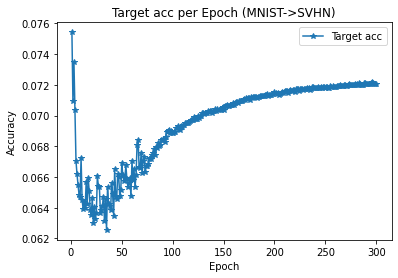

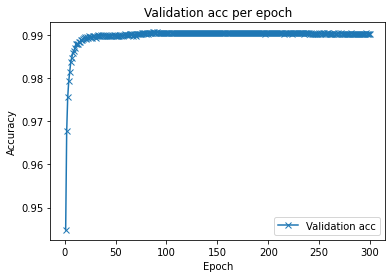

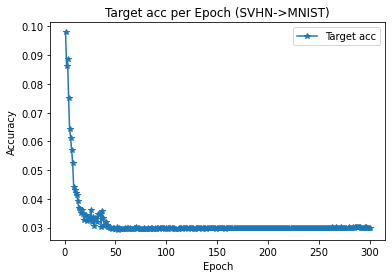

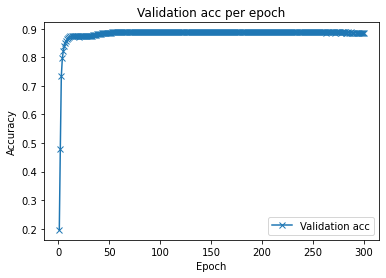

In [9]:
### test for both datasets, to run overnight
total_epochs=300

history = AdditionalValidationSets([(X_test, Y_test, 'target_val')])#(X_train, Y_train, 'svhn_train')
histories=[]
iterations=25


### MNIST -> SVHN
for i in range(iterations):
    model=init_MNIST_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy'],)

    fit_info = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
           callbacks=[history])
    histories.append(history.history)
    
    
    
history = AdditionalValidationSets([(x_test, y_test, 'target_val')])
histories2=[]


### SVHN -> MNIST
for i in range(iterations):
    model=init_SVHN_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy'],)


    fit_info = model.fit(X_train, Y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(X_test, Y_test),
           callbacks=[history])
    histories2.append(history.history)
    
    
K=histories[0].keys()
result={}


for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)
    
result2={}
for key in K:
    tmp2=[]
    for epoch in range(len(histories2)):
        tmp2.append(histories2[epoch][key])
    result2[key]=tmp2

for key in K:
    result2[key]=np.mean(result2[key],axis=0)

    
## plotting and saving to disk
x=[i+1 for i in range(total_epochs)]

f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
f.savefig("MNIST2SVHNval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
f.savefig("SVHN2MNISTval.pdf")

In [ ]:
#fit_info.history
#print(histories)
#print(history.history)


## computing the mean of the histories
#print(histories[0].keys())
K=histories[0].keys()
result={}


for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)




In [ ]:
### plots for MNIST -> SVHN
x=[i+1 for i in range(total_epochs)]
f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
f.savefig("MNIST2SVHNval.pdf")



In [ ]:
#print(histories2)
result2={}
for key in K:
    tmp2=[]
    for epoch in range(len(histories2)):
        tmp2.append(histories2[epoch][key])
    result2[key]=tmp2

for key in K:
    result2[key]=np.mean(result2[key],axis=0)
#print(result2)

In [ ]:
### plots for SVHN -> MNIST
x=[i+1 for i in range(total_epochs)]
f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
f.savefig("SVHN2MNISTval.pdf")